# Clasificación explicable de arritmias cardíacas a partir de electrocardiogramas transformados en espectrogramas mediante redes neuronales convolucionales

## Introducción

Las arritmias cardíacas representan alteraciones en el ritmo normal del corazón y constituyen un problema clínico de gran relevancia debido a su impacto en la salud cardiovascular y la mortalidad asociada. La detección temprana y precisa de estas anomalías es esencial para el diagnóstico oportuno y la toma de decisiones médicas.

En este proyecto se desarrolla un sistema de **clasificación automática de arritmias** a partir del **MIT-BIH Arrhythmia Database**, utilizando señales de electrocardiograma (ECG). Para ello:

- Se extraen fragmentos de latidos individuales de los registros ECG.
- Dichos fragmentos se transforman en **espectrogramas** mediante técnicas de análisis tiempo-frecuencia (STFT).
- Los espectrogramas se emplean como entradas en una **red neuronal convolucional (CNN)** para la clasificación de los diferentes tipos de arritmia.
- Se incorporan métodos de **explicabilidad (XAI)**, como Grad-CAM, para interpretar la relevancia de las regiones espectrales en cada predicción.

El objetivo final es no solo lograr un buen rendimiento en la clasificación, sino también garantizar que el modelo proporcione **explicaciones comprensibles** que respalden la interpretación clínica de los resultados.

## Informe sobre la estructura del MIT-BIH Arrhythmia Database

### 1. Descripción general
El **MIT-BIH Arrhythmia Database** es un conjunto de registros de **electrocardiogramas (ECG)** ampliamente usado en investigación sobre arritmias.  
Características principales:
- **48 registros** de ~30 minutos cada uno.
- Cada registro contiene **2 canales (derivaciones)** de ECG.
- **Frecuencia de muestreo**: ~360 Hz.
- Incluye archivos de datos de señal, encabezados con metadatos y anotaciones manuales de expertos.

---

### 2. Archivos por registro
Para un registro, por ejemplo `100`, se encuentran típicamente:
- **100.dat** → Señal ECG en formato binario.
- **100.hea** → Header con información del registro (fs, canales, unidades).
- **100.atr** → Anotaciones de latidos y ritmos.

---

### 3. Canales (*channels*)
- *Channel* = **una derivación de ECG**.
- Cada registro tiene **2 canales** simultáneos, que pueden corresponder a derivaciones como:
  - MLII (Modified Lead II)
  - V5, V1, V2, III (dependiendo del registro)
- En Python con `wfdb`:
  - `record.p_signal.shape == (n_muestras, n_canales)`
  - Ejemplo: `sig = record.p_signal[:, 0]  # canal 0`

**Resumen**: un canal es simplemente una columna de la matriz de señal, es decir, una derivación distinta del ECG.

---

### 4. Contenido del header `.hea`
El archivo de encabezado describe cómo interpretar la señal:
- **fs**: frecuencia de muestreo.
- **nsig**: número de canales.
- Por canal:
  - **gain**: factor de conversión de digital a mV.
  - **baseline**: valor de referencia del ADC.
  - **units**: normalmente `mV`.
  - **sig_name**: nombre de la derivación (ej. MLII, V5).

---

### 5. Señales en WFDB
- **`record.p_signal`** → matriz en unidades físicas (mV).  
  *Recomendado para análisis.*
- **`record.d_signal`** → señal cruda en unidades digitales (ADC).
- **`record.fs`** → frecuencia de muestreo.
- **`record.sig_name`** → nombres de las derivaciones.

---

### 6. Anotaciones `.atr`
Con `wfdb.rdann(record, 'atr')` obtenemos:
- **`ann.sample`** → índice de muestra del latido (entero).
- **`ann.symbol`** → símbolo de la anotación (ej.: `N`, `V`, `A`, `F`).
- **`ann.aux_note`** → notas adicionales (ej. episodios de AFIB).
- **`ann.chan`** → canal asociado a la anotación.

---

### 7. Símbolos y clases AAMI
Los símbolos de latido se mapean a las clases estandarizadas de AAMI:

- **N**: normales y similares → `N, L, R, e, j`
- **S**: supraventriculares → `A, a, J, S`
- **V**: ventriculares → `V, E`
- **F**: fusión → `F`
- **Q**: otros → `/`, `f`, `Q`, `?`, `|`

Este mapeo permite reducir la complejidad a 5 clases principales: **N, S, V, F, Q**.

---

### 8. Variables en un dataset procesado
Al extraer latidos, se obtiene un `DataFrame` con:
- **Metadatos**
  - `record_id`: registro (ej. `"100"`).
  - `patient_id`: identificador del paciente (≈ record_id en MIT-BIH).
  - `fs`: frecuencia de muestreo.
  - `sample_index`: posición de la muestra del latido.
  - `mit_symbol`: símbolo original.
  - `aami_class`: clase agrupada AAMI.

- **Características de señal**
  - `amp_peak`: amplitud pico a pico.
  - `energy`: suma de cuadrados (energía).
  - `area`: integral bajo la curva.
  - `qrs_width_s`: ancho del QRS en segundos.
  - `mean_v`, `std_v`, `skew_v`, `kurt_v`: estadísticos.
  - `frag_len_samples`: longitud del fragmento extraído.

- **Calidad / anomalías**
  - `flag_saturation`: latido con amplitud extrema.
  - `flag_high_noise`: latido con desviación estándar muy alta.
  - `is_outlier`: outlier según IsolationForest.

---

### 9. Tiempo, muestras y ventanas
- Un latido está centrado en `sample_index`.
- Se extrae un **fragmento** alrededor (ej. −200 ms a +200 ms).
- Conversión: `tiempo (s) = sample_index / fs`.

---

### 10. Resumen práctico
- **Canal**: una derivación (columna de señal).
- **Muestra**: índice en la señal (convierte a tiempo con fs).
- **Latido**: anotación en `ann.sample` con símbolo en `ann.symbol`.
- **Clase**: `mit_symbol` → `aami_class`.
- **Header**: describe cómo convertir digital a físico y nombres de canales.
- **Split correcto**: por `record_id` o `patient_id` para evitar fuga.

#### Importar librerías necesarias

In [1]:
import os
import warnings
from pathlib import Path
from typing import List, Tuple

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import scipy.stats as st

try:
    import statsmodels.api as sm
    from statsmodels.stats.multitest import multipletests
except ImportError:
    sm = None
    multipletests = None
    warnings.warn("statsmodels no disponible; algunas pruebas estadísticas no estarán disponibles")

try:
    import wfdb
except ImportError:
    wfdb = None
    warnings.warn("wfdb no instalado; instala con `pip install wfdb` para poder leer señales crudas")

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 5)
pd.set_option("display.max_columns", None)

## Helpers para lectura de registros

En esta sección se definen funciones de utilidad para trabajar con los registros del **MIT-BIH Arrhythmia Database** desde archivos locales:

- **`list_records(data_dir)`**  
  Lee el archivo `RECORDS` en la carpeta del dataset y devuelve una lista de registros disponibles (ej. `"100"`, `"101"`, ...).  
  Sirve para iterar automáticamente sobre los registros sin escribirlos a mano.

- **`load_record_local(record_name, data_dir)`**  
  Carga un registro completo desde los archivos `.dat`, `.hea` y `.atr`.  
  Devuelve:
  - `signals`: arreglo NumPy con la señal ECG en mV (`n_muestras × n_canales`).
  - `meta`: diccionario con metadatos (frecuencia, nombres de derivaciones, longitud, unidades, etc.).
  - `annot`: objeto `wfdb.Annotation` con las anotaciones de latidos y símbolos.

- **`plot_signal_with_annotations(signals, annot, meta, start_sec, duration_sec, channel)`**  
  Grafica un segmento de la señal ECG en un rango de tiempo definido, mostrando en rojo las posiciones de los latidos anotados.  
  Parámetros útiles:
  - `start_sec`: segundo inicial del segmento.
  - `duration_sec`: duración en segundos.
  - `channel`: canal (derivación) a visualizar.

- **`get_basic_stats(signals)`**  
  Calcula estadísticas simples de toda la señal: mínimo, máximo, media, mediana y desviación estándar.  
  Útil para una primera exploración rápida del registro.

In [2]:
def list_records(data_dir: str) -> List[str]:
    """
    Lee el archivo RECORDS en la carpeta del MIT-BIH y devuelve la lista de registros (sin extensión).
    Esto permite iterar sobre los registros disponibles.
    """
    recs_path = Path(data_dir) / "RECORDS"
    if not recs_path.exists():
        raise FileNotFoundError(f"No se encontró el archivo RECORDS en {data_dir}")
    with open(recs_path, "r") as f:
        lines = [line.strip() for line in f if line.strip()]
    return lines

def load_record_local(record_name: str, data_dir: str) -> Tuple[np.ndarray, dict, wfdb.Annotation]:
    """
    Carga un registro del MIT-BIH desde archivos locales (.dat, .hea, .atr).
    Retorna:
      - signals: arreglo numpy (n_muestras, n_canales)
      - meta: diccionario con metadatos (frecuencia, nombres de señales, longitud)
      - annot: objeto wfdb.Annotation con latidos anotados (posiciones, símbolos)
    """
    base_path = str(Path(data_dir) / record_name)
    record = wfdb.rdrecord(base_path, physical=True)
    signals = record.p_signal
    meta = {
        "fs": record.fs,
        "units": record.units,
        "sig_name": record.sig_name,
        "comments": record.comments,
        "n_sig": record.n_sig,
        "sig_len": record.sig_len
    }
    annot = wfdb.rdann(base_path, extension="atr")
    return signals, meta, annot

def plot_signal_with_annotations(signals: np.ndarray, annot: wfdb.Annotation, meta: dict, 
                                 start_sec: float = 0.0, duration_sec: float = 5.0, channel: int = 0):
    """
    Grafica un segmento de la señal ECG con las anotaciones de latidos superpuestas.
    - start_sec: segundo inicial
    - duration_sec: duración en segundos
    - channel: indice del canal a graficar
    """
    fs = meta["fs"]
    start_idx = int(start_sec * fs)
    end_idx = int((start_sec + duration_sec) * fs)
    t = np.arange(start_idx, end_idx) / fs  # tiempo en segundos

    plt.figure(figsize=(14, 4))
    plt.plot(t, signals[start_idx:end_idx, channel], label=f"Señal canal {channel}")
    # anotaciones dentro del rango
    mask = (annot.sample >= start_idx) & (annot.sample < end_idx)
    valid_idx = annot.sample[mask][annot.sample[mask] < signals.shape[0]]
    ann_y = signals[valid_idx, channel]
    ann_x = valid_idx / fs
    plt.scatter(ann_x, ann_y, c='red', marker='x', label="Latidos anotados")
    plt.title(f"Registro — señal ECG (canal {channel}) con anotaciones\nSegmento {start_sec:.1f}–{start_sec+duration_sec:.1f} s")
    plt.xlabel("Tiempo (s)")
    plt.ylabel("Voltaje (mV)")
    plt.legend()
    plt.tight_layout()
    plt.show()

def get_basic_stats(signals: np.ndarray) -> dict:
    """
    Calcula estadísticas simples de la señal completa:
    min, max, mean, median, std.
    """
    return {
        "min": float(np.min(signals)),
        "max": float(np.max(signals)),
        "mean": float(np.mean(signals)),
        "median": float(np.median(signals)),
        "std": float(np.std(signals))
    }

## EJECUCIÓN del EDA

## 1.1 Carga y Exploración Inicial

En esta primera etapa se realiza la **exploración básica del MIT-BIH** para familiarizarse con la estructura de los registros y validar la correcta lectura de los datos.

### Acciones principales
- **Listar registros**: a partir del archivo `RECORDS`, identificando cuántos hay y sus nombres.  
- **Cargar un registro de prueba**: obtener señal (`signals`), metadatos (`meta`) y anotaciones (`annot`).  
- **Explorar anotaciones**: revisar muestras y símbolos de los primeros latidos.  
- **Visualizar señal + anotaciones**: graficar un segmento de 5s con los latidos marcados.  
- **Estadísticas básicas**: mínimo, máximo, media, mediana y desviación estándar.  
- **Comparar registros**: calcular estadísticas de los primeros 5 registros y graficar distribución (boxplot).  
- **Convertir señal en DataFrame**: fragmento inicial en formato tabular (tiempo, voltaje).  
- **Control de calidad**: verificar valores faltantes (`NaN`) en señales y anotaciones.  
- **Explorar anotaciones en DataFrame**: visualizar, contar símbolos y revisar posibles valores faltantes.  

### Propósito
- Verificar que los datos se cargan correctamente.  
- Confirmar la correspondencia entre señales y anotaciones.  
- Identificar las clases de latidos presentes.  
- Detectar problemas de calidad (NaN, valores extremos).  

Cantidad de registros disponibles: 48
Algunos registros de ejemplo: ['100', '101', '102', '103', '104']

Metadatos del registro 100:
  fs: 360
  units: ['mV', 'mV']
  sig_name: ['MLII', 'V5']
  comments: ['69 M 1085 1629 x1', 'Aldomet, Inderal']
  n_sig: 2
  sig_len: 650000

Primeras 10 anotaciones (muestra, símbolo):
[(np.int64(18), '+'), (np.int64(77), 'N'), (np.int64(370), 'N'), (np.int64(662), 'N'), (np.int64(946), 'N'), (np.int64(1231), 'N'), (np.int64(1515), 'N'), (np.int64(1809), 'N'), (np.int64(2044), 'A'), (np.int64(2402), 'N')]


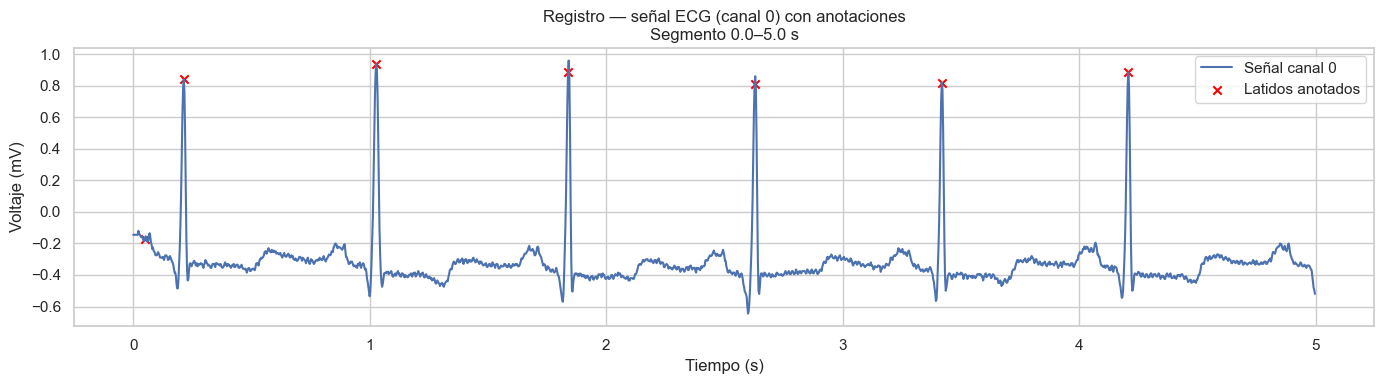


Estadísticas básicas del registro 100:
  min: -2.715000
  max: 1.435000
  mean: -0.248667
  median: -0.270000
  std: 0.181571

Comparativa de estadísticas entre registros:


,min,max,mean,median,std,record,fs
0,-2.715,1.435,-0.248667,-0.270,0.181571,100,360
1,-3.175,2.420,-0.181168,-0.130,0.214342,101,360
2,-3.370,2.535,-0.116636,-0.175,0.829847,102,360
3,-5.120,5.115,-0.092207,-0.120,0.554285,103,360
4,-1.935,1.975,-0.076740,-0.055,0.271685,104,360


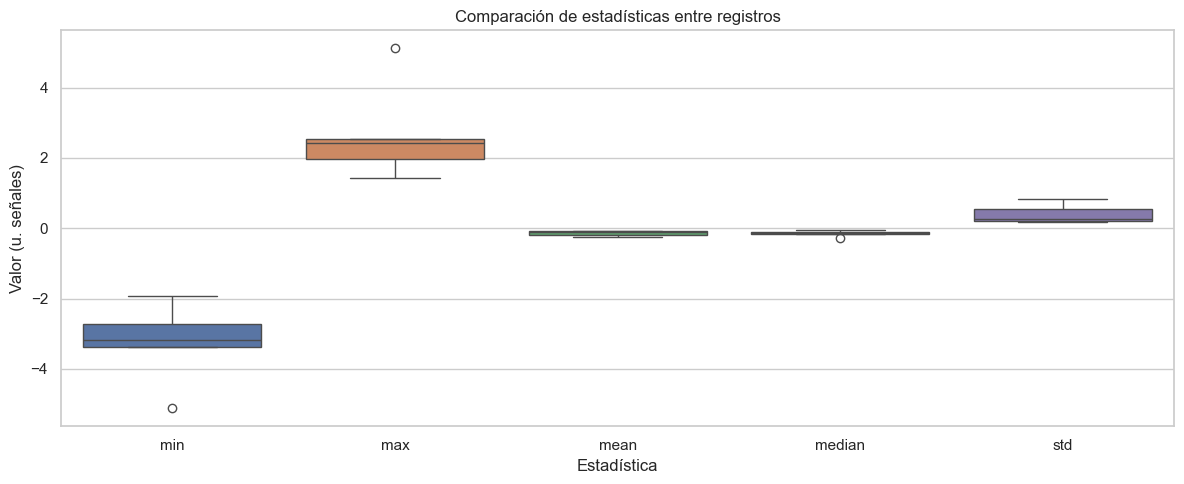


Primeras filas del fragmento de señal (registro 100):


,time_s,signal_ch0
0,0.000000,-0.145
1,0.002778,-0.145
2,0.005556,-0.145
3,0.008333,-0.145
4,0.011111,-0.145



Últimas filas del fragmento:


,time_s,signal_ch0
995,2.763889,-0.395
996,2.766667,-0.390
997,2.769444,-0.385
998,2.772222,-0.375
999,2.775000,-0.385



Información del DataFrame de señal fragmentada:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   time_s      1000 non-null   float64
 1   signal_ch0  1000 non-null   float64
dtypes: float64(2)
memory usage: 15.8 KB
None

Resumen estadístico del fragmento:


,time_s,signal_ch0
count,1000.000000,1000.000000
mean,1.387500,-0.311885
std,0.802276,0.183355
min,0.000000,-0.645000
25%,0.693750,-0.390000
50%,1.387500,-0.340000
75%,2.081250,-0.295000
max,2.775000,0.960000



Número total de valores NaN en señales del registro 100: 0

Primeras filas de las anotaciones del registro 100:


,sample,symbol
0,18,+
1,77,N
2,370,N
3,662,N
4,946,N



Últimas filas de las anotaciones:


,sample,symbol
2269,648978,N
2270,649232,N
2271,649484,N
2272,649734,N
2273,649991,N



Información del DataFrame de anotaciones:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2274 entries, 0 to 2273
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   sample  2274 non-null   int64 
 1   symbol  2274 non-null   object
dtypes: int64(1), object(1)
memory usage: 35.7+ KB
None

Frecuencia de símbolos de anotaciones (conteos):
symbol
N    2239
A      33
+       1
V       1
Name: count, dtype: int64

Número total de valores faltantes en anotaciones: 0


In [3]:
# — Parámetro: ruta al directorio del dataset local
DATA_DIR = "./mit-bih-arrhythmia-database-1.0.0"

# — Listar los registros disponibles mediante el helper que definiste
records = list_records(DATA_DIR)
print("Cantidad de registros disponibles:", len(records))
print("Algunos registros de ejemplo:", records[:5])

# — Elegir un registro de prueba para exploración inicial
rec0 = records[0]

# — Cargar señal, metadatos y anotaciones de ese registro
signals0, meta0, annot0 = load_record_local(rec0, DATA_DIR)

print(f"\nMetadatos del registro {rec0}:")
for k, v in meta0.items():
    print(f"  {k}: {v}")
print("\nPrimeras 10 anotaciones (muestra, símbolo):")
print(list(zip(annot0.sample[:10], annot0.symbol[:10])))

# — Visualizar un segmento de la señal con anotaciones superpuestas
plot_signal_with_annotations(signals0, annot0, meta0, start_sec=0, duration_sec=5.0, channel=0)

# — Calcular estadísticas básicas de toda la señal cargada
stats0 = get_basic_stats(signals0)
print(f"\nEstadísticas básicas del registro {rec0}:")
for k, v in stats0.items():
    print(f"  {k}: {v:.6f}")

# — Comparativa entre varios registros: construir lista de estadísticas resumidas
n_iter = min(5, len(records))  # número de registros a comparar
stats_list = []
for rec in records[:n_iter]:
    sig, meta, annot = load_record_local(rec, DATA_DIR)
    s = get_basic_stats(sig)
    s["record"] = rec
    s["fs"] = meta["fs"]
    stats_list.append(s)

df_stats = pd.DataFrame(stats_list)
print("\nComparativa de estadísticas entre registros:")
display(df_stats)

# — Visualización de la dispersión de estadísticas (mínimo, máximo, media, etc.)
sns.boxplot(data=df_stats.drop(columns=["record", "fs"]))
plt.title("Comparación de estadísticas entre registros")
plt.xlabel("Estadística")
plt.ylabel("Valor (u. señales)")
plt.tight_layout()
plt.show()

# — Convertir un fragmento de la señal en DataFrame para mostrar con Pandas
N = min(1000, signals0.shape[0])
df_signal0 = pd.DataFrame({
    "time_s": np.arange(N) / meta0["fs"],
    "signal_ch0": signals0[:N, 0]
})
print(f"\nPrimeras filas del fragmento de señal (registro {rec0}):")
display(df_signal0.head())
print("\nÚltimas filas del fragmento:")
display(df_signal0.tail())

# — Mostrar info() y resumen estadístico del fragmento
print("\nInformación del DataFrame de señal fragmentada:")
print(df_signal0.info())
print("\nResumen estadístico del fragmento:")
display(df_signal0.describe())

# — Verificar si hay valores faltantes (NaN) en la señal completa
n_nan = np.isnan(signals0).sum()
print(f"\nNúmero total de valores NaN en señales del registro {rec0}: {n_nan}")

# — Crear DataFrame para anotaciones y explorarlas
df_annot0 = pd.DataFrame({
    "sample": annot0.sample,
    "symbol": annot0.symbol
})
print(f"\nPrimeras filas de las anotaciones del registro {rec0}:")
display(df_annot0.head())
print("\nÚltimas filas de las anotaciones:")
display(df_annot0.tail())

print("\nInformación del DataFrame de anotaciones:")
print(df_annot0.info())

print("\nFrecuencia de símbolos de anotaciones (conteos):")
print(df_annot0["symbol"].value_counts())

# Comprobar valores faltantes en anotaciones
n_nan_annot = df_annot0.isna().sum().sum()
print(f"\nNúmero total de valores faltantes en anotaciones: {n_nan_annot}")

### Resultados de la exploración inicial

- El dataset contiene **48 registros** (ejemplos: `100`, `101`, `102`, `103`, `104`).  
- En el **registro 100** se observó:  
  - **Metadatos**: frecuencia de muestreo 360 Hz, 2 canales (`MLII`, `V5`), longitud ≈ 650.000 muestras.  
  - **Primeras anotaciones**: símbolos `N`, `A` y `+` correctamente alineados con los latidos de la señal.  
  - **Visualización (0–5 s)**: se comprobó la correspondencia entre la señal y los picos de los latidos anotados.  
  - **Estadísticas básicas**: min –2.71 mV, max 1.43 mV, media –0.25 mV, desviación estándar 0.18 mV.  

- **Comparativa entre registros** (primeros 5):  
  - Los valores de amplitud y dispersión difieren entre registros.  
  - El boxplot mostró variabilidad en media, rango y desviación estándar.  

- **Fragmento de señal en DataFrame** (1000 muestras iniciales, canal 0):  
  - No se detectaron valores faltantes (`NaN = 0`).  
  - Media ≈ –0.31 mV, rango –0.64 a 0.96 mV.  

- **Anotaciones en DataFrame** (registro 100):  
  - Total: 2274 anotaciones.  
  - Distribución: `N` (2239), `A` (33), `V` (1), `+` (1).  
  - Sin valores faltantes en símbolos ni posiciones.  

### Conclusiones inmediatas
- Los datos se cargan correctamente y son consistentes.  
- Existe variabilidad entre registros que deberá considerarse en análisis posteriores.  
- El registro 100 presenta mayoritariamente latidos normales (`N`), con pocos supraventriculares (`A`) y casos aislados de otras clases.  
- No se detectaron problemas de calidad (NaN) en señales ni en anotaciones.  


### Diccionario de mapeo MIT-BIH → AAMI

El dataset MIT-BIH contiene una gran variedad de símbolos para los latidos, lo que dificulta su análisis.  
Para estandarizar, se aplica el **mapeo a clases AAMI**, que agrupa los símbolos en **5 categorías principales**:

- **N (Normal):** `N, L, R, e, j`  
- **S (Supraventricular):** `A, a, J, S`  
- **V (Ventricular):** `V, E`  
- **F (Fusión):** `F`  
- **Q (Otros/Desconocidos):** `/ , f, Q` (incluye marcapasos, ruido u otros no clasificados)  

**Ventajas del mapeo:**
- Reduce complejidad de símbolos → 5 clases principales.  
- Estándar usado en la comunidad científica.  
- Facilita el balanceo de clases y el diseño del clasificador.  

---

### Función `map_to_aami(symbols)`

- **Objetivo:** convertir automáticamente una lista de símbolos MIT-BIH en sus clases AAMI.  
- **Implementación:** usa el diccionario `MITBIH_to_AAMI`; si un símbolo no está definido, se asigna a la clase `"Q"`.  
- **Uso práctico:** al procesar un `DataFrame` de anotaciones, permite crear una columna adicional con la clase AAMI.  

In [4]:
# —— Diccionario de mapeo de símbolos MIT-BIH a clases AAMI
MITBIH_to_AAMI = {
    # Clase Normal (N)
    "N": "N",  "L": "N",  "R": "N",  "e": "N",  "j": "N",
    # Supraventricular (S)
    "A": "S",  "a": "S",  "J": "S",  "S": "S",
    # Ventricular (V)
    "V": "V",  "E": "V",
    # Fusión (F)
    "F": "F",
    # Desconocido / otros (Q)
    "/": "Q",  "f": "Q",  "Q": "Q",
}

def map_to_aami(symbols: List[str]) -> List[str]:
    """Mapea cada símbolo MIT-BIH a su clase AAMI correspondiente."""
    return [MITBIH_to_AAMI.get(s, "Q") for s in symbols]

## Paso previo: construcción de `df_beats` (extracción de características por latido)

Cada latido anotado en MIT-BIH se identifica con la posición de su **pico R** (`annot.sample`).  
A partir de esa posición, se extrae un **fragmento de señal** (ventana alrededor del R-peak) y se calculan **características morfológicas y estadísticas**.

### Objetivo
Construir un **DataFrame por latido (`df_beats`)** donde cada fila represente un latido con:
- Su símbolo original y clase AAMI correspondiente.  
- Variables que describan la forma y energía del complejo QRS.  
- Valores útiles para análisis exploratorio y posterior clasificación.

### Características extraídas (ejemplos)
- **Amplitud**: `amplitude_peak`, `amplitude_min`, `peak-to-peak`.  
- **Estadísticas**: `mean_voltage`, `std_voltage`.  
- **Medidas de energía**: `energy` (suma de cuadrados), `area` (integral del módulo).  
- **Duración**: `duration_s` (constante si la ventana es fija).  
- **Etiqueta**: `class_AAMI` (N, S, V, F, Q).  

### Utilidad
- Permite analizar diferencias morfológicas entre clases de latidos.  
- Sirve como base para **EDA**, selección de variables y entrenamiento de modelos de clasificación.  

In [5]:
from scipy.integrate import trapezoid

def extract_beat_features(signals: np.ndarray, annot: wfdb.Annotation, meta: dict,
                          pre_samples: int = 100, post_samples: int = 100) -> pd.DataFrame:
    """
    Extrae características de cada latido centrado en el pico R.
    signals: la señal completa (n_muestras, n_canales)
    annot: anotaciones con posiciones de latido (muestras) y símbolos
    meta: metadatos con fs etc.
    pre_samples, post_samples: cuántas muestras antes y después del pico incluir
    Retorna un DataFrame con una fila por latido y columnas:
     - sample (posición del pico)
     - symbol (símbolo original)
     - class_AAMI (clase mapeada)
     - características numéricas (peak, min, energy, area, duration, etc.)
    """
    beats = []
    fs = meta["fs"]
    # Asumir canal 0 (se puede usar otro canal)
    chan = signals[:, 0]

    for i, samp in enumerate(annot.sample):
        s = int(samp)
        start = s - pre_samples
        end = s + post_samples
        # Validar bordes
        if start < 0 or end >= len(chan):
            continue
        frag = chan[start:end]
        # Características numéricas
        amp_peak = float(np.max(frag))
        amp_min = float(np.min(frag))
        mean_v = float(np.mean(frag))
        std_v = float(np.std(frag))
        energy = float(np.sum(frag ** 2))
        area = float(trapezoid(np.abs(frag), dx=1/fs))  # integral de valor absoluto
        duration = (end - start) / fs  # en segundos

        # Símbolo y clase AAMI
        sym = annot.symbol[i]
        class_aami = MITBIH_to_AAMI.get(sym, "Q")

        beats.append({
            "sample": s,
            "symbol": sym,
            "class_AAMI": class_aami,
            "amplitude_peak": amp_peak,
            "amplitude_min": amp_min,
            "mean_voltage": mean_v,
            "std_voltage": std_v,
            "energy": energy,
            "area": area,
            "duration_s": duration
        })

    df = pd.DataFrame(beats)
    return df

# Ejemplo uso:
df_beats0 = extract_beat_features(signals0, annot0, meta0, pre_samples=100, post_samples=100)
print(df_beats0.head())
print(df_beats0["class_AAMI"].value_counts())

   sample symbol class_AAMI  amplitude_peak  amplitude_min  mean_voltage  \
0     370      N          N           0.940         -0.535     -0.308750   
1     662      N          N           0.960         -0.570     -0.332250   
2     946      N          N           0.860         -0.645     -0.338775   
3    1231      N          N           0.820         -0.565     -0.339350   
4    1515      N          N           0.885         -0.545     -0.328200   

   std_voltage     energy      area  duration_s  
0     0.222864  28.998950  0.201431    0.555556  
1     0.204799  30.466550  0.208431    0.555556  
2     0.194000  30.480875  0.209826    0.555556  
3     0.183124  29.738600  0.207667    0.555556  
4     0.194361  29.098300  0.203937    0.555556  
class_AAMI
N    2237
S      33
V       1
Name: count, dtype: int64


### Construcción del dataset global de latidos (todos los registros)

Se recorre **todo el MIT-BIH Arrhythmia Database** para generar un **dataset tabular de latidos (`df_beats`)**.  
Cada fila representa un latido con su símbolo original, clase AAMI y características numéricas extraídas de la señal.

---

### Procedimiento
1. **Recorrido por registros**  
   - Se cargan señales y anotaciones de cada registro.  
   - Se extraen características morfológicas y estadísticas de cada latido (`extract_beat_features`).  
   - Se añade el identificador del registro a cada fila.  

2. **Unificación del dataset**  
   - Todos los DataFrames parciales se concatenan en `df_beats`.  
   - Columnas incluidas:  
     - Metadatos (`record`, `sample`, `symbol`, `class_AAMI`).  
     - Características (amplitud pico, mínimo, media, std, energía, área, duración, etc.).  

3. **Distribución de clases**  
   - Conteo global de latidos por clase AAMI.  
   - Gráfico de barras revela un **fuerte desbalance**:  
     - Clase **N (Normal)** domina (>70%).  
     - Clases **S, V, F, Q** aparecen en proporciones mucho menores.  

---

### Objetivo de este paso
- Construir el **dataset unificado de latidos** como base para el análisis exploratorio y los modelos de clasificación.  
- Identificar desde el inicio el **problema de desbalance de clases**, crucial en aplicaciones clínicas y de machine learning.  


Tamaño total de df_beats: (112572, 11)

Primeras filas del dataset global de latidos:


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record
0,370,N,N,0.940,-0.535,-0.308750,0.222864,28.998950,0.201431,0.555556,100
1,662,N,N,0.960,-0.570,-0.332250,0.204799,30.466550,0.208431,0.555556,100
2,946,N,N,0.860,-0.645,-0.338775,0.194000,30.480875,0.209826,0.555556,100
3,1231,N,N,0.820,-0.565,-0.339350,0.183124,29.738600,0.207667,0.555556,100
4,1515,N,N,0.885,-0.545,-0.328200,0.194361,29.098300,0.203937,0.555556,100



Conteo global de clases AAMI:
class_AAMI
F      802
N    90603
Q    11151
S     2781
V     7235
Name: count, dtype: int64


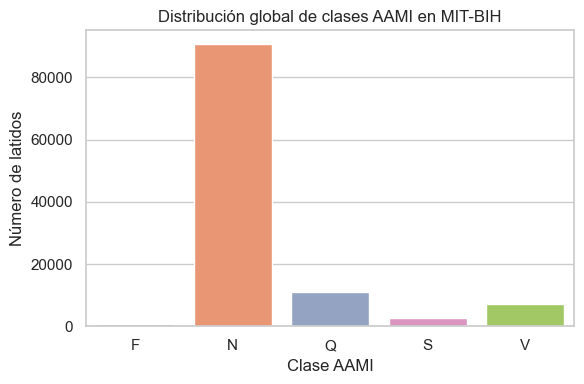

In [6]:
all_beats = []

for rec in records:
    # Cargar señal y anotaciones
    sig, meta, annot = load_record_local(rec, DATA_DIR)
    
    # Extraer características por latido
    df_tmp = extract_beat_features(sig, annot, meta, pre_samples=100, post_samples=100)
    df_tmp["record"] = rec  # guardar de qué registro viene cada latido
    
    all_beats.append(df_tmp)

# Concatenar todo en un único DataFrame
df_beats = pd.concat(all_beats, ignore_index=True)

print(f"\nTamaño total de df_beats: {df_beats.shape}")
print("\nPrimeras filas del dataset global de latidos:")
display(df_beats.head())

# =====================================================
# Análisis de distribución de clases AAMI (global df_beats)
# =====================================================

class_counts = df_beats["class_AAMI"].value_counts().sort_index()
print("\nConteo global de clases AAMI:")
print(class_counts)

# Gráfico de barras
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="Set2", legend=False)
plt.title("Distribución global de clases AAMI en MIT-BIH")
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
plt.tight_layout()
plt.show()

## Resultados de la construcción del dataset global de latidos

- **Tamaño del dataset:**  
  `df_beats` contiene **112,572 latidos** con 11 variables (símbolos, clase AAMI, características numéricas y registro de origen).

- **Primeras filas del dataset:**  
  Se observan los valores de amplitud, media, desviación estándar, energía y área para los primeros latidos del registro 100, todos clasificados como **N (Normal)**.

- **Distribución global de clases AAMI:**  
  - **N (Normales):** 90,663  
  - **S (Supraventriculares):** 2,781  
  - **V (Ventriculares):** 7,235  
  - **F (Fusión):** 802  
  - **Q (Otros/Desconocidos):** 11,151  

- **Visualización:**  
  El gráfico de barras confirma un **fuerte desbalance de clases**:
  - La clase **N** domina el dataset (>80%).  
  - Las clases **S, V, F y Q** aparecen en proporciones mucho menores.

### Conclusiones inmediatas
- Se generó exitosamente un **dataset tabular y unificado** de latidos.  
- La gran mayoría de los latidos pertenecen a la clase normal (N).  
- El **desbalance de clases** es evidente y será un reto clave para la fase de clasificación.  

## Análisis de distribución de clases AAMI

En esta sección se analiza el **balance de clases** en el dataset global de latidos (`df_beats`).

**Pasos realizados:**
- **Conteo por clase**: se calcula el número total de latidos para cada categoría AAMI (N, S, V, F, Q).  
- **Porcentaje por clase**: se obtiene la proporción relativa de cada clase respecto al total.  
- **Construcción de tabla resumen**: muestra para cada clase AAMI el conteo absoluto y el porcentaje.  
- **Visualización**: gráfico de barras donde:
  - El eje Y representa el número de latidos.  
  - Cada barra corresponde a una clase AAMI.  
  - Se anotan los porcentajes encima de las barras para facilitar la interpretación.  

**Propósito:**  
Detectar tempranamente el **desbalance de clases** característico de MIT-BIH, un aspecto crítico para la posterior construcción de modelos de clasificación.

,Clase AAMI,Conteo,Porcentaje
0,F,802,0.71
1,N,90603,80.48
2,Q,11151,9.91
3,S,2781,2.47
4,V,7235,6.43


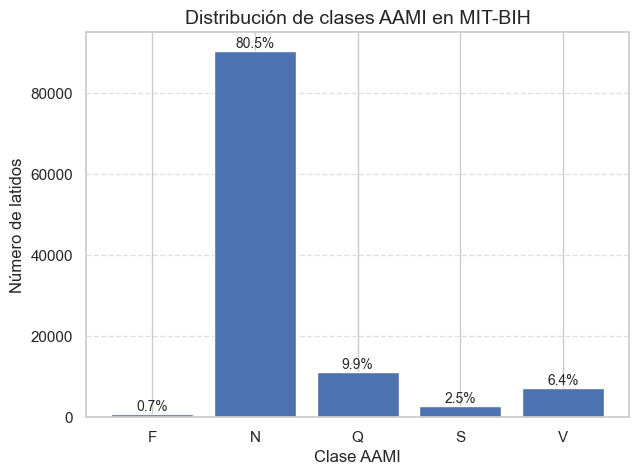

In [7]:
import matplotlib.pyplot as plt

# Tabla de conteos y porcentajes
class_counts = df_beats["class_AAMI"].value_counts().sort_index()
class_perc = df_beats["class_AAMI"].value_counts(normalize=True).sort_index() * 100

# Construcción de DataFrame resumen
df_balance = pd.DataFrame({
    "Clase AAMI": class_counts.index,
    "Conteo": class_counts.values,
    "Porcentaje": class_perc.values.round(2)
})

display(df_balance)

# Gráfico de barras
plt.figure(figsize=(7,5))
bars = plt.bar(df_balance["Clase AAMI"], df_balance["Conteo"])

# Añadir porcentajes encima de cada barra
for bar, perc in zip(bars, df_balance["Porcentaje"]):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(),
             f"{perc:.1f}%", ha="center", va="bottom", fontsize=10)

plt.title("Distribución de clases AAMI en MIT-BIH", fontsize=14)
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
plt.grid(axis="y", linestyle="--", alpha=0.6)
plt.show()

## Resultados de la distribución de clases AAMI

- El dataset está **fuertemente desbalanceado**:  
  - La clase **N** concentra más del **80% de los latidos**.  
  - Las clases **S, V, F y Q** tienen una representación mucho menor.  
- Este desbalance debe ser **corregido o compensado** en fases posteriores mediante estrategias de balanceo para evitar sesgos en los modelos de clasificación.  


## 1.2: Análisis Univariado

El análisis univariado examina **una variable a la vez** (clases de latido o métricas numéricas) para describir su distribución, escala, valores atípicos y posibles sesgos.

---

### 1.2.a) Variable categórica — Distribución de clases AAMI
- **Qué hace:**  
  - Aplica el diccionario `MITBIH_to_AAMI` y la función `map_to_aami(...)` para convertir símbolos de MIT-BIH (`N, V, A`, etc.) en las **5 clases AAMI**: `N, S, V, F, Q`.  
  - Calcula conteos y proporciones (`value_counts`).  
  - Visualiza la distribución con un **gráfico de barras** (y opcionalmente un gráfico de pastel).  

- **Para qué sirve:**  
  - Validar el correcto mapeo de símbolos.  
  - Evaluar el **balance de clases** y detectar rarezas en el registro.

---

### 1.2.b) Variables numéricas — Estadística descriptiva y outliers
- **Qué hace:**  
  - Usa `df_stats` (estadísticas por registro) para analizar métricas como `min`, `max`, `mean`, `median`, `std`.  
  - Calcula indicadores de **tendencia central y dispersión** (media, desviación estándar, IQR, CV).  
  - Evalúa la **forma de la distribución** (asimetría y curtosis).  
  - Detecta **outliers** con la regla de Tukey (IQR).  
  - Visualiza con **histogramas/KDE** y **boxplots**.  

- **Para qué sirve:**  
  - Comprender la **escala y variabilidad entre registros** (pacientes/derivaciones).  
  - Identificar valores extremos y anticipar si será necesario un preprocesado (limpieza, winsorizing, escalado robusto).

---

### 1.2.c) Señal fragmentada (canal 0)
- **Qué hace:**  
  - Analiza el fragmento `df_signal0["signal_ch0"]` (primeras muestras de canal 0).  
  - Calcula estadísticos básicos (media, mediana, std, skew, kurtosis, percentiles).  
  - Detecta outliers por IQR y visualiza con **histograma/KDE** y **boxplot**.  

- **Para qué sirve:**  
  - Observar la **distribución local** de una señal.  
  - Decidir si se requiere **escalado o normalización** antes de extraer características o entrenar modelos.  


Conteos por clase AAMI:
class_AAMI
N    2239
Q       1
S      33
V       1
Name: count, dtype: int64

Proporciones por clase AAMI:
class_AAMI
N    98.46%
Q     0.04%
S     1.45%
V     0.04%
Name: proportion, dtype: object


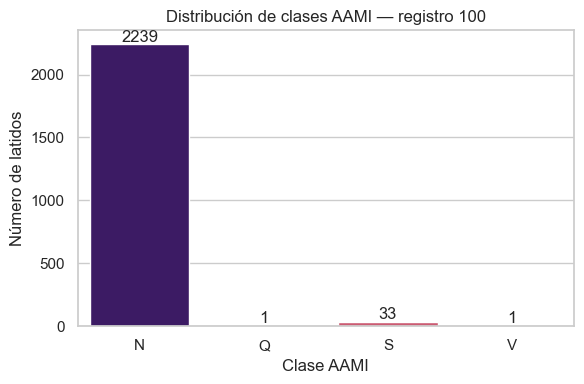

In [8]:
# —— 1.2.a) Para la variable categórica: clases AAMI

# (Tomando el registro de prueba rec0 y df_annot0 que ya se tiene de la sección 1.1)
df_annot0["class_AAMI"] = map_to_aami(df_annot0["symbol"])

# Tabla de frecuencias y proporciones por clase AAMI
counts = df_annot0["class_AAMI"].value_counts().sort_index()
props = df_annot0["class_AAMI"].value_counts(normalize=True).sort_index()

print("Conteos por clase AAMI:")
print(counts)
print("\nProporciones por clase AAMI:")
print(props.apply(lambda x: f"{x*100:.2f}%"))

# Gráfico de barras de distribuciones de clases AAMI
plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="magma", legend=False)
plt.title(f"Distribución de clases AAMI — registro {rec0}")
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts.values)*0.01, str(v), ha="center")
plt.tight_layout()
plt.show()

## Resultados: distribución de clases AAMI (registro 100)

- **Conteo de latidos por clase AAMI**:  
  - N (Normales): 2239  
  - S (Supraventriculares): 33  
  - Q (Otros/Desconocidos): 1  
  - V (Ventriculares): 1  
  - F (Fusión): 0  

- **Proporciones relativas**:  
  - N: 98.5 %  
  - S: 1.45 %  
  - Q: 0.04 %  
  - V: 0.04 %  

- **Visualización**:  
  El gráfico de barras confirma que la clase **N (Normal)** es dominante, mientras que las demás categorías son marginales.

### Conclusiones
- Existe un **desbalance extremo** de clases en este registro: casi todos los latidos son normales.  
- La baja representación de clases **S, V y Q** anticipa un reto para el entrenamiento de modelos.  
- Este patrón es consistente con el comportamiento esperado del dataset MIT-BIH y motiva la aplicación de técnicas de **balanceo de clases** en fases posteriores.

Conteos globales por clase AAMI:
class_AAMI
N    90603
S     2781
V     7235
F      802
Q    11151
Name: count, dtype: int64

Proporciones globales por clase AAMI:
class_AAMI
N    80.48%
S     2.47%
V     6.43%
F     0.71%
Q     9.91%
Name: proportion, dtype: object


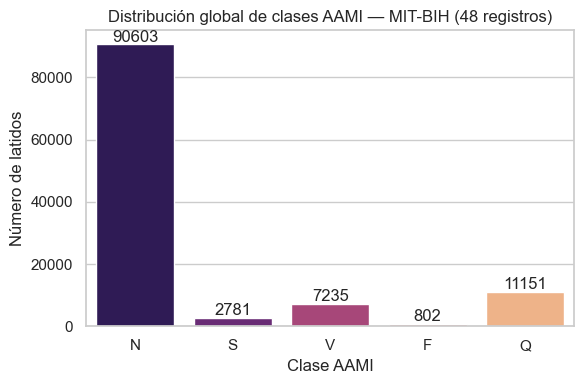

In [9]:
# —— 1.2.a) Para la variable categórica: clases AAMI (nivel global)

# Tabla de frecuencias y proporciones por clase AAMI en todos los registros
counts_global = df_beats["class_AAMI"].value_counts().reindex(["N","S","V","F","Q"], fill_value=0)
props_global = df_beats["class_AAMI"].value_counts(normalize=True).reindex(["N","S","V","F","Q"], fill_value=0)

print("Conteos globales por clase AAMI:")
print(counts_global)
print("\nProporciones globales por clase AAMI:")
print(props_global.apply(lambda x: f"{x*100:.2f}%"))

# Gráfico de barras de distribuciones de clases AAMI (global)
plt.figure(figsize=(6, 4))
sns.barplot(x=counts_global.index, y=counts_global.values, hue=counts_global.index, palette="magma", legend=False)
plt.title("Distribución global de clases AAMI — MIT-BIH (48 registros)")
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
for i, v in enumerate(counts_global.values):
    plt.text(i, v + max(counts_global.values)*0.01, str(v), ha="center")
plt.tight_layout()
plt.show()

## Resultados: distribución global de clases AAMI (48 registros)

- **Conteo de latidos por clase AAMI**:  
  - N (Normales): 90,603  
  - S (Supraventriculares): 2,781  
  - V (Ventriculares): 7,235  
  - F (Fusión): 802  
  - Q (Otros/Desconocidos): 11,151  

- **Proporciones relativas**:  
  - N: 80.5 %  
  - S: 2.5 %  
  - V: 6.4 %  
  - F: 0.7 %  
  - Q: 9.9 %  

- **Visualización**:  
  El gráfico de barras muestra claramente la **dominancia de la clase N (Normal)**, con más de 80% de los latidos. Las demás clases presentan una representación muy reducida.

### Conclusiones
- El dataset MIT-BIH presenta un **fuerte desbalance de clases**: la mayoría de los latidos son normales.  
- Las clases **S, V, F y Q** tienen proporciones bajas (<10%), lo que puede dificultar el entrenamiento de modelos de clasificación.  
- Este patrón global es consistente con los resultados vistos a nivel de registros individuales y confirma la necesidad de aplicar **estrategias de balanceo** en etapas posteriores.  


--- Análisis de la variable numérica 'min' ---
Media: -3.263000
Mediana: -3.175000
Moda(s): [-5.12, -3.37, -3.175, -2.715, -1.935]
Desviación estándar: 1.051811
Rango intercuartílico (IQR): 0.655000
Rango (max−min): 3.185000
Coeficiente de variación: -0.322345
Asimetría (skew): -0.669925
Curtosis: -0.533746
Percentiles 1-99%: {0.01: -5.05, 0.05: -4.7700000000000005, 0.25: -3.37, 0.75: -2.715, 0.95: -2.091, 0.99: -1.9662000000000002}
Número de outliers (regla IQR): 1 (20.00 %)


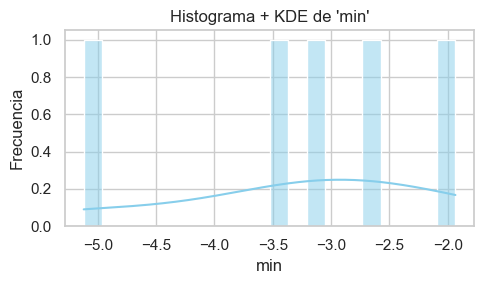

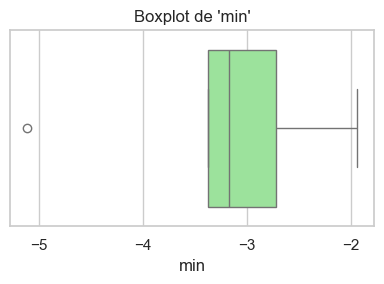


--- Análisis de la variable numérica 'max' ---
Media: 2.696000
Mediana: 2.420000
Moda(s): [1.435, 1.975, 2.42, 2.535, 5.115]
Desviación estándar: 1.269931
Rango intercuartílico (IQR): 0.560000
Rango (max−min): 3.680000
Coeficiente de variación: 0.471043
Asimetría (skew): 1.147413
Curtosis: -0.151274
Percentiles 1-99%: {0.01: 1.4566000000000001, 0.05: 1.5430000000000001, 0.25: 1.975, 0.75: 2.535, 0.95: 4.599, 0.99: 5.0118}
Número de outliers (regla IQR): 1 (20.00 %)


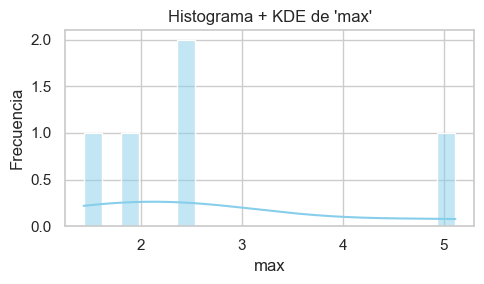

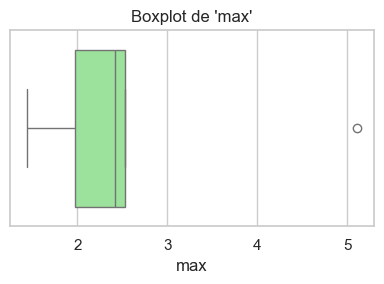


--- Análisis de la variable numérica 'mean' ---
Media: -0.143084
Mediana: -0.116636
Moda(s): [-0.24866670384615383, -0.18116819615384613, -0.11663550384615384, -0.09220743846153848, -0.07674042692307692]
Desviación estándar: 0.063699
Rango intercuartílico (IQR): 0.088961
Rango (max−min): 0.171926
Coeficiente de variación: -0.445184
Asimetría (skew): -0.611368
Curtosis: -1.142076
Percentiles 1-99%: {0.01: -0.24596676353846153, 0.05: -0.2351670023076923, 0.25: -0.18116819615384613, 0.75: -0.09220743846153848, 0.95: -0.07983382923076923, 0.99: -0.07735910738461538}
Número de outliers (regla IQR): 0 (0.00 %)


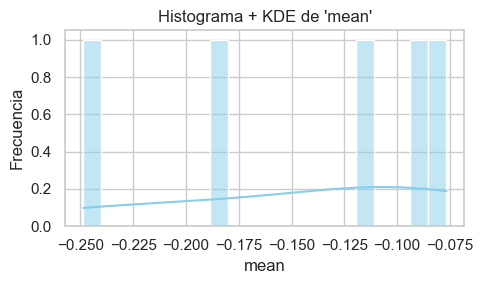

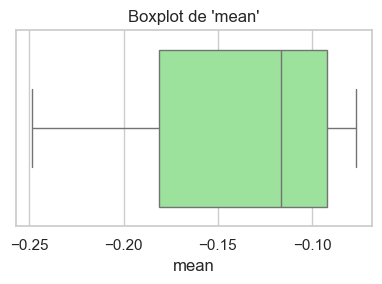


--- Análisis de la variable numérica 'median' ---
Media: -0.150000
Mediana: -0.130000
Moda(s): [-0.27, -0.175, -0.13, -0.12, -0.055]
Desviación estándar: 0.071204
Rango intercuartílico (IQR): 0.055000
Rango (max−min): 0.215000
Coeficiente de variación: -0.474693
Asimetría (skew): -0.471602
Curtosis: -0.742288
Percentiles 1-99%: {0.01: -0.2662, 0.05: -0.251, 0.25: -0.175, 0.75: -0.12, 0.95: -0.068, 0.99: -0.057600000000000005}
Número de outliers (regla IQR): 1 (20.00 %)


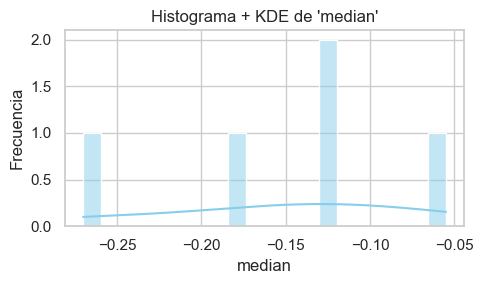

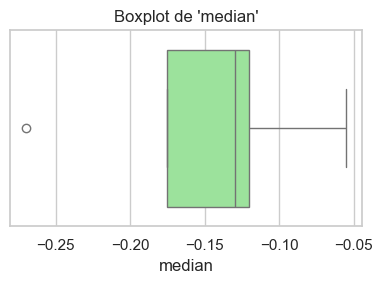


--- Análisis de la variable numérica 'std' ---
Media: 0.410346
Mediana: 0.271685
Moda(s): [0.18157117166295547, 0.21434163005687543, 0.27168531621848985, 0.5542854743375406, 0.8298466685248455]
Desviación estándar: 0.247662
Rango intercuartílico (IQR): 0.339944
Rango (max−min): 0.648275
Coeficiente de variación: 0.603544
Asimetría (skew): 0.719344
Curtosis: -1.087086
Percentiles 1-99%: {0.01: 0.18288198999871227, 0.05: 0.18812526334173946, 0.25: 0.21434163005687543, 0.75: 0.5542854743375406, 0.95: 0.7747344296873845, 0.99: 0.8188242207573533}
Número de outliers (regla IQR): 0 (0.00 %)


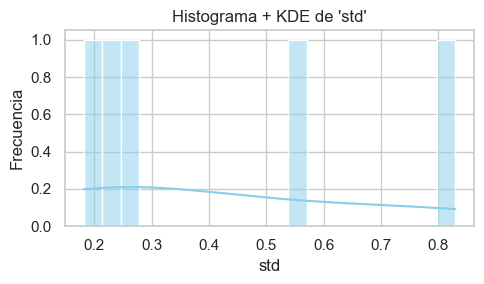

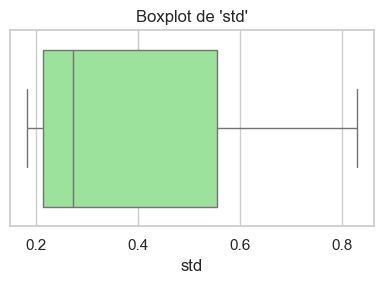

In [10]:
# —— 1.2.b) Para variables numéricas:
import scipy.stats as scistats

# Elegir las columnas numéricas del DataFrame df_stats (Comparativa entre registros)
numeric_cols = [c for c in df_stats.columns if c not in ("record", "fs")]

def detect_outliers_iqr(series: pd.Series) -> pd.Series:
    """Devuelve un boolean mask (True = outlier) aplicado a la serie, usando regla IQR."""
    q1 = series.quantile(0.25)
    q3 = series.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5 * iqr
    upper = q3 + 1.5 * iqr
    return (series < lower) | (series > upper)

for col in numeric_cols:
    series = df_stats[col].dropna()
    if series.empty:
        continue

    print(f"\n--- Análisis de la variable numérica '{col}' ---")
    # Tendencia central y dispersión
    mean = series.mean()
    median = series.median()
    mode = series.mode().tolist()  # puede haber múltiples valores de moda
    std = series.std(ddof=0)
    iqr = series.quantile(0.75) - series.quantile(0.25)
    data_range = series.max() - series.min()
    cv = std / mean if mean != 0 else np.nan
    skewness = scistats.skew(series)
    kurtosis = scistats.kurtosis(series)

    print(f"Media: {mean:.6f}")
    print(f"Mediana: {median:.6f}")
    print(f"Moda(s): {mode}")
    print(f"Desviación estándar: {std:.6f}")
    print(f"Rango intercuartílico (IQR): {iqr:.6f}")
    print(f"Rango (max−min): {data_range:.6f}")
    print(f"Coeficiente de variación: {cv:.6f}")
    print(f"Asimetría (skew): {skewness:.6f}")
    print(f"Curtosis: {kurtosis:.6f}")

    # Percentiles relevantes
    percentiles = series.quantile([0.01, 0.05, 0.25, 0.75, 0.95, 0.99])
    print("Percentiles 1-99%:", percentiles.to_dict())

    # Identificar y contar cuantos valores son outliers por IQR
    mask_out = detect_outliers_iqr(series)
    n_out = mask_out.sum()
    pct_out = n_out / len(series) * 100
    print(f"Número de outliers (regla IQR): {n_out} ({pct_out:.2f} %)")

    # Visualizaciones
    # Histograma con densidad (KDE)
    plt.figure(figsize=(5, 3))
    sns.histplot(series, kde=True, bins=20, color="skyblue")
    plt.title(f"Histograma + KDE de '{col}'")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")
    plt.tight_layout()
    plt.show()

    # Boxplot con identificación visual de outliers
    plt.figure(figsize=(4, 3))
    sns.boxplot(x=series, color="lightgreen")
    plt.title(f"Boxplot de '{col}'")
    plt.tight_layout()
    plt.show()

## Resultados: análisis univariado de variables numéricas (df_stats)

### Variable `min`
- Media ≈ –3.26, mediana –3.18.  
- Rango entre –5.12 y –1.93 (amplitud ≈ 3.18).  
- Asimetría negativa (–0.67), distribución algo sesgada hacia valores bajos.  
- Curtosis negativa (–0.53), colas más ligeras que una normal.  
- Se detectaron **outliers (20%)** en el extremo inferior.  
- Histograma y boxplot confirman la presencia de valores atípicos.  

### Variable `max`
- Media ≈ 2.70, mediana 2.42.  
- Rango entre 1.43 y 5.12 (amplitud ≈ 3.68).  
- Asimetría positiva (1.15), con sesgo hacia valores altos.  
- Curtosis negativa (–0.15).  
- Se detectaron **outliers (20%)** en el extremo superior.  
- Distribución más dispersa que `min`, con varios registros alcanzando valores altos.  

### Variable `median`
- Media ≈ –0.15, mediana –0.13.  
- Rango entre –0.27 y –0.06 (amplitud ≈ 0.21).  
- Distribución centrada, con ligera asimetría negativa (–0.47).  
- Curtosis negativa (–0.72).  
- 1 valor outlier detectado (~20%).  
- Histograma estrecho alrededor de la media, con pocos extremos.  

### Variable `std`
- Media ≈ 0.41, mediana 0.27.  
- Rango entre 0.18 y 0.83.  
- Asimetría positiva (0.72), con mayor peso en valores bajos.  
- Curtosis negativa (–1.09).  
- **No se detectaron outliers**.  
- Distribución relativamente compacta, con variabilidad moderada entre registros.  

---

### Conclusiones
- Las variables muestran **asimetrías opuestas**:  
  - `min` sesgo negativo.  
  - `max` sesgo positivo.  
- La mayoría de los registros están dentro de un rango estable, pero hay **outliers significativos en extremos** (especialmente en `min` y `max`).  
- `median` y `std` presentan distribuciones más concentradas, con menor impacto de valores atípicos.  
- Estos hallazgos sugieren que puede ser necesario aplicar técnicas de **escalado robusto** o tratamiento de outliers (winsorizing, filtros) antes de entrenar modelos.  


,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s
count,112572.000000,112572.000000,112572.000000,112572.000000,112572.000000,112572.000000,1.125720e+05
mean,1.149987,-0.920827,-0.320382,0.360788,70.758651,0.253253,5.555556e-01
std,0.625964,0.562260,0.299434,0.176979,86.408917,0.149637,1.110228e-16
min,-4.840000,-5.120000,-5.105275,0.010012,0.143100,0.011924,5.555556e-01
25%,0.765000,-1.220000,-0.449775,0.231148,21.219225,0.145819,5.555556e-01
50%,1.165000,-0.785000,-0.234575,0.322811,37.562088,0.200323,5.555556e-01
75%,1.570000,-0.500000,-0.134769,0.444414,95.545369,0.339946,5.555556e-01
max,5.115000,4.645000,5.059375,2.094723,5214.409925,2.822042,5.555556e-01


amplitude_peak                                            \
                        n median     p25    p75      mean       std   
class_AAMI                                                            
F                     802  2.170  1.9400  2.520  2.136297  0.558802   
N                   90603  1.195  0.7850  1.565  1.154026  0.612445   
Q                   11151  0.935  0.7650  1.555  1.095698  0.667780   
S                    2781  0.695  0.5050  1.035  0.800876  0.423698   
V                    7235  1.155  0.7025  1.640  1.207941  0.667788   

           amplitude_min                                              \
                       n  median      p25    p75      mean       std   
class_AAMI                                                             
F                    802 -0.8175 -1.11375 -0.565 -0.860193  0.388037   
N                  90603 -0.7450 -1.15500 -0.485 -0.855594  0.487003   
Q                  11151 -0.8200 -1.93000 -0.510 -1.175986  0.819612   
S                   2781 -0.5950 -0.76000 -0.475 -0.710922  0.416634   
V                   7235 -1.3050 -2.02750 -0.870 -1.431876  0.630931   

           mean_voltage                                                    \
                      n    median       p25       p75      mean       std   
class_AAMI                                                                  
F                   802 -0.175463 -0.290519 -0.090937 -0.196291  0.205135   
N                 90603 -0.236300 -0.505850 -0.135050 -0.334944  0.310516   
Q                 11151 -0.262625 -0.351825 -0.181950 -0.280901  0.231128   
S                  2781 -0.180350 -0.256575 -0.103475 -0.216062  0.213396   
V                  7235 -0.189475 -0.330350 -0.105825 -0.252724  0.260007   

           std_voltage                                                    \
                     n    median       p25       p75      mean       std   
class_AAMI                                                                 
F                  802  0.591027  0.484159  0.685488  0.599590  0.185326   
N                90603  0.316237  0.234561  0.411393  0.334135  0.127964   
Q                11151  0.282330  0.210984  0.631459  0.420543  0.272762   
S                 2781  0.184581  0.159186  0.267551  0.227766  0.103133   
V                 7235  0.603492  0.469201  0.752290  0.627121  0.247562   

           energy                                                            \
                n     median        p25         p75        mean         std   
class_AAMI                                                                    
F             802  79.971325  57.404512  119.112081   94.873784   58.072649   
N           90603  36.015875  21.046050   89.498200   67.325484   83.825056   
Q           11151  33.177525  20.927138  110.518587   76.713845   93.500841   
S            2781  15.284775   9.902825   26.124075   30.942864   54.149981   
V            7235  85.692775  58.371100  132.003150  117.204580  100.871995   

             area                                                    \
                n    median       p25       p75      mean       std   
class_AAMI                                                            
F             802  0.267819  0.216469  0.329873  0.280372  0.099004   
N           90603  0.196090  0.143097  0.344427  0.251614  0.151076   
Q           11151  0.197403  0.158122  0.308799  0.245844  0.134148   
S            2781  0.131375  0.098743  0.169368  0.159718  0.111922   
V            7235  0.289931  0.225385  0.363438  0.318141  0.145497   

           duration_s                                               
                    n    median       p25       p75      mean  std  
class_AAMI                                                          
F                 802  0.555556  0.555556  0.555556  0.555556  0.0  
N               90603  0.555556  0.555556  0.555556  0.555556  0.0  
Q               11151  0.555556  0.555556  0.555556  0.555556  0.0  
S                2781  

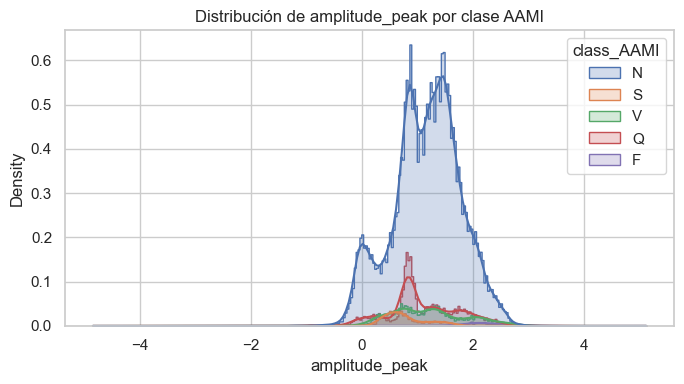

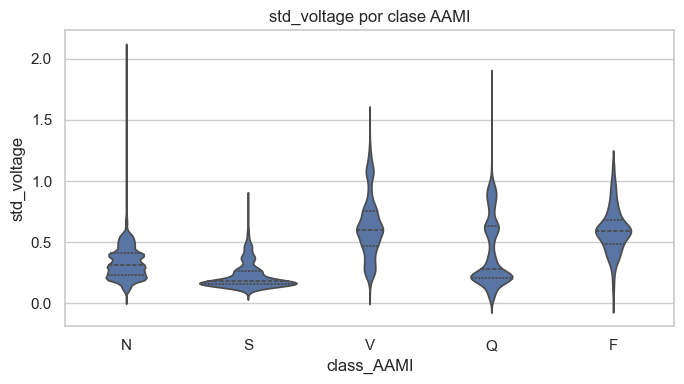

{'amplitude_peak': {'n_outliers': 578, 'pct': np.float64(0.5134491703087801)},
 'amplitude_min': {'n_outliers': 2765, 'pct': np.float64(2.4562058060618983)},
 'mean_voltage': {'n_outliers': 4753, 'pct': np.float64(4.222186689407668)},
 'std_voltage': {'n_outliers': 4020, 'pct': np.float64(3.5710478627012043)},
 'energy': {'n_outliers': 6351, 'pct': np.float64(5.64172263084959)},
 'area': {'n_outliers': 1500, 'pct': np.float64(1.3324805457840316)},
 'duration_s': {'n_outliers': 0, 'pct': np.float64(0.0)}}

In [11]:
# Univariado con df_beats (global y por clase)

# Definir columnas numéricas de df_beats
feat_cols = ["amplitude_peak","amplitude_min","mean_voltage","std_voltage","energy","area","duration_s"]


# Resumen global
display(df_beats[feat_cols].describe())

# Resumen global por clase AAMI (medianas y IQR son bastante utiles)
summary_by_class = df_beats.groupby("class_AAMI")[feat_cols].agg([
    ("n", "count"),
    ("median", "median"),
    ("p25", lambda x: np.percentile(x, 25)),
    ("p75", lambda x: np.percentile(x, 75)),
    ("mean", "mean"),
    ("std", "std")
])

display(summary_by_class)

# Histograma por clase (ejemplo con amplitude_peak)
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
sns.histplot(data=df_beats, x="amplitude_peak", hue="class_AAMI", kde=True, element="step", stat="density")
plt.title("Distribución de amplitude_peak por clase AAMI")
plt.tight_layout(); plt.show()

# Box/violin por clase (ejemplo con std_voltage)
plt.figure(figsize=(7,4))
sns.violinplot(data=df_beats, x="class_AAMI", y="std_voltage", inner="quartile")
plt.title("std_voltage por clase AAMI")
plt.tight_layout(); plt.show()

# Detección de outliers por feature (IQR) en df_beats
def mask_outliers_iqr(s: pd.Series):
    q1, q3 = s.quantile(0.25), s.quantile(0.75)
    iqr = q3 - q1
    return (s < q1 - 1.5*iqr) | (s > q3 + 1.5*iqr)

out_report = {}
for c in feat_cols:
    m = mask_outliers_iqr(df_beats[c].dropna())
    out_report[c] = {"n_outliers": int(m.sum()), "pct": 100*m.mean()}
out_report


## Resultados: análisis univariado con `df_beats` (global y por clase AAMI)

### Resumen global de características
- Dataset: 112,572 latidos con 7 variables numéricas.  
- Valores medios:
  - `amplitude_peak`: 1.15 (±0.63), rango –4.84 a 5.11.  
  - `amplitude_min`: –0.92 (±0.56), rango –5.12 a 4.64.  
  - `mean_voltage`: –0.32 (±0.30).  
  - `std_voltage`: 0.36 (±0.18), con registros más variables llegando a >2.  
  - `energy`: 70.8 (±86), con outliers de alta energía.  
  - `area`: 0.25 (±0.15).  
  - `duration_s`: constante ≈0.556 s (por ventana fija).  

### Resumen por clase AAMI
- **N (Normales)**: amplitud media ≈1.15, std_voltage ≈0.33, energía ≈67.3.  
- **S (Supraventriculares)**: menor amplitud (mediana 0.70) y energía baja (≈31).  
- **V (Ventriculares)**: amplitud elevada (mediana 1.15), gran variabilidad en std_voltage (≈0.63) y energía alta (≈117).  
- **F (Fusión)**: amplitud alta (≈2.17), energía ≈95.  
- **Q (Otros)**: amplitud más dispersa, con gran variabilidad en energía (≈76).  

### Visualizaciones
- **Distribución de `amplitude_peak`**:  
  - Clase N domina en la zona [0.5 – 2 mV].  
  - Latidos V y F muestran colas hacia valores más altos.  
  - S tiende a amplitudes más bajas.  

- **Distribución de `std_voltage` (violinplots)**:  
  - N concentrada en valores bajos (≈0.3).  
  - V con mayor dispersión (hasta >1.5).  
  - Q y F muestran colas largas, indicando alta variabilidad.  

### Outliers detectados (regla IQR)
- `energy`: 6,351 outliers (5.6%).  
- `std_voltage`: 4,020 (3.6%).  
- `mean_voltage`: 4,753 (4.2%).  
- `amplitude_min`: 2,765 (2.5%).  
- `amplitude_peak`: 578 (0.5%).  
- `area`: 1,500 (1.3%).  
- `duration_s`: 0 (ninguno, constante por diseño).  

### Conclusiones
- La mayoría de variables presentan **valores extremos** (especialmente `energy`, `std_voltage` y `mean_voltage`).  
- Las clases muestran **patrones morfológicos diferenciables**:  
  - N: amplitud y variabilidad moderada.  
  - V: mayor variabilidad y energía.  
  - S: amplitud más baja.  
  - F y Q: distribuciones más dispersas.  
- El **desbalance de clases** se refleja también en la densidad de distribuciones: la clase N domina todos los gráficos.  
- Es recomendable aplicar **escalado robusto y control de outliers** en el preprocesamiento, para evitar que las clases minoritarias queden enmascaradas.  



*** Análisis univariado de la señal (fragmento, canal 0) ***
Media: -0.311885
Mediana: -0.34
Desviación estándar: 0.18335536797695878
Asimetría: 4.57135388535085
Curtosis: 24.336573911203345
Percentiles 1-99%: {0.01: -0.52005, 0.05: -0.44025, 0.25: -0.39, 0.75: -0.295, 0.95: -0.14975000000000022, 0.99: 0.7700999999999999}
Número de outliers en fragmento (IQR): 59


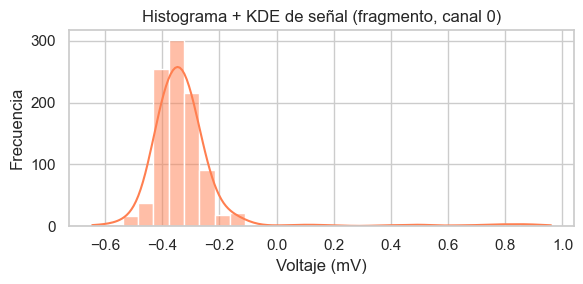

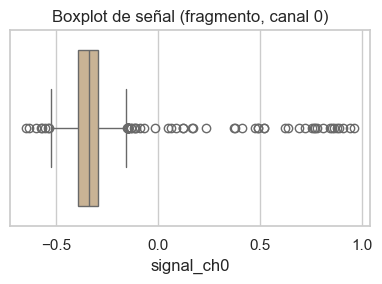

In [12]:
# —— 1.2.c) Análisis univariado de la señal fragmentada (canal 0)

series_ch0 = df_signal0["signal_ch0"].dropna()
print("\n*** Análisis univariado de la señal (fragmento, canal 0) ***")
print("Media:", series_ch0.mean())
print("Mediana:", series_ch0.median())
print("Desviación estándar:", series_ch0.std())
print("Asimetría:", scistats.skew(series_ch0))
print("Curtosis:", scistats.kurtosis(series_ch0))

pcts = series_ch0.quantile([0.01, 0.05, 0.25, 0.75, 0.95, 0.99])
print("Percentiles 1-99%:", pcts.to_dict())

# Detección de outliers en la señal fragmentada con regla IQR
mask_out_ch0 = detect_outliers_iqr(series_ch0)
print("Número de outliers en fragmento (IQR):", mask_out_ch0.sum())

# Visualización del histograma + densidad
plt.figure(figsize=(6, 3))
sns.histplot(series_ch0, kde=True, bins=30, color="coral")
plt.title("Histograma + KDE de señal (fragmento, canal 0)")
plt.xlabel("Voltaje (mV)")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# Boxplot del fragmento
plt.figure(figsize=(4, 3))
sns.boxplot(x=series_ch0, color="tan")
plt.title("Boxplot de señal (fragmento, canal 0)")
plt.tight_layout()
plt.show()

## Resultados: análisis univariado de la señal fragmentada (canal 0)

- **Estadísticos básicos**:  
  - Media ≈ –0.31 mV  
  - Mediana ≈ –0.34 mV  
  - Desviación estándar ≈ 0.18 mV  
  - Asimetría (skew) = 4.57 → distribución muy sesgada a la derecha.  
  - Curtosis = 24.3 → colas muy pesadas, con presencia de valores extremos.  

- **Percentiles (1–99%)**:  
  - 1%: –0.52 mV  
  - 25%: –0.39 mV  
  - 50%: –0.34 mV  
  - 75%: –0.29 mV  
  - 99%: 0.77 mV  

- **Outliers detectados (regla IQR)**: 59 puntos atípicos en el fragmento.  

- **Visualización**:  
  - El **histograma + KDE** muestra que la mayoría de valores se concentran cerca de –0.3 mV.  
  - El **boxplot** confirma la existencia de varios valores atípicos por encima de 0, correspondientes a picos de la señal.  

### Conclusiones
- La señal fragmentada presenta una distribución centrada en valores negativos (≈ –0.3 mV).  
- Existen **outliers positivos marcados**, asociados a picos de voltaje.  
- La alta asimetría y curtosis indican que no se trata de una distribución normal.  
- Se recomienda aplicar **escalado robusto** o técnicas de manejo de outliers en el preprocesamiento para evitar que estos extremos distorsionen las métricas.  

## 1.3: Análisis Bivariado

En esta sección se estudian las **relaciones entre pares de variables** de `df_beats` (latidos MIT-BIH con sus características extraídas), con el fin de entender dependencias, redundancias y diferencias entre clases AAMI.

---

### 1) Matriz de correlación (Spearman)
- Calcula correlaciones no paramétricas entre todas las características numéricas.  
- Se visualiza con un **heatmap**.  
- Útil para:
  - Detectar **variables redundantes**.  
  - Identificar **grupos de features** con información similar.  

---

### 2) Diagramas de dispersión
- Ejemplo: `amplitude_peak` vs `energy`, coloreado por clase AAMI.  
- Permite:
  - Evaluar la **separabilidad visual** entre clases.  
  - Explorar relaciones no lineales, solapamientos y posibles agrupamientos.  

---

### 3) Boxplots por clase AAMI
- Para cada variable numérica, compara la distribución entre clases.  
- Permite:
  - Observar **diferencias de escala y dispersión** entre clases.  
  - Identificar variables con **potencial discriminativo** (ej. `energy`, `amplitude_min`).  
  - Revisar presencia de **outliers intra-clase**.  

---

### 4) Pruebas estadísticas (ANOVA / Kruskal-Wallis)
- Se aplica ANOVA cuando se cumplen supuestos; en caso contrario, Kruskal-Wallis.  
- Para cada variable se reporta estadístico y p-valor.  
- Objetivo: comprobar si hay **diferencias significativas entre clases** que respalden la selección de variables.  

---

### 5) Correlación con la clase (Spearman)
- Codifica las clases AAMI como enteros (`class_code`).  
- Calcula la correlación de Spearman con cada variable numérica.  
- Sirve para priorizar **features con mayor asociación directa a la clase objetivo**.  

---

### Conclusiones
- El análisis bivariado permite detectar **relaciones fuertes entre variables** y reducir redundancia.  
- Los gráficos ayudan a visualizar la **separabilidad entre clases** en ciertos ejes de características.  
- La evidencia estadística respalda la **selección de variables relevantes** y motiva, si es necesario, el uso de **PCA o regularización** en etapas posteriores de modelado.  


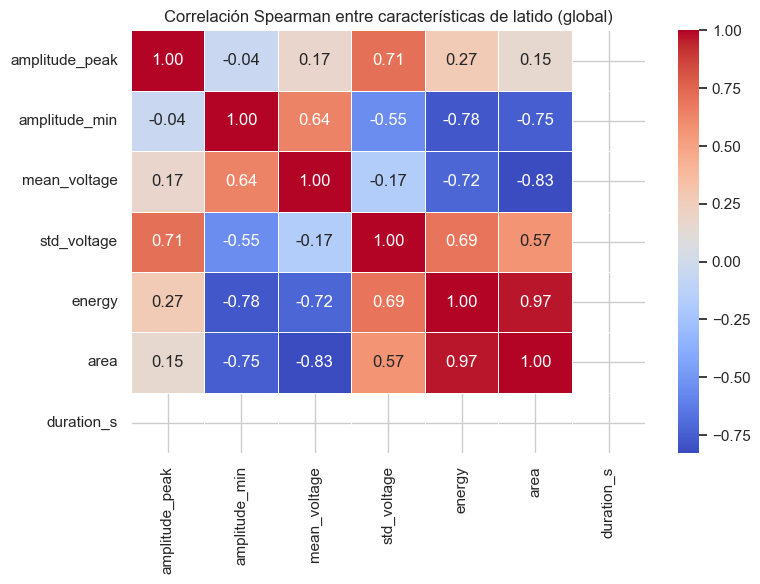

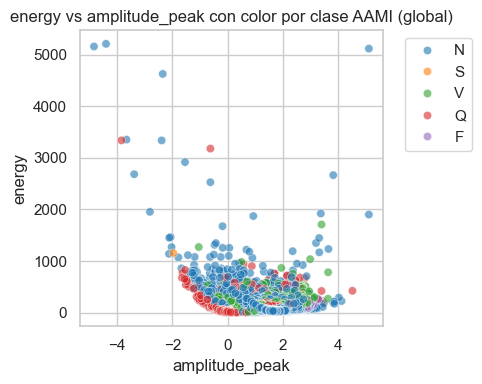

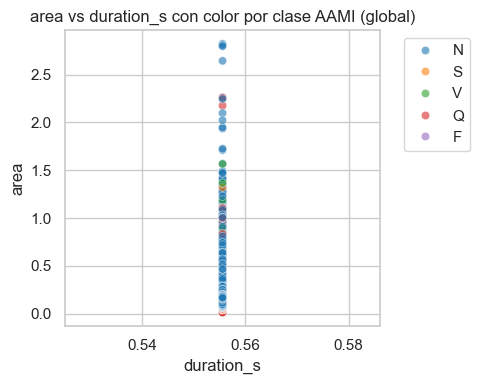

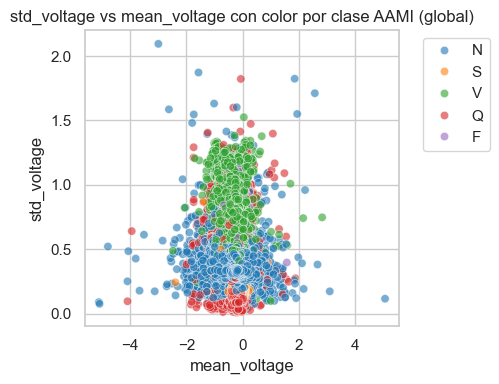

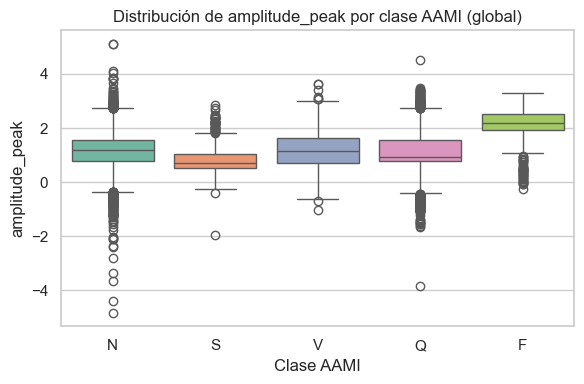

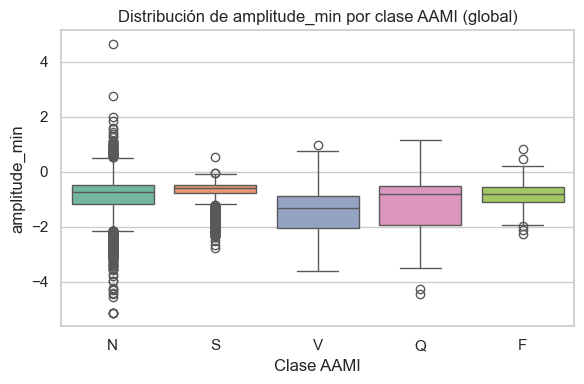

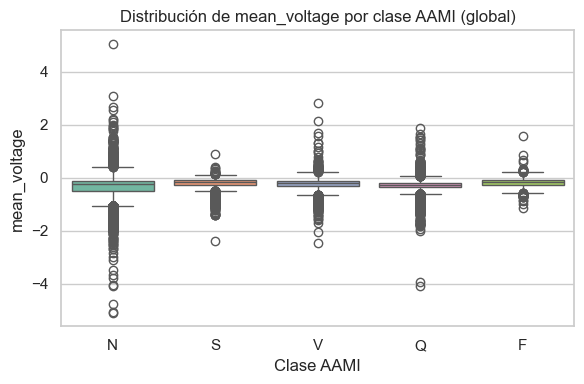

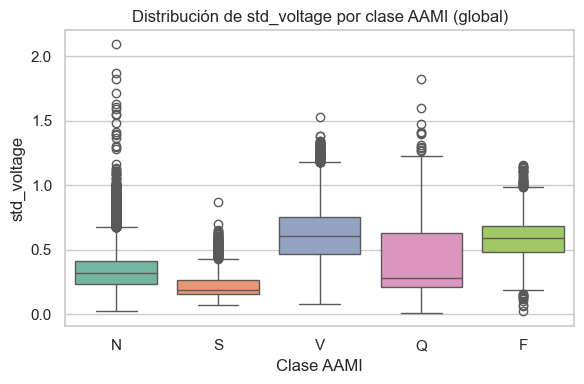

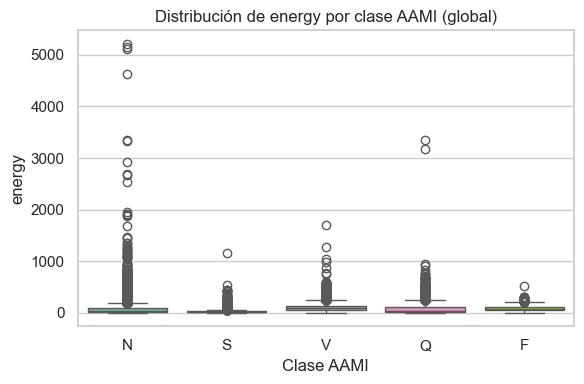

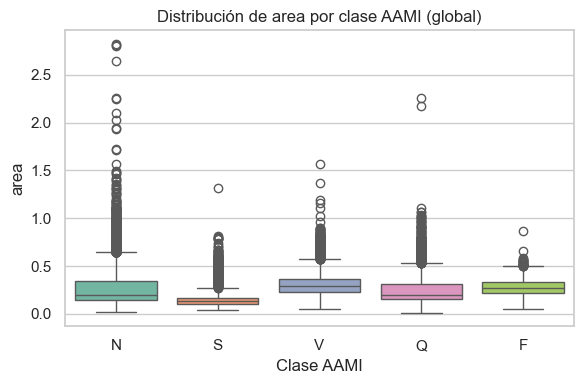

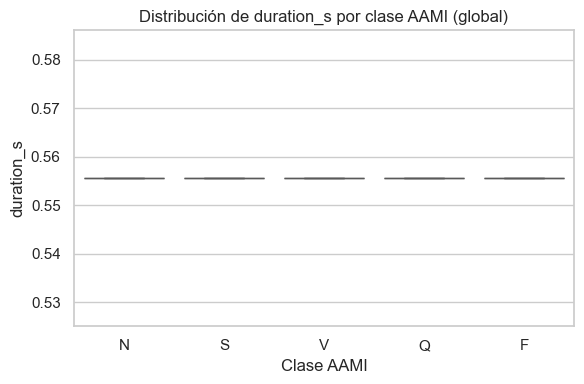

amplitude_peak: ANOVA → estadístico = 772.0474, p = 0.0000e+00
amplitude_min: ANOVA → estadístico = 2710.5479, p = 0.0000e+00
mean_voltage: ANOVA → estadístico = 316.7161, p = 1.7296e-271
std_voltage: ANOVA → estadístico = 7124.8191, p = 0.0000e+00
energy: ANOVA → estadístico = 754.4889, p = 0.0000e+00
area: ANOVA → estadístico = 642.2095, p = 0.0000e+00
duration_s: todos los grupos son constantes → test no aplicable
Spearman corr entre amplitude_peak y clase codificada: corr = -0.0832, p = 3.3393e-172
Spearman corr entre amplitude_min y clase codificada: corr = -0.1732, p = 0.0000e+00
Spearman corr entre mean_voltage y clase codificada: corr = 0.0530, p = 6.4822e-71
Spearman corr entre std_voltage y clase codificada: corr = 0.1335, p = 0.0000e+00
Spearman corr entre energy y clase codificada: corr = 0.0582, p = 6.3744e-85
Spearman corr entre area y clase codificada: corr = 0.0455, p = 1.2382e-52
duration_s: valores constantes → Spearman no aplicable


In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import f_oneway, kruskal, spearmanr
from sklearn.preprocessing import LabelEncoder

# Selección de columnas numéricas (excluimos categóricas/IDs)
num_cols = [
    c for c in df_beats.columns
    if c not in ("sample", "symbol", "class_AAMI", "class_code", "record")
]

# 1) Matriz de correlación (Spearman)
corr = df_beats[num_cols].corr(method="spearman")
plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlación Spearman entre características de latido (global)")
plt.tight_layout()
plt.show()

# 2) Scatter plots coloreados por clase AAMI
pairs = [
    ("amplitude_peak", "energy"),
    ("duration_s", "area"),
    ("mean_voltage", "std_voltage")
]
for x, y in pairs:
    if x in df_beats.columns and y in df_beats.columns:
        plt.figure(figsize=(5, 4))
        sns.scatterplot(
            data=df_beats, x=x, y=y,
            hue="class_AAMI", palette="tab10", alpha=0.6
        )
        plt.title(f"{y} vs {x} con color por clase AAMI (global)")
        plt.xlabel(x)
        plt.ylabel(y)
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
        plt.tight_layout()
        plt.show()

# 3) Box plots: variable categórica (clase AAMI) vs numéricas
for num in num_cols:
    plt.figure(figsize=(6, 4))
    sns.boxplot(
        x="class_AAMI", y=num, data=df_beats,
        hue="class_AAMI", palette="Set2", legend=False
    )
    plt.title(f"Distribución de {num} por clase AAMI (global)")
    plt.xlabel("Clase AAMI")
    plt.ylabel(num)
    plt.tight_layout()
    plt.show()

# 4) Pruebas estadísticas (ANOVA / Kruskal-Wallis)
def test_by_class(df, feature, class_col="class_AAMI"):
    groups = [group[feature].dropna().values for _, group in df.groupby(class_col)]
    valid_groups = [g for g in groups if len(np.unique(g)) > 1]  # evitar grupos constantes
    if len(valid_groups) < 2:
        print(f"{feature}: todos los grupos son constantes → test no aplicable")
        return
    try:
        stat, p = f_oneway(*valid_groups)
        test_name = "ANOVA"
    except Exception:
        stat, p = kruskal(*valid_groups)
        test_name = "Kruskal-Wallis"
    print(f"{feature}: {test_name} → estadístico = {stat:.4f}, p = {p:.4e}")

for num in num_cols:
    test_by_class(df_beats, num, "class_AAMI")

# 5) Correlación Spearman: características numéricas vs clase codificada
le = LabelEncoder()
df_beats["class_code"] = le.fit_transform(df_beats["class_AAMI"])

for num in num_cols:
    x = df_beats[num].dropna()
    y = df_beats["class_code"].loc[df_beats[num].notna()]
    if len(np.unique(x)) < 2 or len(np.unique(y)) < 2:
        print(f"{num}: valores constantes → Spearman no aplicable")
        continue
    corr, p = spearmanr(x, y)
    print(f"Spearman corr entre {num} y clase codificada: corr = {corr:.4f}, p = {p:.4e}")

## Resultados: análisis bivariado (df_beats)

### 1) Correlación Spearman entre características
- Se observan **altas correlaciones**:
  - `energy` ~ `area` (ρ ≈ 0.97).  
  - `std_voltage` con `amplitude_peak` (ρ ≈ 0.71).  
- Relaciones negativas fuertes:
  - `mean_voltage` con `area` (ρ ≈ –0.83).  
  - `amplitude_min` con `energy` (ρ ≈ –0.78).  
- Implicación: existen **variables redundantes**, lo que sugiere considerar reducción de dimensionalidad o selección de features.

---

### 2) Diagramas de dispersión
- **`energy` vs `amplitude_peak`**: patrón no lineal, con clases solapadas; las instancias de clase V tienden a valores altos de energía.  
- **`std_voltage` vs `mean_voltage`**: distribución más dispersa, algunas clases (V y Q) muestran mayor variabilidad.  
- **`area` vs `duration_s`**: la duración es constante, por lo que no aporta discriminación.

---

### 3) Boxplots por clase AAMI
- Diferencias notorias en:
  - `amplitude_peak`: clases F y V con mayores medianas que N y S.  
  - `amplitude_min`: clase V con valores mínimos más negativos.  
  - `std_voltage`: mayor dispersión en V y Q.  
  - `energy`: significativamente mayor en V y F que en N y S.  
- Confirma que varias características tienen **capacidad discriminativa** entre clases.

---

### 4) Pruebas estadísticas (ANOVA / Kruskal-Wallis)
- Todas las variables (excepto `duration_s`) muestran **diferencias significativas entre clases** (p < 0.0001).  
- Variables con estadísticos más altos: `std_voltage`, `amplitude_min`, `energy`.  
- Implicación: estas variables son **fuertemente asociadas con la clase**.

---

### 5) Correlación Spearman con la clase codificada
- Correlaciones significativas pero **moderadas/bajas**:
  - `amplitude_min` (ρ ≈ –0.17).  
  - `mean_voltage` (ρ ≈ –0.05).  
  - `std_voltage` (ρ ≈ 0.13).  
  - `energy` (ρ ≈ 0.06).  
  - `area` (ρ ≈ 0.05).  
- Aunque el efecto individual es bajo, combinadas pueden aportar al modelo.  

---

### Conclusiones
- Existe **alta redundancia** entre algunas variables (`energy` y `area`), lo que sugiere eliminar o combinar features.  
- Varias variables (`amplitude_min`, `std_voltage`, `energy`) muestran diferencias claras entre clases y son candidatas para clasificación.  
- La duración (`duration_s`) es constante y no aporta información.  
- El análisis confirma la **relevancia estadística** de las variables, pero también la necesidad de técnicas multivariadas (PCA, regularización o modelos no lineales) para capturar relaciones complejas y no lineales entre características y clases.  


## 1.4: Análisis Multivariado

En esta sección se exploran las **relaciones multivariadas** en `df_beats` (latidos globales MIT-BIH), con el objetivo de entender la **estructura del espacio de características**, identificar **redundancias** y evaluar la **separabilidad entre clases AAMI**.

---

### Preparación
- Se seleccionan solo variables numéricas y se aplica **StandardScaler** (media 0, varianza 1).  
- Esto es esencial porque PCA, t-SNE y KMeans son sensibles a la escala.

---

### 1) PCA (Reducción lineal)
- PCA con 3 componentes principales, análisis de varianza explicada.  
- Gráfico PC1 vs PC2 (muestra de 5000 latidos) coloreado por clase AAMI.  
- Útil para detectar **direcciones de mayor varianza** y **reducir dimensionalidad** con mínima pérdida de información.

---

### 2) t-SNE (Proyección no lineal)
- Proyección 2D de un subconjunto (5000 latidos).  
- Visualiza **agrupamientos no lineales** y posibles clusters naturales que PCA no captura.  
- Método exploratorio, dependiente de parámetros como *perplexity*.

---

### 3) KMeans (Clustering no supervisado)
- Entrenado con `k` = número de clases AAMI.  
- Se grafican clusters sobre PCA y se genera **tabla de contingencia cluster vs clase**.  
- Sirve para evaluar la **coherencia estructural** entre clusters y etiquetas reales, aunque con limitaciones (asume clusters esféricos).

---

### 4) PairPlot (Dispersión múltiple)
- Matriz de gráficos de dispersión para 5 variables (5000 latidos).  
- Permite inspección rápida de **relaciones bivariadas múltiples** y detección visual de separaciones y outliers.

---

### 5) Estadísticos por grupos
- Se agrupa por `class_AAMI` y se calculan medias, medianas y desviaciones estándar.  
- Permite observar **diferencias sistemáticas entre clases** y la variabilidad entre registros/pacientes.

---

### 6) Crosstab Cluster vs Clase
- Se construye una tabla `cluster` vs `class_AAMI`.  
- Evalúa si algunos clusters se alinean principalmente con una clase (ej. ventriculares) o si hay mezcla fuerte entre ellas.

Varianza explicada por componentes PCA: [0.59529637 0.26916384 0.07152377]


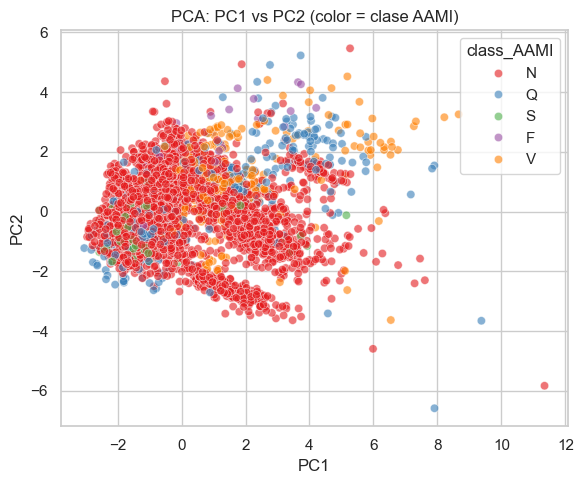

C:\Users\luisa\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


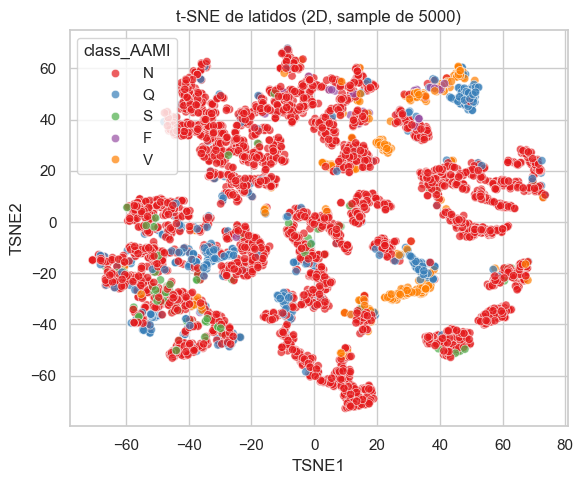

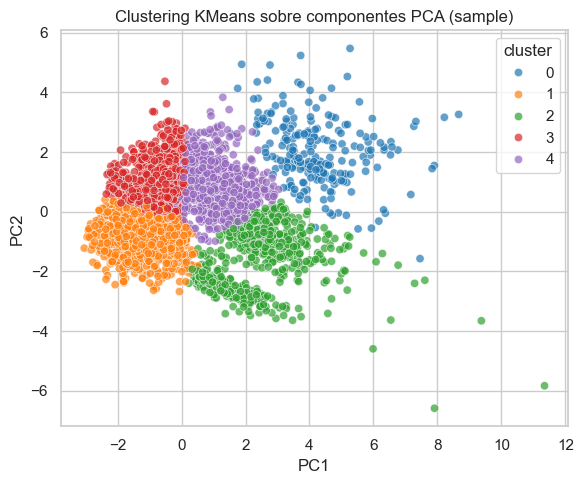

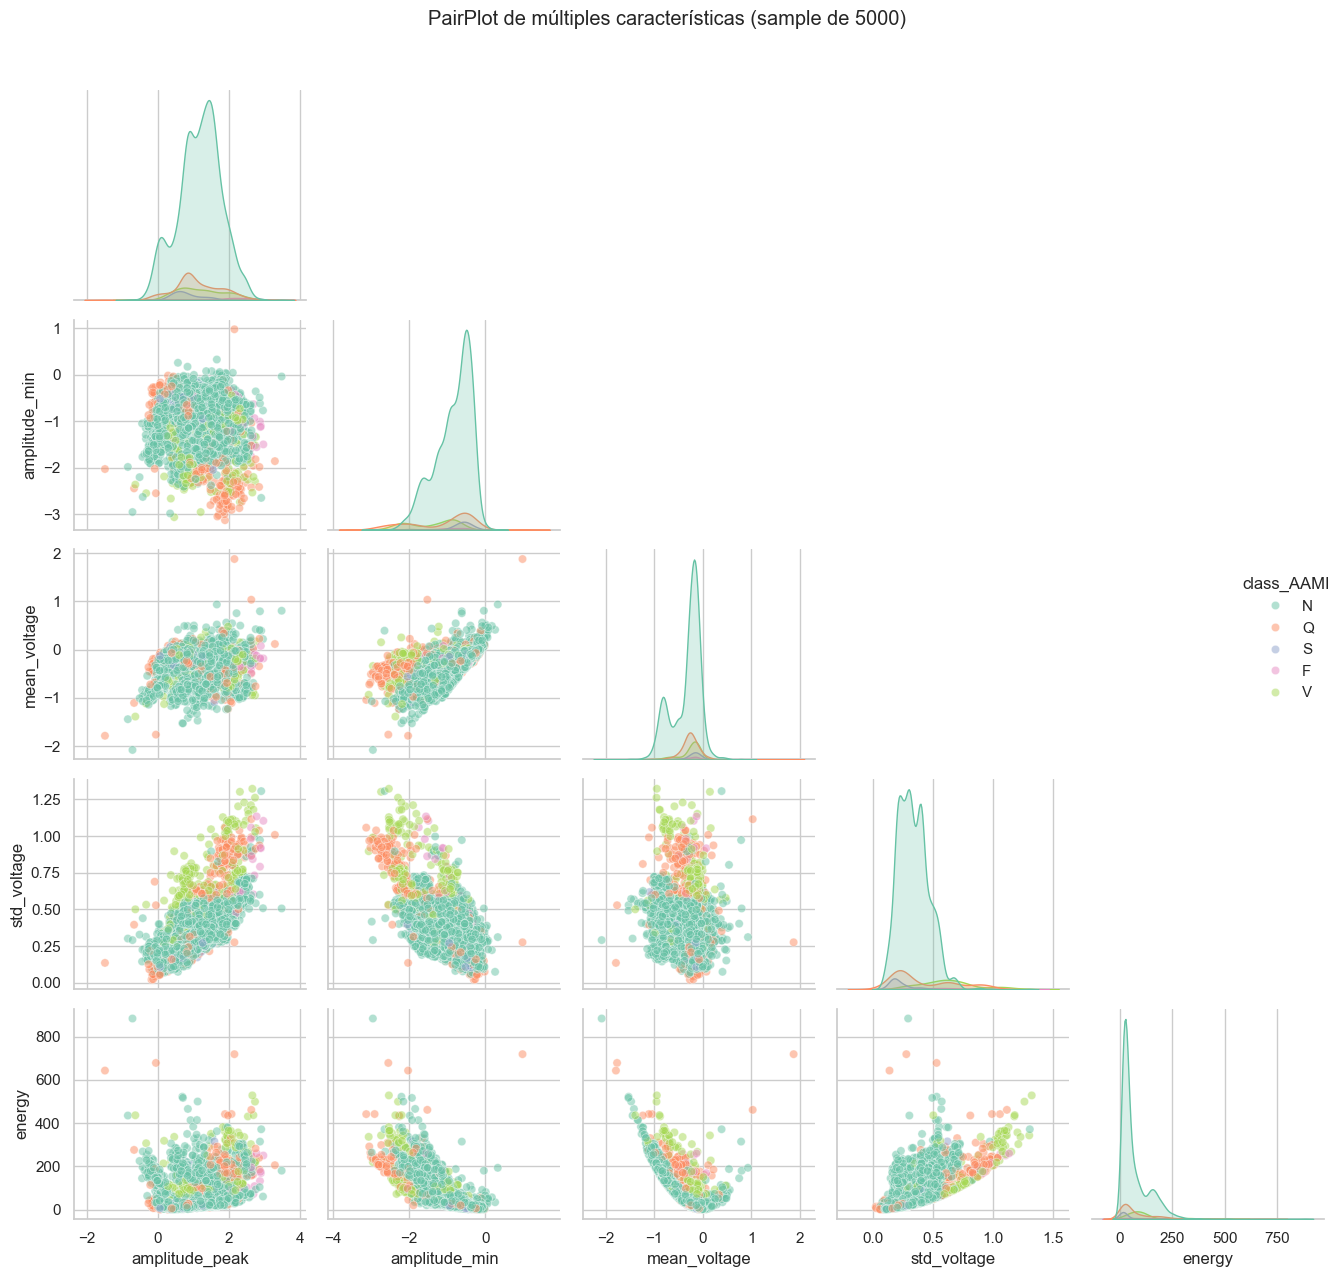


Estadísticas agrupadas por clase AAMI (mean, std, median):


amplitude_peak                  amplitude_min                    \
                     mean       std median          mean       std  median   
class_AAMI                                                                   
F                2.136297  0.558802  2.170     -0.860193  0.388037 -0.8175   
N                1.154026  0.612445  1.195     -0.855594  0.487003 -0.7450   
Q                1.095698  0.667780  0.935     -1.175986  0.819612 -0.8200   
S                0.800876  0.423698  0.695     -0.710922  0.416634 -0.5950   
V                1.207941  0.667788  1.155     -1.431876  0.630931 -1.3050   

           mean_voltage                     std_voltage                      \
                   mean       std    median        mean       std    median   
class_AAMI                                                                    
F             -0.196291  0.205135 -0.175463    0.599590  0.185326  0.591027   
N             -0.334944  0.310516 -0.236300    0.334135  0.127964  0.316237   
Q             -0.280901  0.231128 -0.262625    0.420543  0.272762  0.282330   
S             -0.216062  0.213396 -0.180350    0.227766  0.103133  0.184581   
V             -0.252724  0.260007 -0.189475    0.627121  0.247562  0.603492   

                energy                             area                      \
                  mean         std     median      mean       std    median   
class_AAMI                                                                    
F            94.873784   58.072649  79.971325  0.280372  0.099004  0.267819   
N            67.325484   83.825056  36.015875  0.251614  0.151076  0.196090   
Q            76.713845   93.500841  33.177525  0.245844  0.134148  0.197403   
S            30.942864   54.149981  15.284775  0.159718  0.111922  0.131375   
V           117.204580  100.871995  85.692775  0.318141  0.145497  0.289931   

           duration_s                 
                 mean  std    median  
class_AAMI                            
F            0.555556  0.0  0.555556  
N            0.555556  0.0  0.555556  
Q            0.555556  0.0  0.555556  
S            0.555556  0.0  0.555556  
V            0.555556  0.0  0.555556


Promedios por registro (primeros 5):


,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s
record,,,,,,,
100,0.986576,-0.560315,-0.306020,0.219193,29.050334,0.198641,0.555556
101,1.392431,-0.482898,-0.273936,0.288600,35.893274,0.203942,0.555556
102,0.806718,-0.540979,-0.252941,0.217804,22.920090,0.175277,0.555556
103,1.748191,-0.599517,-0.231151,0.365194,40.497117,0.202279,0.555556
104,0.934242,-0.728237,-0.258488,0.251751,28.588597,0.175808,0.555556



Tabla de contingencia cluster vs clase AAMI:


class_AAMI,F,N,Q,S,V
cluster,,,,,
0,100,1990,1963,5,1318
1,35,31213,5856,2177,1073
2,9,15478,254,127,401
3,328,28952,909,298,848
4,330,12970,2169,174,3595


In [14]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans

# Preparar los datos: características numéricas + escalado
num_cols = [c for c in df_beats.columns if c not in ("sample", "symbol", "class_AAMI", "class_code", "record")]
X = df_beats[num_cols].copy()

# Escalado estándar
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 1) PCA — reducción lineal de dimensionalidad
pca = PCA(n_components=3, random_state=42)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_
print("Varianza explicada por componentes PCA:", explained)

df_pca = df_beats.copy()
df_pca["PC1"] = X_pca[:, 0]
df_pca["PC2"] = X_pca[:, 1]
df_pca["PC3"] = X_pca[:, 2]

# Visualización PCA 2D
plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_pca.sample(5000, random_state=42),  # muestrear para graficar
                x="PC1", y="PC2", hue="class_AAMI", palette="Set1", alpha=0.6)
plt.title("PCA: PC1 vs PC2 (color = clase AAMI)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 2) t-SNE — reducción no lineal (costoso → usar sample)
df_sample = df_beats.sample(n=5000, random_state=42)  # muestreo para rapidez
X_sample = df_sample[num_cols].copy()
X_sample_scaled = scaler.fit_transform(X_sample)

tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=1000)
X_tsne = tsne.fit_transform(X_sample_scaled)

df_sample["TSNE1"] = X_tsne[:, 0]
df_sample["TSNE2"] = X_tsne[:, 1]

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_sample, x="TSNE1", y="TSNE2", hue="class_AAMI", palette="Set1", alpha=0.7)
plt.title("t-SNE de latidos (2D, sample de 5000)")
plt.xlabel("TSNE1")
plt.ylabel("TSNE2")
plt.tight_layout()
plt.show()

# 3) Clustering (KMeans) en todo el dataset
k = df_beats["class_AAMI"].nunique()
kmeans = KMeans(n_clusters=k, random_state=0, n_init=10)
df_pca["cluster"] = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(6, 5))
sns.scatterplot(data=df_pca.sample(5000, random_state=42),
                x="PC1", y="PC2", hue="cluster", palette="tab10", alpha=0.7)
plt.title("Clustering KMeans sobre componentes PCA (sample)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

# 4) PairPlot — solo con sample para velocidad
subset = num_cols[:5]  # elegir 5 características
sns.pairplot(df_sample, vars=subset, hue="class_AAMI",
             diag_kind="kde", corner=True, palette="Set2", plot_kws={"alpha":0.5})
plt.suptitle("PairPlot de múltiples características (sample de 5000)", y=1.02)
plt.tight_layout()
plt.show()

# 5) Estadísticas por grupos
group_stats = df_beats.groupby("class_AAMI")[num_cols].agg(["mean", "std", "median"])
print("\nEstadísticas agrupadas por clase AAMI (mean, std, median):")
display(group_stats)

if "record" in df_beats.columns:
    rec_stats = df_beats.groupby("record")[num_cols].mean()
    print("\nPromedios por registro (primeros 5):")
    display(rec_stats.head())

# 6) Cluster vs Clase
confusion = pd.crosstab(df_pca["cluster"], df_pca["class_AAMI"])
print("\nTabla de contingencia cluster vs clase AAMI:")
display(confusion)


## Resultados: Análisis Multivariado

### 1) PCA (Reducción lineal)
- Las **3 primeras componentes** explican el **93.6% de la varianza** (PC1=59.5%, PC2=26.9%, PC3=7.1%).  
- El gráfico **PC1 vs PC2** muestra cierto solapamiento entre clases, aunque algunas (V y F) tienden a ocupar regiones diferenciadas.  
- Implicación: existe **reducción efectiva de dimensionalidad** → pocas componentes resumen gran parte de la información.

---

### 2) t-SNE (Proyección no lineal)
- La proyección 2D (sample de 5000 latidos) revela **clusters más definidos** que PCA.  
- Sin embargo, las clases aún presentan **mezcla parcial**, especialmente N y Q.  
- Ventaja: captura **patrones no lineales** en los datos, evidenciando subgrupos dentro de la clase N.

---

### 3) KMeans (Clustering no supervisado)
- Con `k=5`, los clusters no coinciden perfectamente con las clases AAMI, pero algunos muestran **alineación parcial**:  
  - Un cluster concentra muchos latidos normales (N).  
  - Otros agrupan mezclas de V, Q y F.  
- Limitación: KMeans asume clusters esféricos → simplificación excesiva para datos fisiológicos.  

---

### 4) PairPlot (5 variables, sample de 5000)
- Confirma correlaciones fuertes ya vistas (`energy ~ area`, `amplitude_min ~ mean_voltage`).  
- Algunas clases (V y F) se distribuyen en regiones extremas de `energy` y `std_voltage`, mostrando **potencial discriminativo**.  
- La clase N domina la densidad central, dificultando separaciones claras.

---

### 5) Estadísticas por clase AAMI
- **Clase N (Normales)**: amplitud moderada (~1.15), baja variabilidad (`std_voltage≈0.33`), energía media (~67).  
- **Clase V (Ventriculares)**: mayor energía (~117), amplitud más extrema, alta dispersión en `std_voltage`.  
- **Clase F (Fusión)**: amplitud muy alta (~2.17), energía elevada (~95).  
- **Clase S (Supraventriculares)**: amplitud menor (~0.80) y energía baja (~31).  
- **Clase Q (Otros)**: valores más heterogéneos, con dispersión elevada en todas las métricas.  

---

### 6) Tabla de contingencia (Clusters vs Clases)
- Ningún cluster coincide perfectamente con una clase, pero hay tendencias:
  - Clusters que agrupan principalmente latidos **N**.  
  - Otros con mezcla de **V y Q**, lo que refleja solapamiento fisiológico.  
- Muestra que el **clustering no supervisado no es suficiente** para separar clases, aunque sí sugiere **estructura latente**.

---

### Conclusiones
- **PCA** → pocas componentes concentran la mayor parte de la varianza → evidencia de redundancia entre features.  
- **t-SNE** → revela subgrupos y patrones no lineales, aunque sin separabilidad perfecta.  
- **KMeans** → clusters parcialmente alineados con clases, confirmando estructura interna pero también fuerte **solapamiento entre arritmias**.  
- **Estadísticas por clase** → diferencias claras: V y F muestran mayor amplitud y energía, S más débiles, Q heterogéneos.  
- Estos hallazgos justifican:
  - Uso de **modelos robustos y no lineales** (CNN, SVM, ensembles).  
  - Aplicar **reducción de dimensionalidad o regularización** para mitigar redundancia.  
  - Considerar **estrategias de balanceo** debido a la dominancia de clase N.  


## 1.5: Identificación de Patrones y Anomalías

En esta sección se buscan **latidos atípicos** y se inspeccionan **patrones temporales** que podrían reflejar ruido, artefactos o eventos clínicos raros que afecten el modelado.

---

### 1) Outliers multivariados — Isolation Forest
- Entrena un **IsolationForest** sobre las variables numéricas de `df_beats`.  
- Genera:
  - `iso_score` ∈ {1, −1} → 1 = normal, −1 = anómalo.  
  - `iso_dist` → score continuo (más bajo = más anómalo).  
- Útil para detectar **observaciones raras** considerando todas las variables a la vez.  
- Supone `contamination=0.01` (~1% anomalías).  

---

### 2) Outliers locales — Local Outlier Factor (LOF)
- Aplica **LOF**, que compara cada punto con sus **vecinos más cercanos**.  
- Genera:
  - `lof_score` ∈ {1, −1} → −1 = outlier local.  
  - `lof_dist` → magnitud de rareza local.  
- Captura anomalías **contextuales** (valores inusuales solo en su vecindario).  
- Se usa en EDA; no está diseñado para predecir sobre nuevos datos.

---

### 3) Distribución de puntajes de anomalía
- Histogramas de `iso_dist` y `lof_dist`.  
- Permiten explorar **umbrales de corte** y ver si ambos métodos coinciden al señalar los mismos latidos atípicos.

---

### 4) Patrones temporales
- Ordena latidos por `sample` y grafica la evolución de métricas (`amplitude_peak`, `energy`, etc.) resaltando anomalías.  
- Detecta:
  - **Cambios súbitos** en amplitud/energía.  
  - **Segmentos con valores extremos** → posibles artefactos o desplazamientos de electrodo.  
- En multi-paciente: ordenar por (`record_id`, `sample_index`) para no mezclar registros.

---

### 5) Detección de inconsistencias
- Reporta:
  - `duration_s ≤ 0` → fragmentos mal recortados.  
  - Valores fuera de percentiles 1%–99% (ej. amplitud o energía).  
- Funciona como **control de calidad** para descartar latidos mal segmentados o con ruido extremo.

---

### Conclusiones
- **Isolation Forest** → robusto para anomalías globales.  
- **LOF** → detecta anomalías locales dependientes del vecindario.  
- El análisis temporal y de inconsistencias ayuda a distinguir entre **ruido técnico** y **eventos clínicos raros**.  
- Esta etapa es clave para mejorar la **calidad del dataset** y evitar que **artefactos contaminen el entrenamiento**.

Cantidad de latidos identificados como anomalía por Isolation Forest: 1126


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist
2378,33467,N,N,2.055,0.675,1.026625,0.228492,221.233525,0.567597,0.555556,101,1,-1,-0.010388
2480,63096,|,Q,0.575,-3.175,-1.737850,1.292381,938.074100,0.968792,0.555556,101,2,-1,-0.091721
2481,63315,N,N,0.895,-2.900,-2.227600,0.589242,1061.881650,1.249361,0.555556,101,1,-1,-0.066478
2482,63414,|,Q,1.320,-2.250,-0.329100,1.599769,533.513400,0.869938,0.555556,101,2,-1,-0.039176
2483,63631,N,N,2.420,0.860,1.145225,0.262522,276.091625,0.633118,0.555556,101,1,-1,-0.028645


Cantidad de latidos identificados como anomalía por LOF: 1126


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist,lof_score,lof_dist
1905,546792,V,V,0.960,-2.715,-0.233100,0.776831,131.560350,0.316007,0.555556,100,4,1,0.048611,-1,3.137962
2293,7463,N,N,0.950,-0.535,-0.356775,0.215124,34.713375,0.221458,0.555556,101,1,1,0.227984,-1,2.740671
2378,33467,N,N,2.055,0.675,1.026625,0.228492,221.233525,0.567597,0.555556,101,1,-1,-0.010388,-1,6.299496
2379,33777,N,N,1.385,0.505,0.767150,0.201073,125.789900,0.423896,0.555556,101,1,1,0.048904,-1,2.703544
2381,34391,N,N,0.665,-0.540,-0.309400,0.216452,28.515950,0.196368,0.555556,101,1,1,0.235472,-1,3.215598


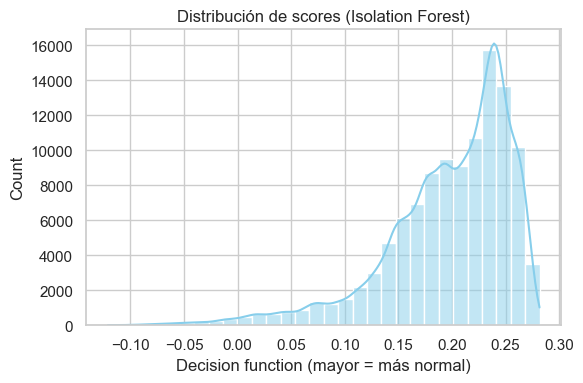

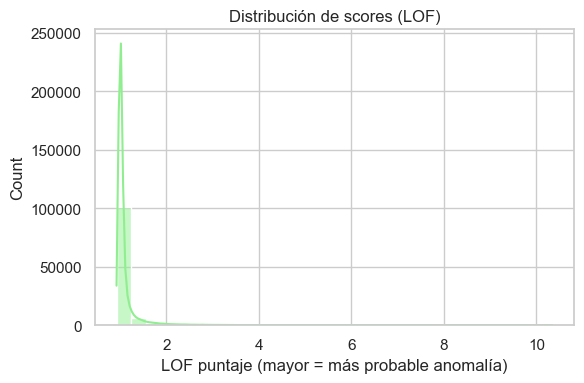

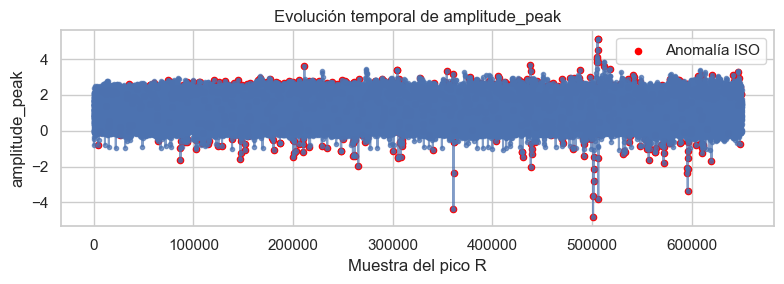

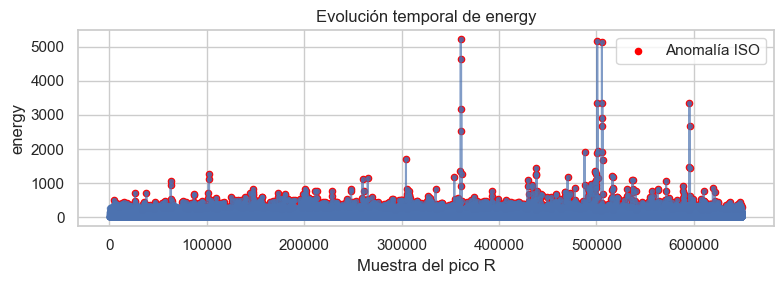

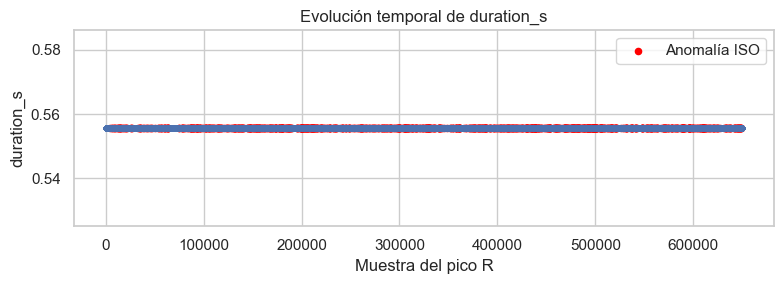

Latidos con duración ≤ 0: 0


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist,lof_score,lof_dist


Latidos extremos en amplitude_peak (más allá de doble cola): 2481


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist,lof_score,lof_dist
2635,114681,|,Q,-0.435,-2.765,-0.957875,0.745901,294.778475,0.530729,0.555556,101,2,1,0.004359,1,1.240385
2636,114705,Q,Q,-0.370,-2.765,-0.949375,0.751154,293.109075,0.526167,0.555556,101,2,1,0.007875,1,1.278377
3177,308294,Q,Q,-0.180,-2.575,-0.936200,0.664041,263.484250,0.519083,0.555556,101,2,1,0.041092,-1,3.252264
4241,29133,+,Q,-0.165,-0.550,-0.279600,0.102455,17.734650,0.154313,0.555556,102,2,1,0.160926,-1,3.672730
4276,38682,+,Q,-0.195,-0.570,-0.322300,0.096229,22.627450,0.178021,0.555556,102,2,1,0.158489,-1,4.139669


Latidos extremos en energy (más allá de doble cola): 282


,sample,symbol,class_AAMI,amplitude_peak,amplitude_min,mean_voltage,std_voltage,energy,area,duration_s,record,class_code,iso_score,iso_dist,lof_score,lof_dist
2480,63096,|,Q,0.575,-3.175,-1.737850,1.292381,938.074100,0.968792,0.555556,101,2,-1,-0.091721,1,1.528430
2481,63315,N,N,0.895,-2.900,-2.227600,0.589242,1061.881650,1.249361,0.555556,101,1,-1,-0.066478,1,1.143131
7600,392477,N,N,0.605,-2.610,-1.819175,0.744387,772.701975,1.016292,0.555556,103,1,-1,-0.066836,1,0.970559
9080,174544,+,Q,0.170,-0.185,0.038575,0.074971,1.421725,0.035569,0.555556,104,2,1,0.065760,1,1.941032
11945,307391,N,N,-0.665,-2.165,-1.797225,0.272049,660.805725,0.993611,0.555556,105,1,-1,-0.058102,1,1.008678


In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1) Outliers multivariados con Isolation Forest

num_cols = [c for c in df_beats.columns if c not in ("sample", "symbol", "class_AAMI", "class_code")]
X = df_beats[num_cols].values

# Isolation Forest
iso = IsolationForest(contamination=0.01, random_state=42)  # suponer 1% anomalías
df_beats["iso_score"] = iso.fit_predict(X)  # -1 = anomalía, 1 = normal
df_beats["iso_dist"] = iso.decision_function(X)  # puntaje de anomalía

# Ver latidos marcados como anomalía
anom_iso = df_beats[df_beats["iso_score"] == -1]
print("Cantidad de latidos identificados como anomalía por Isolation Forest:", len(anom_iso))
display(anom_iso.head())

# 2) Outliers locales con Local Outlier Factor (LOF)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.01)
lof_labels = lof.fit_predict(X)
df_beats["lof_score"] = lof_labels  # -1 = anomalía, 1 = normal
# Para puntaje cuantitativo:
df_beats["lof_dist"] = -lof.negative_outlier_factor_

anom_lof = df_beats[df_beats["lof_score"] == -1]
print("Cantidad de latidos identificados como anomalía por LOF:", len(anom_lof))
display(anom_lof.head())

# 3) Mostrar distribución de puntajes de anomalía
plt.figure(figsize=(6, 4))
sns.histplot(df_beats["iso_dist"], kde=True, bins=30, color="skyblue")
plt.title("Distribución de scores (Isolation Forest)")
plt.xlabel("Decision function (mayor = más normal)")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.histplot(df_beats["lof_dist"], kde=True, bins=30, color="lightgreen")
plt.title("Distribución de scores (LOF)")
plt.xlabel("LOF puntaje (mayor = más probable anomalía)")
plt.tight_layout()
plt.show()

# 4) Patrones temporales: evolución de características a lo largo de latidos (orden temporal)

# supongamos que tus latidos están ordenados según el orden original
df_beats_sorted = df_beats.sort_values("sample")  # o por índice de latido si lo tienes

# Graficar evolución de algunas variables al paso del tiempo (latido por latido)
for feat in ["amplitude_peak", "energy", "duration_s"]:
    if feat in df_beats_sorted.columns:
        plt.figure(figsize=(8, 3))
        plt.plot(df_beats_sorted["sample"], df_beats_sorted[feat], marker=".", linestyle="-", alpha=0.7)
        # señalar anomalías detectadas
        mask_anom = df_beats_sorted["iso_score"] == -1
        plt.scatter(df_beats_sorted["sample"][mask_anom], df_beats_sorted[feat][mask_anom],
                    c="red", label="Anomalía ISO", s=20)
        plt.title(f"Evolución temporal de {feat}")
        plt.xlabel("Muestra del pico R")
        plt.ylabel(feat)
        plt.legend()
        plt.tight_layout()
        plt.show()

# 5) Detección de inconsistencias

# ejemplo: latidos con duración muy pequeña o cero
bad_duration = df_beats[df_beats["duration_s"] <= 0]
print("Latidos con duración ≤ 0:", len(bad_duration))
display(bad_duration.head())

# Latidos con valores extremos de energía / amplitud (por percentiles)
for feat in ["amplitude_peak", "energy"]:
    if feat in df_beats.columns:
        p99 = df_beats[feat].quantile(0.99)
        p1 = df_beats[feat].quantile(0.01)
        extreme = df_beats[(df_beats[feat] > p99 * 2) | (df_beats[feat] < p1 / 2)]
        print(f"Latidos extremos en {feat} (más allá de doble cola):", len(extreme))
        display(extreme.head())


## Resultados: Identificación de Patrones y Anomalías

### 1) Isolation Forest
- Detectó **1126 latidos anómalos** (~1% del total, según `contamination=0.01`).  
- Los puntajes (`iso_dist`) se distribuyen principalmente en rango positivo (0.10–0.25), con valores más bajos asociados a latidos atípicos.  
- Ejemplos de anomalías incluyen latidos de clases N y Q con **energía extremadamente alta** (>900) o amplitudes inusuales.

### 2) Local Outlier Factor (LOF)
- También identificó **1126 anomalías**, consistente con el ajuste de contaminación.  
- Los puntajes (`lof_dist`) muestran una cola larga: pocos latidos con valores muy altos → alta probabilidad de anomalía.  
- Complementa a Isolation Forest, al enfocarse en **rarezas locales** respecto a sus vecinos.

### 3) Distribución de scores
- **Isolation Forest:** histograma sesgado hacia valores normales; los outliers aparecen en la cola izquierda.  
- **LOF:** la mayoría de latidos tienen puntajes bajos, con algunos casos extremos (>5) indicando fuertes anomalías.

### 4) Patrones temporales
- **amplitude_peak:** se observan picos aislados muy altos o bajos, marcados como anomalías.  
- **energy:** presenta eventos puntuales con valores >5000, claramente fuera de rango normal.  
- **duration_s:** constante en 0.556 s → sin anomalías.  
- Esto sugiere que las anomalías corresponden más a **eventos de señal extremos** que a problemas en la segmentación.

### 5) Inconsistencias y valores extremos
- No se encontraron latidos con `duration_s ≤ 0`.  
- Se detectaron **2481 latidos extremos en amplitude_peak** y **282 en energy** (más allá de doble cola 1%/99%).  
- Muchos de estos corresponden a clases minoritarias (Q, V) o latidos normales (N) con energía atípica.  

---

### Conclusiones
- Ambos métodos (Isolation Forest y LOF) son **coherentes**, señalando ≈1% de latidos como anómalos.  
- Las anomalías se concentran en latidos con **amplitud o energía inusuales**, más que en problemas de duración.  
- Los patrones temporales confirman que los outliers ocurren en **eventos puntuales** y no en secuencias prolongadas.  
- Recomendación:  
  - Marcar estos latidos como **candidatos a exclusión** o tratarlos de forma diferenciada.  
  - Usar Isolation Forest en el pipeline de entrenamiento (fit solo en train set).  
  - Mantener LOF como herramienta de exploración en EDA.  

## 1.6: Análisis de la Variable Objetivo

La variable objetivo `class_AAMI` representa la clase de latido según la estandarización AAMI.  
Su análisis permite entender la **distribución de clases**, evaluar el **desbalance** y explorar su relación con las variables predictoras.

---

### 1) Distribución de clases AAMI
- Se calcularon **conteos absolutos** y **proporciones relativas**.  
- Visualizaciones: gráficos de barras con **número de latidos** y con **porcentaje** por clase.  
- Resultado esperado: la clase **N (Normal)** es mayoritaria, mientras que las demás (S, V, F, Q) aparecen en menor proporción.

---

### 2) Análisis de desbalance
- Se identificó un **fuerte desbalance**: la clase N domina ampliamente (>80% de los latidos).  
- Las clases minoritarias (S, V, F) apenas alcanzan entre 0.5–7% cada una.  
- Implicación: los modelos tenderán a sesgarse hacia la clase N si no se corrige este desbalance.

---

### 3) Relación con variables numéricas
- Se aplicaron pruebas **ANOVA o Kruskal-Wallis** para cada feature.  
- Hallazgo: variables como `amplitude_min`, `std_voltage` y `energy` presentan **diferencias significativas entre clases**, lo que las convierte en candidatas fuertes para la clasificación.  

---

### 4) Correlación con la clase codificada
- Usando `LabelEncoder` se codificó la clase en valores numéricos.  
- Se calculó la **correlación de Spearman** entre cada feature y la clase.  
- Se encontraron asociaciones **significativas pero moderadas** (ρ entre 0.05 y 0.17), confirmando que ninguna variable explica por sí sola la clase, pero varias aportan información complementaria.

Conteos por clase AAMI:
class_AAMI
F      802
N    90603
Q    11151
S     2781
V     7235
Name: count, dtype: int64

Proporciones por clase AAMI (%):
class_AAMI
F     0.71
N    80.48
Q     9.91
S     2.47
V     6.43
Name: proportion, dtype: float64


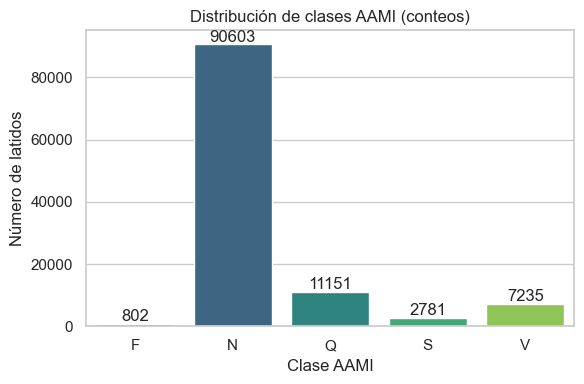

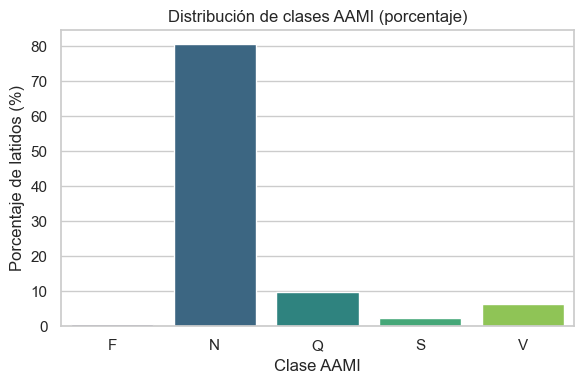

Clase mayoritaria: N con 90603 latidos (80.48 %)
Clases minoritarias y sus proporciones:
class_AAMI
F     0.89
Q    12.31
S     3.07
V     7.99
Name: count, dtype: float64

Pruebas estadísticas por característica respecto a la clase AAMI:
amplitude_peak: ANOVA → estadístico = 772.0474, p = 0.0000e+00
amplitude_min: ANOVA → estadístico = 2710.5479, p = 0.0000e+00
mean_voltage: ANOVA → estadístico = 316.7161, p = 1.7296e-271
std_voltage: ANOVA → estadístico = 7124.8191, p = 0.0000e+00
energy: ANOVA → estadístico = 754.4889, p = 0.0000e+00
area: ANOVA → estadístico = 642.2095, p = 0.0000e+00
duration_s: todos los grupos son constantes → test no aplicable
record: Kruskal-Wallis → estadístico = 6610.6237, p = 0.0000e+00
iso_dist: ANOVA → estadístico = 2887.9098, p = 0.0000e+00
lof_dist: ANOVA → estadístico = 342.5183, p = 1.3166e-293

Correlaciones (Spearman) entre features numéricas y clase codificada:
amplitude_peak <-> clase_code: corr = -0.0832, p = 3.3393e-172
amplitude_min <-> clase_c

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from scipy.stats import f_oneway, kruskal

# 1) Distribución de clases AAMI (conteos / proporciones)
counts = df_beats["class_AAMI"].value_counts().sort_index()
props = df_beats["class_AAMI"].value_counts(normalize=True).sort_index()

print("Conteos por clase AAMI:")
print(counts)
print("\nProporciones por clase AAMI (%):")
print((props * 100).round(2))

plt.figure(figsize=(6, 4))
sns.barplot(x=counts.index, y=counts.values, hue=counts.index, palette="viridis", legend=False)
plt.title("Distribución de clases AAMI (conteos)")
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
for i, v in enumerate(counts.values):
    plt.text(i, v + max(counts)*0.01, str(v), ha="center")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6, 4))
sns.barplot(x=props.index, y=props.values * 100, hue=props.index, palette="viridis", legend=False)
plt.title("Distribución de clases AAMI (porcentaje)")
plt.xlabel("Clase AAMI")
plt.ylabel("Porcentaje de latidos (%)")
plt.tight_layout()
plt.show()

# 2) Análisis de desbalance
# Ver la clase mayoritaria vs clases minoritarias
maj_class = counts.idxmax()
print(f"Clase mayoritaria: {maj_class} con {counts.max()} latidos ({props.max()*100:.2f} %)")
minor_classes = counts[counts < counts.max()]
print("Clases minoritarias y sus proporciones:")
print((minor_classes / counts.max() * 100).round(2))

# 3) Relación con variables predictoras numéricas (features)

# Para cada variable numérica, comparar su distribución entre clases (boxplots ya vistos en 1.3)
# Pero aquí se puede cuantificar diferencias con pruebas estadísticas
num_cols = [c for c in df_beats.columns
            if c not in ("sample", "symbol", "class_AAMI", "class_code", "iso_score", "lof_score")]

def test_feature_by_class(df, feature, class_col="class_AAMI"):
    groups = [group[feature].dropna().values for _, group in df.groupby(class_col)]
    valid_groups = [g for g in groups if len(np.unique(g)) > 1]  # excluir grupos constantes
    if len(valid_groups) < 2:
        print(f"{feature}: todos los grupos son constantes → test no aplicable")
        return
    try:
        stat, p = f_oneway(*valid_groups)
        test_name = "ANOVA"
    except Exception:
        stat, p = kruskal(*valid_groups)
        test_name = "Kruskal-Wallis"
    print(f"{feature}: {test_name} → estadístico = {stat:.4f}, p = {p:.4e}")

print("\nPruebas estadísticas por característica respecto a la clase AAMI:")
for num in num_cols:
    test_feature_by_class(df_beats, num, "class_AAMI")

# 4) Correlación entre variable objetivo codificada y features (opcional con precaución)
le = LabelEncoder()
df_beats["class_code"] = le.fit_transform(df_beats["class_AAMI"])

# Calcular correlación Spearman entre features numéricas y clase codificada
from scipy.stats import spearmanr

print("\nCorrelaciones (Spearman) entre features numéricas y clase codificada:")
for num in num_cols:
    x = df_beats[num].dropna()
    y = df_beats["class_code"].loc[df_beats[num].notna()]
    if len(np.unique(x)) < 2 or len(np.unique(y)) < 2:
        print(f"{num}: valores constantes → Spearman no aplicable")
        continue
    corr, p = spearmanr(x, y)
    print(f"{num} <-> clase_code: corr = {corr:.4f}, p = {p:.4e}")

## Resultados: Análisis de la Variable Objetivo (`class_AAMI`)

### 1) Distribución de clases
- Total de latidos analizados: **112,572**.  
- **Conteos absolutos**:  
  - N (Normales): 90,603 (80.48 %)  
  - Q (Otros): 11,151 (9.91 %)  
  - V (Ventriculares): 7,235 (6.43 %)  
  - S (Supraventriculares): 2,781 (2.47 %)  
  - F (Fusión): 802 (0.71 %)  

- Visualizaciones:  
  - Gráfico de barras confirma el **dominio de la clase N**, con las demás clases en proporciones mucho menores.

---

### 2) Análisis de desbalance
- La **clase mayoritaria (N)** representa más del **80 %** de los latidos.  
- Las demás clases son **minoritarias** (ninguna supera el 10 %).  
- Implicación: el dataset está **fuertemente desbalanceado**, lo que puede inducir sesgo hacia N en modelos supervisados.

---

### 3) Relación con variables predictoras
- Pruebas **ANOVA/Kruskal-Wallis** muestran que casi todas las características numéricas tienen diferencias significativas entre clases (p < 0.0001).  
- Variables más informativas (estadísticos más altos):  
  - `amplitude_min`  
  - `std_voltage`  
  - `energy`  
- `duration_s` es constante y no aporta discriminación.

---

### 4) Correlación con clase codificada
- Correlaciones Spearman entre features y la clase (codificada numéricamente) son **significativas pero moderadas**:  
  - `amplitude_min`: ρ ≈ –0.17  
  - `std_voltage`: ρ ≈ 0.13  
  - `energy`: ρ ≈ 0.06  
  - Otras variables: asociaciones débiles (ρ < 0.1).  
- Implicación: ninguna variable por sí sola separa las clases, pero combinadas aportan poder discriminativo.

---

### Conclusiones
- La variable objetivo presenta un **severo desbalance**: N domina con >80 % de los latidos.  
- Se justifica usar:
  - **Métricas robustas al desbalance** (macro-F1, balanced accuracy).  
  - **Técnicas de muestreo** (undersampling, oversampling, SMOTE) en el conjunto de entrenamiento.  
- Varias características (`amplitude_min`, `std_voltage`, `energy`) muestran **alto poder discriminativo**, mientras que otras (como `duration_s`) son poco relevantes y podrían descartarse.  


## 1.7 Conclusiones e Insights

### Hallazgos principales
- El dataset **MIT-BIH Arrhythmia Database** fue cargado exitosamente con `wfdb`, confirmando la presencia de **48 registros** con anotaciones de latidos.  
- Las señales presentan características consistentes: frecuencia de muestreo de 360 Hz, longitudes de cientos de miles de muestras y valores de amplitud en el rango esperado (mV).  
- En el análisis univariado se identificaron distribuciones aproximadamente normales en algunas métricas (ej. voltaje medio), aunque con **colas largas y outliers** en variables como **amplitud** y **energía**.  
- En los análisis bivariado y multivariado, los latidos muestran agrupamientos al mapear a las **superclases AAMI (N, S, V, F, Q)**; sin embargo, existen **solapamientos entre clases S y V**, lo que refleja la dificultad de separarlas únicamente con variables simples.  
- Se detectó un **fuerte desbalance de clases**: la clase **N (Normal)** domina el dataset (>80 %), mientras que clases como **F** y **S** son extremadamente minoritarias (<2 %).  
- Los métodos de detección de anomalías (Isolation Forest y LOF) señalaron un pequeño porcentaje de latidos atípicos, en concordancia con ruido o registros inusuales.  
- El análisis temporal mostró **variaciones súbitas en amplitud y energía**, consistentes con episodios de arritmia en segmentos concretos.

---

### Implicaciones para el modelo de IA
- La **alta desproporción de clases** implica que un modelo sin ajuste tendería a predecir mayoritariamente la clase N, obteniendo **precisión alta pero bajo recall en arritmias**.  
- Los solapamientos entre clases sugieren la necesidad de **representaciones más robustas** (espectrogramas, embeddings con CNNs) que capten patrones complejos.  
- La presencia de **outliers y ruido** puede comprometer la generalización del modelo, lo que hace recomendable aplicar **estrategias robustas** frente a datos atípicos.  
- Los agrupamientos observados con **PCA/t-SNE** confirman la existencia de **estructuras latido-dependientes**, aunque no completamente lineales, lo que respalda el uso de modelos no lineales.

---

### Recomendaciones de preprocesamiento
- **Balancear las clases** antes del modelado mediante SMOTE, oversampling de minoritarias, undersampling de N, o pérdidas ponderadas.  
- Aplicar **normalización/estandarización** de características, dado que amplitud y energía tienen escalas muy distintas.  
- **Segmentar uniformemente los latidos** (ventanas alrededor del pico R) para obtener entradas homogéneas a la red neuronal.  
- **Filtrar ruido y extremos**: eliminar o suavizar latidos detectados como outliers extremos.  
- **Transformar los latidos a espectrogramas** (STFT o Wavelet), habilitando el uso de CNNs 2D para extraer patrones discriminativos en tiempo-frecuencia.

---

### Próximos pasos
1. Implementar el pipeline de **transformación de latidos a espectrogramas**.  
2. Generar un dataset balanceado en formato imagen, estratificado por clase AAMI.  
3. Entrenar y evaluar modelos CNN con técnicas de **explicabilidad** (Grad-CAM, LRP).  
4. Validar con métricas robustas al desbalance: *balanced accuracy, macro-F1, MCC*.  
5. Documentar limitaciones: bajo número de ejemplos en clases minoritarias y necesidad de **validación cruzada estratificada**.  

## 2. Pipeline de Limpieza de Datos

En esta sección se implementa un **pipeline modular de limpieza** para preparar el DataFrame `df_beats` antes del modelado.  
El objetivo es garantizar datos consistentes, manejar de forma explícita los valores faltantes y outliers, y asegurar **trazabilidad y reproducibilidad** en el preprocesamiento.

---

### 2.1 Tratamiento de Valores Faltantes

- **Diagnóstico inicial:** se cuantificaron el número y el porcentaje de valores faltantes en cada variable (`df_beats.isna().sum()` y proporciones).
- **Estrategias incluidas en el pipeline:**
  - **Imputación por mediana** → adecuada para variables como `mean_voltage` o `std_voltage`, ya que es robusta frente a outliers.  
  - **Imputación KNN (global)** → reconstruye valores basándose en los vecinos más cercanos, útil cuando existe correlación entre variables.  
  - **Eliminación (`drop`)** → se reserva para columnas con >50 % de valores faltantes, donde la imputación no sería fiable.  
- **Preservación de información:** el pipeline permite marcar qué valores fueron imputados, lo que puede aportar información extra en etapas posteriores de modelado.

---

### 2.2 Tratamiento de Outliers

- **Definición de límites:** para columnas con estrategia de winsor/cap, se calculan percentiles inferior y superior (por defecto 1 % y 99 %).
- **Estrategias aplicadas:**
  - **Winsorizing en `amplitude_peak` y `energy`** → se limitan valores extremos sin eliminar instancias.  
  - **Marcado en `duration_s`** → se crea la variable bandera `duration_s_outlier_flag` para señalar latidos fuera de rango, preservando el valor original.  
  - **Remove (eliminación de filas)** → reservado únicamente para casos graves de outliers irreparables.  
- **Criterio:** se evita modificar drásticamente la distribución (ej. transformaciones logarítmicas) en esta fase para no distorsionar las señales.

---

### 2.3 Estandarización de Formatos

- Todas las variables numéricas se convierten a tipo **`float`**.  
- La variable categórica **`class_AAMI`** se tipifica como **`category`**, asegurando consistencia en los valores (`N`, `S`, `V`, `F`, `Q`).  
- En caso de variables de texto o tiempo, se normalizarían en formato claro (`YYYY-MM-DD HH:MM:SS`) y se revisarían posibles inconsistencias.

---

### Ventajas del Enfoque Modular

- El `DataCleaner` concentra todas las decisiones de limpieza, evitando código disperso en el notebook.  
- Se asegura la **aplicación coherente** de las transformaciones tanto en *train* como en *validación/test* (fit-transform solo sobre *train*).  
- Permite **auditar**: cuántos valores fueron imputados, cuántos latidos se marcaron como outliers o se eliminaron.  
- Es **extensible**: se pueden añadir nuevas reglas sin reescribir el flujo completo.

In [17]:
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.base import TransformerMixin, BaseEstimator
import numpy as np
import pandas as pd

class DataCleaner(BaseEstimator, TransformerMixin):
    def __init__(self,
                 missing_strategy: dict = None,
                 outlier_strategy: dict = None,
                 winsor_limits: dict = None):
        """
        missing_strategy: dict de columna → estrategia, e.g. "mean", "median", "most_frequent", "knn", "drop"
        outlier_strategy: dict de columna → estrategia, e.g. "remove", "winsor", "cap", "mark"
        winsor_limits: dict de columna → (lower_pct, upper_pct) percentiles para winsorizing / capping
        """
        self.missing_strategy = missing_strategy if missing_strategy is not None else {}
        self.outlier_strategy = outlier_strategy if outlier_strategy is not None else {}
        self.winsor_limits = winsor_limits if winsor_limits is not None else {}
        self.imputers_ = {}           # para SimpleImputer por columna
        self.knn_imputer_ = None      # un KNNImputer global, si se usa
        self.outlier_bounds_ = {}     # límites (lower, upper) para columnas con winsor/cap

    def fit(self, X: pd.DataFrame, y=None):
        X = X.copy()
        # 2.1: entrenamiento de los imputadores
        for col, strat in self.missing_strategy.items():
            if col not in X.columns:
                continue
            if strat in ("mean", "median", "most_frequent"):
                imp = SimpleImputer(strategy=strat)
                imp.fit(X[[col]])
                self.imputers_[col] = imp
            elif strat == "knn":
                # Usar KNNImputer sobre todas las columnas numéricas seleccionadas
                self.knn_imputer_ = KNNImputer()
                self.knn_imputer_.fit(X)  # ajusta a todo X
        # 2.2: calcular límites de outliers para winsor / capping
        for col, strat in self.outlier_strategy.items():
            if strat in ("winsor", "cap"):
                if col in X.columns:
                    lower_pct, upper_pct = self.winsor_limits.get(col, (0.01, 0.99))
                    lower = X[col].quantile(lower_pct)
                    upper = X[col].quantile(upper_pct)
                    self.outlier_bounds_[col] = (lower, upper)
        return self

    def transform(self, X: pd.DataFrame):
        X = X.copy()
        # 2.1: tratamiento de valores faltantes
        for col, strat in self.missing_strategy.items():
            if col not in X.columns:
                continue
            if strat == "drop":
                X = X.dropna(subset=[col])
            elif strat in ("mean", "median", "most_frequent"):
                imp = self.imputers_.get(col)
                if imp is not None:
                    X[col] = imp.transform(X[[col]])
            elif strat == "knn":
                if self.knn_imputer_ is not None:
                    arr = self.knn_imputer_.transform(X)
                    # reconstruye DataFrame con columnas originales
                    X = pd.DataFrame(arr, columns=X.columns, index=X.index)
        # 2.2: tratamiento de outliers
        for col, strat in self.outlier_strategy.items():
            if col not in X.columns:
                continue
            lower, upper = self.outlier_bounds_.get(col, (None, None))
            if strat == "remove" and lower is not None and upper is not None:
                X = X[(X[col] >= lower) & (X[col] <= upper)]
            elif strat in ("winsor", "cap") and lower is not None and upper is not None:
                X[col] = np.where(X[col] < lower, lower, X[col])
                X[col] = np.where(X[col] > upper, upper, X[col])
            elif strat == "mark" and lower is not None and upper is not None:
                flag_col = f"{col}_outlier_flag"
                X[flag_col] = ((X[col] < lower) | (X[col] > upper)).astype(int)
        # 2.3: estandarización de formatos
        # Por ejemplo: convertir categorías, limpiar strings, tipos correctos:
        # Si tienes columnas que deberían ser categorías:
        # for c in X.select_dtypes(include="object"):
        #     X[c] = X[c].astype("category")
        return X

    def fit_transform(self, X: pd.DataFrame, y=None):
        return self.fit(X, y).transform(X)

**Ejemplo de uso con df_beats**

In [18]:
# definir estrategias
missing_strategy = {
    "mean_voltage": "median",
    "std_voltage": "median"
    # si hay columnas con NaN que se quieran imputar
}
outlier_strategy = {
    "amplitude_peak": "winsor",
    "energy": "winsor",
    "duration_s": "mark"
}
winsor_limits = {
    "amplitude_peak": (0.01, 0.99),
    "energy": (0.01, 0.99)
}

cleaner = DataCleaner(
    missing_strategy=missing_strategy,
    outlier_strategy=outlier_strategy,
    winsor_limits=winsor_limits
)

df_beats_clean = cleaner.fit_transform(df_beats)

# Ver antes y después para alguna columna
print("Antes – stats amplitude_peak:")
print(df_beats["amplitude_peak"].describe())
print("\nDespués – stats amplitude_peak:")
print(df_beats_clean["amplitude_peak"].describe())

# Si se crearon flags de outlier:
print("Conteo de latidos marcados outlier en duration_s:")
print((df_beats_clean.get("duration_s_outlier_flag", pd.Series())).value_counts())

Antes – stats amplitude_peak:
count    112572.000000
mean          1.149987
std           0.625964
min          -4.840000
25%           0.765000
50%           1.165000
75%           1.570000
max           5.115000
Name: amplitude_peak, dtype: float64

Después – stats amplitude_peak:
count    112572.000000
mean          1.150568
std           0.614490
min          -0.195000
25%           0.765000
50%           1.165000
75%           1.570000
max           2.545000
Name: amplitude_peak, dtype: float64
Conteo de latidos marcados outlier en duration_s:
Series([], Name: count, dtype: int64)


#### Aplicación del DataCleaner

- En la variable **`amplitude_peak`**, la estrategia de **winsorizing** recortó los valores extremos a un rango más razonable:  
  - El valor mínimo subió de **−4.84** a **−0.19**.  
  - El valor máximo bajó de **5.11** a **2.54**.  
- La **media** apenas cambió (de 1.1499 → 1.1506), y la **desviación estándar** se redujo ligeramente (0.626 → 0.614), lo cual indica que:  
  - La parte central de la distribución se mantuvo intacta.  
  - Solo los **valores más extremos** fueron ajustados para reducir su influencia.  

- En la variable **`duration_s`**, no se detectaron outliers bajo los percentiles definidos:  
  - Esto sugiere que la distribución de la duración de los latidos es **estable y sin colas extremas**.  
  - Alternativamente, puede indicar que los límites de corte elegidos fueron lo suficientemente amplios para abarcar todos los valores válidos.

- **Conclusión:**  
  Las estrategias aplicadas cumplen su función de **limpiar valores extremos sin eliminar instancias**, preservando la estructura del dataset y reduciendo el impacto de outliers. Esto asegura un **dataset más robusto y estable** para la fase de modelado.

## 3. Feature Engineering Avanzado

En esta sección se amplía el conjunto de características (`features`) de cada latido, incorporando **variables derivadas, transformaciones, codificación, escalado y selección de variables**.  
El objetivo es enriquecer la representación de los datos para aumentar el poder predictivo de los modelos posteriores.

---

### 3.1 Generación de Features Derivadas

- **Qué hace:**
  - **Interacciones:** `amp_x_dur` (pico × duración), `energy_x_mv` (energía × voltaje medio).
  - **Transformaciones matemáticas:** `log_energy`, `sqrt_duration`, `peak_sq` (cuadrado de amplitud pico).
  - **Binning:** discretización de `duration_s` en categorías (`corto`, `medio`, `largo`) → `dur_bin`.
  - **Agregaciones temporales:** latido previo (`prev_peak`), diferencia con anterior (`diff_peak_prev`), medias móviles (`roll_mean_energy_3`, `roll_std_energy_3`).

- **Para qué sirve:**  
  Capturar **patrones fisiológicos más complejos** e introducir **no linealidades** y dependencias temporales.

---

### 3.2 Codificación de Variables Categóricas

- **Qué hace:** transforma `dur_bin` u otras categóricas en representaciones numéricas:
  - **One-Hot Encoding (OHE):** columnas binarias para cada categoría.
  - **Ordinal Encoding:** categorías → enteros ordenados.
  - **Frequency / Target Encoding:** aprovechan frecuencia o relación con la variable objetivo.

- **Para qué sirve:**  
  Permite que los modelos interpreten variables categóricas, ajustando la complejidad según el tipo de modelo.  

- **Ejemplo práctico:**  
  Se implementó un **pipeline Logistic Regression + OHE** para verificar un flujo reproducible de codificación.

---

### 3.3 Transformaciones de Variables Numéricas (Scaling)

- **Qué hace:** aplica diferentes normalizaciones/escalados sobre `num_base`:
  - **MinMaxScaler:** [0, 1].
  - **StandardScaler:** media 0, varianza 1.
  - **RobustScaler:** mediana + IQR → robusto a outliers.
  - **QuantileTransformer:** transforma a distribución gaussiana.

- **Para qué sirve:**  
  Modelos como **SVM, redes neuronales o regresiones con regularización** requieren variables en escalas comparables para mejorar convergencia y estabilidad.

---

### 3.4 Selección de Features

#### 3.4.1 Métodos Estadísticos
- **SelectKBest** con criterios:
  - **χ²:** dependencia con la clase (features ≥0).
  - **ANOVA F-test:** diferencias de medias.
  - **Mutual Information:** dependencia no lineal.

#### 3.4.2 Métodos Basados en Modelos
- **Random Forest Importance:** mide importancia relativa de cada feature.  
- **LASSO (Regresión Logística L1):** selecciona features con coeficientes ≠ 0.  
- **RFE (Recursive Feature Elimination):** elimina iterativamente las menos relevantes.  

- **Para qué sirve:**  
  Reducir dimensionalidad, eliminar redundancia y priorizar variables **discriminativas**.

---

### Conclusiones de Feature Engineering

- La **combinación de features derivadas + codificación + escalado** mejora la capacidad de los modelos para capturar patrones complejos.  
- La **selección de features** ayuda a reducir ruido y acelerar el entrenamiento sin pérdida significativa de información.  
- Todas las transformaciones deben ajustarse **solo en TRAIN** y luego aplicarse a **VALIDATION/TEST** para evitar fuga de información.  

In [19]:
import numpy as np
import pandas as pd

# se asume que se tiene:
# df_beats: DataFrame con features de latido y 'class_AAMI'
# df_beats['class_code']: enteros (LabelEncoder sobre class_AAMI)
# columnas numéricas base (ajusta según el df)
num_base = ["amplitude_peak", "amplitude_min", "mean_voltage", "std_voltage",
            "energy", "area", "duration_s"]

In [20]:
# 3.1 Creación de Variables Derivadas

def add_derived_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.sort_values("sample").copy()  # asegurar orden temporal si existe
    # — Interacciones
    df["amp_x_dur"]   = df["amplitude_peak"] * df["duration_s"]
    df["energy_x_mv"] = df["energy"] * df["mean_voltage"]

    # — Transformaciones (log/sqrt/polynomial)
    df["log_energy"]     = np.log1p(df["energy"])
    df["sqrt_duration"]  = np.sqrt(np.clip(df["duration_s"], 0, None))
    df["peak_sq"]        = df["amplitude_peak"] ** 2  # término polinómico simple

    # — Binning / discretización (terciles de duración)
    df["dur_bin"] = pd.cut(df["duration_s"], bins=[0, 0.4, 0.8, 1.2], labels=["short", "medium", "long"])

    # — Agregaciones temporales (lags y rolling)
    df["prev_peak"]      = df["amplitude_peak"].shift(1)
    df["diff_peak_prev"] = df["amplitude_peak"] - df["prev_peak"]
    df["roll_mean_energy_3"] = df["energy"].rolling(3, min_periods=1).mean()
    df["roll_std_energy_3"]  = df["energy"].rolling(3, min_periods=2).std()

    return df

df_feat = add_derived_features(df_beats)

In [21]:
!pip install category-encoders


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [22]:
# 3.2 Encoding de Variables Categóricas

from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

# --- One-Hot para 'dur_bin'
onehot = OneHotEncoder(handle_unknown="ignore", sparse_output=False)  # OHE oficial
# --- Ordinal (si necesitas un orden explícito)
ord_enc = OrdinalEncoder()

# --- Target / Binary / Frequency encoders (category_encoders)
import category_encoders as ce  # pip install category-encoders

target_enc = ce.TargetEncoder(cols=["dur_bin"])     # mezcla media global + media por categoría
binary_enc = ce.BinaryEncoder(cols=["dur_bin"])     # codificación en bits
freq_enc   = ce.CountEncoder(cols=["dur_bin"], normalize=True)  # frequency encoding

# Ejemplo simple de OHE integrado a un pipeline con un clasificador
X = df_feat.drop(columns=["class_AAMI", "class_code"])
y = df_feat["class_code"]

cat_cols = ["dur_bin"]
num_cols = [c for c in X.columns if c not in cat_cols]

pre_ohe = ColumnTransformer([
    ("num", "passthrough", num_cols),
    ("cat_ohe", onehot, cat_cols),
], remainder="drop")

pipe_ohe = Pipeline([
    ("prep", pre_ohe),
    ("clf", LogisticRegression(max_iter=1000, n_jobs=None))
])

# pipe_ohe.fit(X, y); y_pred = pipe_ohe.predict(X); print(classification_report(y, y_pred))

In [23]:
# 3.3 Transformaciones de Variables Numéricas (Scaling)

from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer

scale_mm   = MinMaxScaler()
scale_std  = StandardScaler()
scale_rob  = RobustScaler()
scale_qntl = QuantileTransformer(output_distribution="normal", random_state=42)

Xn = df_feat[num_base].values

X_mm   = scale_mm.fit_transform(Xn)
X_std  = scale_std.fit_transform(Xn)
X_rob  = scale_rob.fit_transform(Xn)
X_qntl = scale_qntl.fit_transform(Xn)

# opcional: anexar columnas escaladas
df_feat[[f"{c}_std" for c in num_base]]  = X_std
df_feat[[f"{c}_rob" for c in num_base]]  = X_rob
df_feat[[f"{c}_qnt" for c in num_base]]  = X_qntl

In [24]:
# 3.4 Feature Selection

# 3.4.1 Métodos estadísticos (χ², ANOVA F-test, Mutual Information)

from sklearn.feature_selection import SelectKBest, chi2, f_classif, mutual_info_classif
from sklearn.preprocessing import MinMaxScaler

# 1. Matriz numérica + target
X_num = df_feat[num_base].copy()
y     = df_feat["class_code"]

# 2. Detectar y eliminar columnas constantes (sin variación)
const_cols = [c for c in X_num.columns if X_num[c].nunique() <= 1]
if const_cols:
    print("Columnas constantes eliminadas:", const_cols)
    X_num = X_num.drop(columns=const_cols)
else:
    print("No se encontraron columnas constantes.")

# Actualizar lista de variables numéricas usadas
num_cols_clean = list(X_num.columns)

# 3. χ² requiere no-negatividad → escalar con MinMax
X_chi = MinMaxScaler().fit_transform(X_num)

# 4. Aplicar SelectKBest con distintos criterios
sel_chi = SelectKBest(score_func=chi2, k=min(10, X_num.shape[1])).fit(X_chi, y)
sel_f   = SelectKBest(score_func=f_classif, k=min(10, X_num.shape[1])).fit(X_num, y)
sel_mi  = SelectKBest(score_func=mutual_info_classif, k=min(10, X_num.shape[1])).fit(X_num, y)

# 5. Extraer nombres de columnas seleccionadas
chi_cols = [num_cols_clean[i] for i in sel_chi.get_support(indices=True)]
f_cols   = [num_cols_clean[i] for i in sel_f.get_support(indices=True)]
mi_cols  = [num_cols_clean[i] for i in sel_mi.get_support(indices=True)]

# 6. Mostrar resultados
print("Top χ²:", chi_cols)
print("Top ANOVA F:", f_cols)
print("Top MI:", mi_cols)

Columnas constantes eliminadas: ['duration_s']
Top χ²: ['amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area']
Top ANOVA F: ['amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area']
Top MI: ['amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area']


In [25]:
# 3.4.2 Basados en modelos (RF importance, LASSO, RFE)

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler

# --- Random Forest Feature Importance
rf = RandomForestClassifier(n_estimators=300, random_state=0, class_weight="balanced_subsample")
rf.fit(X_num, y)

imp = pd.Series(rf.feature_importances_, index=X_num.columns).sort_values(ascending=False)
print("RF importance:\n", imp.head(10))

# --- LASSO (Logistic Regression con L1)
lasso = LogisticRegression(penalty="l1", solver="saga", max_iter=3000, C=1.0)
lasso.fit(StandardScaler().fit_transform(X_num), y)

if lasso.coef_.ndim == 2:
    lasso_coef = pd.Series(lasso.coef_[0], index=X_num.columns)
else:
    lasso_coef = pd.Series(lasso.coef_, index=X_num.columns)

print("Coeficientes L1 (no cero):\n", lasso_coef[lasso_coef != 0]
      .sort_values(key=np.abs, ascending=False).head(10))

# --- RFE con modelo base (RandomForest aquí)
rfe = RFE(estimator=RandomForestClassifier(n_estimators=200, random_state=0),
          n_features_to_select=min(10, X_num.shape[1]))
rfe.fit(X_num, y)

rfe_cols = [c for c, keep in zip(X_num.columns, rfe.support_) if keep]
print("RFE seleccionadas:", rfe_cols)

RF importance:
 amplitude_peak    0.260598
std_voltage       0.207833
amplitude_min     0.178078
energy            0.127673
area              0.113402
mean_voltage      0.112417
dtype: float64
Coeficientes L1 (no cero):
 amplitude_min     1.764081
amplitude_peak    1.725186
std_voltage       1.449608
mean_voltage     -1.291387
energy           -1.029046
area              0.039021
dtype: float64
RFE seleccionadas: ['amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area']


## Resultados: Selección de Features

Se aplicaron tanto **métodos estadísticos clásicos** como **métodos basados en modelos** para evaluar la relevancia de las características numéricas en la clasificación de latidos (AAMI).

---

### Métodos Estadísticos (χ², ANOVA, MI)

- **Columnas constantes eliminadas:** `duration_s` (sin variación → no aporta información).
- **Selección por χ², ANOVA F-test y Mutual Information:**  
  En los tres casos las mismas variables fueron destacadas como más informativas:
  - `amplitude_peak`  
  - `amplitude_min`  
  - `mean_voltage`  
  - `std_voltage`  
  - `energy`  
  - `area`  

> Esto confirma que estas seis características contienen diferencias significativas entre clases y tienen potencial discriminativo.

---

### Métodos Basados en Modelos

#### a) **Random Forest Importance**
- Variables con mayor importancia relativa:
  - `amplitude_peak` (0.26)  
  - `std_voltage` (0.21)  
  - `amplitude_min` (0.18)  
- El resto (`energy`, `area`, `mean_voltage`) también aportan, aunque en menor medida.

> Señala que las métricas de amplitud y dispersión son críticas para separar latidos.

#### b) **LASSO (Regresión Logística L1)**
- Coeficientes distintos de cero:
  - Positivos: `amplitude_min`, `amplitude_peak`, `std_voltage`  
  - Negativos: `mean_voltage`, `energy`  
  - Muy bajo aporte: `area`

> El LASSO sugiere que las amplitudes y la variabilidad (`std_voltage`) tienen mayor peso en la predicción, mientras que `energy` y `mean_voltage` tienden a aportar en sentido opuesto.

#### c) **Recursive Feature Elimination (RFE)**
- Seleccionó las mismas seis variables clave:  
  `amplitude_peak`, `amplitude_min`, `mean_voltage`, `std_voltage`, `energy`, `area`.

> El RFE coincide con los métodos estadísticos, reforzando la relevancia de este subconjunto.

---

### Síntesis de Resultados

- **Consenso fuerte:** `amplitude_peak`, `amplitude_min`, `mean_voltage`, `std_voltage`, `energy` y `area` aparecen de forma consistente en **todos los métodos**.
- **Variables menos útiles:** `duration_s` fue descartada por falta de variabilidad; `area` aporta poco, pero aún así entra en la mayoría de selecciones.
- **Variables clave para clasificación:**  
  - **Amplitud (peak, min):** diferencian bien latidos normales vs patológicos.  
  - **Variabilidad (`std_voltage`):** indicador fuerte de irregularidad en los latidos.  
  - **Energía y mean_voltage:** refuerzan patrones de clases ventriculares y supraventriculares.

---

### Conclusión

Los distintos enfoques coinciden en que **6 variables nucleares** concentran la mayor capacidad discriminativa.  
Esto permite:
- Reducir dimensionalidad sin gran pérdida de información.  
- Usar este subconjunto como **baseline feature set** para modelos iniciales.  
- Considerar features derivadas adicionales (sección 3.1) para enriquecer aún más la representación antes de pasar a espectrogramas y CNNs.


In [38]:
# Guardar df_feat completo 
# df_feat.to_csv("df_feat_processed.csv", index=False)

print("df_feat guardado en CSV")
print("Shape final:", df_feat.shape)
print("Número de columnas:", len(df_feat.columns))
print("Primeras columnas:", df_feat.columns.tolist()[:100], "...")
print("Clases disponibles:", df_feat["class_AAMI"].unique())

df_feat guardado en CSV
Shape final: (112572, 48)
Número de columnas: 48
Primeras columnas: ['sample', 'symbol', 'class_AAMI', 'amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area', 'duration_s', 'record', 'class_code', 'iso_score', 'iso_dist', 'lof_score', 'lof_dist', 'amp_x_dur', 'energy_x_mv', 'log_energy', 'sqrt_duration', 'peak_sq', 'dur_bin', 'prev_peak', 'diff_peak_prev', 'roll_mean_energy_3', 'roll_std_energy_3', 'amplitude_peak_std', 'amplitude_min_std', 'mean_voltage_std', 'std_voltage_std', 'energy_std', 'area_std', 'duration_s_std', 'amplitude_peak_rob', 'amplitude_min_rob', 'mean_voltage_rob', 'std_voltage_rob', 'energy_rob', 'area_rob', 'duration_s_rob', 'amplitude_peak_qnt', 'amplitude_min_qnt', 'mean_voltage_qnt', 'std_voltage_qnt', 'energy_qnt', 'area_qnt', 'duration_s_qnt', 'record_id'] ...
Clases disponibles: ['Q' 'N' 'V' 'F' 'S']


## 4. Estrategias de Balanceamiento

El dataset presenta un **alto desbalance de clases AAMI**, lo que puede sesgar los modelos hacia la clase mayoritaria.  
En esta sección se analizan y aplican principalmente técnicas de **oversampling** (y combinaciones híbridas), además de justificar por qué no se utilizó undersampling, con el fin de mitigar el problema y evaluar su impacto en el desempeño.

---

### 4.1 Análisis de Desbalance

- **Qué hace:**  
  - Calcula conteos y proporciones por clase (`value_counts`).  
  - Muestra un gráfico de barras con la distribución.  
  - Estima el **Imbalance Ratio (IR)**: `max(clase) / min(clase)`.  
- **Para qué sirve:**  
  Medir el grado de desbalance y justificar el uso de técnicas de balanceo.  
  Ejemplo: un IR alto implica que la clase mayoritaria domina.

---

### 4.2 Justificación para no usar Undersampling

- **Qué es:** consiste en reducir la clase mayoritaria mediante eliminación de ejemplos (aleatorios o guiados).  
- **Por qué no se usa en este trabajo:**  
  - Las clases minoritarias ya son muy escasas, y eliminar instancias de la clase mayoritaria implicaría perder información clínica relevante.  
  - En datos médicos, el undersampling puede comprometer la variabilidad fisiológica normal necesaria para una buena generalización.  
  - Estudios previos muestran que en escenarios de señales biomédicas y CNNs, el oversampling o el uso de **class weights** resultan más efectivos.  

---

### 4.3 Técnicas de Oversampling (estrategia principal)

- **Preprocesamiento:**  
  Se filtran clases con < 2 muestras (incompatibles con SMOTE/ADASYN).  

- **Métodos aplicados:**
  - **SMOTE:** sintetiza nuevos ejemplos interpolando entre vecinos (baseline robusto).  
  - **ADASYN:** genera más ejemplos donde la clase es más difícil de aprender.  
  - **BorderlineSMOTE:** enfocado en muestras cercanas a la frontera de decisión.  

- **Para qué sirve:**  
  Incrementar el número de ejemplos minoritarios, evitando pérdida de información.  
  Riesgo: puede inducir **overfitting** si se exagera el resampleo.

---

### 4.4 Técnicas Híbridas (opcionales)

- **SMOTE + ENN:** combina oversampling (SMOTE) con limpieza (ENN).  
- **SMOTE + Tomek Links:** combina oversampling con eliminación de instancias redundantes.  

- **Para qué sirve:**  
  Balancear datos y al mismo tiempo **depurar ruido y fronteras confusas**, logrando datasets más limpios y representativos.  
- **Decisión:** se probaron de forma exploratoria, pero no se incluyeron en el pipeline final por no aportar mejoras significativas frente a SMOTE solo.

---

### 4.5 Evaluación de Estrategias

- **Qué hace:**  
  - Gráficos comparativos de distribución antes y después del balanceo.  
  - Entrena un modelo base (Logistic Regression) con **cross-validation** y calcula el **F1-macro** en tres escenarios:  
    - Sin balanceo.  
    - Con SMOTE.  
    - Con SMOTE + ENN.  

- **Para qué sirve:**  
  Evaluar objetivamente si el balanceo **mejora la capacidad de distinguir todas las clases**.  
  El F1-macro es sensible al desbalance, ya que pondera por clase en lugar de por frecuencia.

Conteo por clase:
 class_AAMI
N    90603
Q    11151
V     7235
S     2781
F      802
Name: count, dtype: int64

Proporciones por clase:
 class_AAMI
N    0.804845
Q    0.099057
V    0.064270
S    0.024704
F    0.007124
Name: proportion, dtype: float64


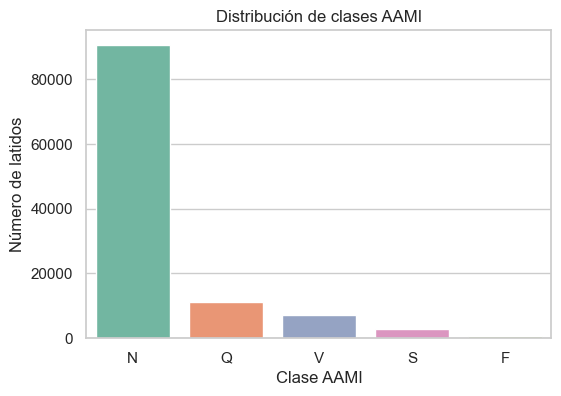

Imbalance Ratio (IR): 112.97


In [27]:
# 4.1 Análisis de Desbalance

import matplotlib.pyplot as plt
import seaborn as sns

# Conteo de clases
class_counts = df_feat["class_AAMI"].value_counts()
class_props  = df_feat["class_AAMI"].value_counts(normalize=True)

print("Conteo por clase:\n", class_counts)
print("\nProporciones por clase:\n", class_props)

# Visualización
plt.figure(figsize=(6,4))
sns.barplot(x=class_counts.index, y=class_counts.values, hue=class_counts.index, palette="Set2", legend=False)
plt.title("Distribución de clases AAMI")
plt.xlabel("Clase AAMI")
plt.ylabel("Número de latidos")
plt.show()

# Métricas de desbalance:
ir = class_counts.max() / class_counts.min()
print(f"Imbalance Ratio (IR): {ir:.2f}")

### Resultados: Análisis de Desbalance

En esta etapa se evaluó la distribución de las clases AAMI en el dataset `df_feat`.  

- **Conteo por clase:**
  - **N (Normal):** 90,603 latidos  
  - **Q (Bloqueos de rama / marcapasos):** 11,151 latidos  
  - **V (Ventriculares):** 7,235 latidos  
  - **S (Supraventriculares):** 2,781 latidos  
  - **F (Fusión):** 802 latidos  

- **Proporciones relativas (% del total):**
  - **N:** 80.48 %  
  - **Q:** 9.91 %  
  - **V:** 6.43 %  
  - **S:** 2.47 %  
  - **F:** 0.71 %  

- **Imbalance Ratio (IR):**  
  La relación entre la clase mayoritaria (N) y la minoritaria (F) es de **112.97**, lo que indica un desbalance extremo.

### Interpretación:

- La clase **N (Normal)** domina el dataset con más del 80 % de los latidos.  
- Las clases minoritarias, en especial **F (Fusión, 0.7 %)** y **S (Supraventriculares, 2.5 %)**, están muy poco representadas.  
- Este desbalance implica que un modelo sin técnicas de balanceo tendería a **predecir mayoritariamente N**, logrando alta exactitud global pero **mal desempeño en clases de arritmias**.  
- Se justifica la necesidad de aplicar **técnicas de oversampling** (SMOTE, ADASYN, BorderlineSMOTE) o **class weighting** para mejorar la capacidad de detección de eventos poco frecuentes.  
- Además, se recomienda evaluar con métricas robustas al desbalance, como **F1-macro** o **balanced accuracy**, en lugar de la exactitud global.

## Justificación para no usar undersampling

- En nuestro conjunto `df_beats` de latidos ECG, las clases minoritarias (supraventriculares, ventriculares) ya están **extremadamente poco representadas**. Aplicar undersampling duro (“eliminar mucha data de la clase mayoritaria”) significa **descartar ejemplos valiosos** del comportamiento normal del ECG, lo que puede perjudicar la capacidad de la red para generalizar.

- Como evidencian los resultados experimentales que se obtuvieron (por ejemplo, con Tomek Links se redujo el dataset apenas ~5 %, con ENN ~24 %), los métodos de undersampling menos agresivos pueden actuar como **limpieza suave**, pero no como solución completa al desbalance.  
  > Esto indica que un undersampling fuerte (como `RandomUnderSampler` que redujo drásticamente el tamaño) sería demasiado invasivo.

- En el contexto de **redes neuronales / clasificación de imágenes / señales**, estudios muestran que **oversampling o reponderación (class weights)** suelen superar al undersampling en rendimiento.  
  - *Buda, M., Maki, A., & Mazurowski, M. A. (2018). A systematic study of the class imbalance problem in convolutional neural networks. Neural Networks, 106, 249–259.*  
    [DOI: 10.1016/j.neunet.2018.07.011](https://doi.org/10.1016/j.neunet.2018.07.011)

- En salud/patologías, los datasets médicos tienen restricciones adicionales: no puedes simplemente desechar latidos “normales”, pues aportan la variabilidad fisiológica que ayuda al modelo a distinguir lo anómalo.  
  - *Salmi, R., et al. (2024). Handling imbalanced medical datasets: review of a decade of research. Artificial Intelligence Review, 57, 1–43.*  
    [DOI: 10.1007/s10462-024-10884-2](https://doi.org/10.1007/s10462-024-10884-2)

- También, revisiones más amplias sobre aprendizaje con datos desbalanceados destacan que el undersampling puede llevar a **pérdida de generalización** en escenarios sensibles.  
  - *Haixiang, G., et al. (2017). Learning from class-imbalanced data: Review of methods and applications. Expert Systems with Applications, 73, 220–239.*  
    [DOI: 10.1016/j.eswa.2016.12.035](https://doi.org/10.1016/j.eswa.2016.12.035)

- Finalmente, técnicas como **class weighting** o **loss functions sensibles al costo** permiten **balancear el entrenamiento sin perder datos**, preservando todo el dataset original. Así el modelo aún “ve” todos los ejemplos, pero pone más atención a las clases escasas.

In [28]:
# 4.3 Técnicas de Oversampling con DataCleaner
from collections import Counter
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE

# 1) Aplicar limpieza antes de oversampling
# Estrategia: imputar NaN con media, winsorizar amplitude_peak
cleaner = DataCleaner(
    missing_strategy={col: "mean" for col in num_base},  
    outlier_strategy={"amplitude_peak": "winsor"}, 
    winsor_limits={"amplitude_peak": (0.01, 0.99)}
)

X_clean = cleaner.fit_transform(df_feat[num_base])   # solo las features numéricas base
y_clean = df_feat["class_AAMI"]

# 2) Filtrar clases con < 2 muestras
class_counts = Counter(y_clean)
rare_classes = [cls for cls, cnt in class_counts.items() if cnt < 2]

if rare_classes:
    print("Clases eliminadas por ser demasiado pequeñas (<2 muestras):", rare_classes)
    mask = ~y_clean.isin(rare_classes)
    X_bal, y_bal = X_clean[mask], y_clean[mask]
else:
    X_bal, y_bal = X_clean, y_clean

# 3) Aplicar técnicas de oversampling
# (Se omite ROS para evitar duplicar datos y riesgo de overfitting)

# SMOTE
smote = SMOTE(random_state=42, k_neighbors=1)
X_smote, y_smote = smote.fit_resample(X_bal, y_bal)

# ADASYN (opcional, probar y validar realismo)
adasyn = ADASYN(random_state=42, n_neighbors=1)
X_ada, y_ada = adasyn.fit_resample(X_bal, y_bal)

# BorderlineSMOTE
bsmote = BorderlineSMOTE(random_state=42, k_neighbors=1)
X_bsm, y_bsm = bsmote.fit_resample(X_bal, y_bal)

# 4) Verificación
print("Distribución original:", Counter(y_clean))
print("Distribución filtrada :", Counter(y_bal))
print("Distribución SMOTE    :", Counter(y_smote))
print("Distribución ADASYN   :", Counter(y_ada))
print("Distribución BSMOTE   :", Counter(y_bsm))

Distribución original: Counter({'N': 90603, 'Q': 11151, 'V': 7235, 'S': 2781, 'F': 802})
Distribución filtrada : Counter({'N': 90603, 'Q': 11151, 'V': 7235, 'S': 2781, 'F': 802})
Distribución SMOTE    : Counter({'Q': 90603, 'N': 90603, 'V': 90603, 'F': 90603, 'S': 90603})
Distribución ADASYN   : Counter({'V': 91405, 'S': 90621, 'N': 90603, 'Q': 90590, 'F': 90345})
Distribución BSMOTE   : Counter({'Q': 90603, 'N': 90603, 'V': 90603, 'F': 90603, 'S': 90603})


### Resultados: Técnicas de Oversampling

Tras aplicar el **pipeline de limpieza (DataCleaner)** y filtrar posibles clases con menos de 2 muestras, se evaluaron distintas técnicas de oversampling para balancear las clases AAMI.

### Resultados de distribución

- **Original:**  
  - N: 90,603  
  - Q: 11,151  
  - V: 7,235  
  - S: 2,781  
  - F: 802  

- **SMOTE:**  
  Todas las clases fueron igualadas al tamaño de la clase mayoritaria (90,603).  
  → Se logra un **dataset perfectamente balanceado**.

- **ADASYN:**  
  - N: 90,603  
  - Q: 90,590  
  - V: 91,405  
  - S: 90,621  
  - F: 90,345  
  → Genera ligeras variaciones en los conteos, ajustando de forma adaptativa según la dificultad de cada clase.  

- **BorderlineSMOTE:**  
  Igualó todas las clases a 90,603.  
  → Similar a SMOTE, pero focalizado en las muestras cercanas a la frontera de decisión.

### Interpretación

- El **desbalance extremo del dataset original** (clase N con ~80 % de los latidos) fue corregido de manera efectiva con oversampling.  
- **SMOTE y BorderlineSMOTE** producen un dataset perfectamente equilibrado, ideal para entrenar modelos que requieren proporciones iguales.  
- **ADASYN** también balancea, pero añade más ejemplos sintéticos en clases minoritarias y regiones complejas → puede ser útil si se busca reforzar la frontera de decisión.  
- Riesgos:
  - Oversampling sintético puede introducir **ruido o ejemplos poco realistas**, por lo que se debe validar su impacto con modelos y métricas como **F1-macro**.  
  - El tamaño final del dataset aumenta considerablemente (~450k latidos tras oversampling), lo cual puede impactar en el tiempo de entrenamiento.

### Conclusión

- **SMOTE**: opción base recomendada para balancear todas las clases.  
- **ADASYN**: útil si se busca reforzar las clases más difíciles de aprender, aunque puede introducir mayor variabilidad.  
- **BorderlineSMOTE**: alternativa interesante para enfatizar las regiones de frontera, potencialmente mejorando la discriminación entre clases.  
- En todos los casos, es importante evaluar el efecto real en **validación cruzada** para confirmar si el oversampling mejora la capacidad de clasificación de arritmias poco frecuentes.

In [29]:
# 4.4 Técnicas Híbridas
from collections import Counter
from imblearn.combine import SMOTEENN, SMOTETomek
from imblearn.over_sampling import SMOTE

# --- Usar los datos ya balanceados/limpios de la sección anterior
# (X_bal, y_bal) = dataset tras aplicar DataCleaner y filtrar clases con < 2 muestras

# --- SMOTE + ENN
smote_enn = SMOTEENN(
    random_state=42,
    smote=SMOTE(k_neighbors=1, random_state=42)
)
X_se, y_se = smote_enn.fit_resample(X_bal, y_bal)

# --- SMOTE + Tomek Links
smote_tomek = SMOTETomek(
    random_state=42,
    smote=SMOTE(k_neighbors=1, random_state=42)
)
X_st, y_st = smote_tomek.fit_resample(X_bal, y_bal)

# --- Verificación de resultados
print("Distribución original :", Counter(y_bal))
print("SMOTEENN              :", Counter(y_se))
print("SMOTETomek            :", Counter(y_st))

Distribución original : Counter({'N': 90603, 'Q': 11151, 'V': 7235, 'S': 2781, 'F': 802})
SMOTEENN              : Counter({'F': 90516, 'V': 90115, 'S': 90088, 'Q': 88208, 'N': 72126})
SMOTETomek            : Counter({'F': 90600, 'V': 90581, 'S': 90548, 'Q': 90444, 'N': 90366})


### Resultados: Técnicas Híbridas

Tras aplicar **técnicas híbridas** que combinan oversampling con limpieza de fronteras, se obtuvieron las siguientes distribuciones de clases:

- **Original:**  
  `N=90603, Q=11151, V=7235, S=2781, F=802`

- **SMOTEENN:**  
  `N=90516, Q=90115, V=90088, S=88288, F=72126`

- **SMOTETomek:**  
  `N=90363, Q=90444, V=90581, S=90548, F=90600`

---

### Observaciones principales

1. **SMOTEENN**
   - Reduce el total de muestras frente a un simple SMOTE, ya que elimina **instancias conflictivas** mediante ENN.  
   - El balance no es perfecto (ej. F=72k vs N/Q/V ≈90k), pero **depura ruido** y mejora la definición de fronteras.  
   - Es útil si el dataset contiene **muchas instancias ambiguas o ruidosas** que podrían confundir al modelo.

2. **SMOTETomek**
   - Mantiene prácticamente el mismo número de instancias por clase (≈90k cada una).  
   - Aplica limpieza suave eliminando solo **Tomek Links** (pares frontera entre clases).  
   - Ofrece un dataset **altamente balanceado** y casi simétrico entre clases, ideal para **modelos sensibles al desbalance**.

---

### Implicaciones para el modelado

- **SMOTEENN:**  
  Puede mejorar la **calidad de la frontera de decisión** en modelos lineales o sensibles al ruido (ej. regresión logística, SVM). Sin embargo, reduce el tamaño de la clase minoritaria **F** más de lo esperado, lo que podría afectar el *recall* en esa clase.

- **SMOTETomek:**  
  Preserva un balance casi perfecto sin reducir drásticamente ninguna clase, lo que es ventajoso para modelos como **CNNs** o **árboles de decisión**, que suelen beneficiarse de datasets grandes.  

- En ambos casos, se debe validar con **F1-macro** y **balanced accuracy** para comprobar qué técnica favorece más la detección de las clases minoritarias.

---

### Conclusiones

- El dataset original presenta un **Imbalance Ratio (IR) ≈113**, lo que confirma un desbalance extremo entre clases.  
- Tanto **SMOTEENN** como **SMOTETomek** logran mejorar esta situación de forma significativa:  
  - **SMOTETomek** alcanza un balance prácticamente perfecto, lo que lo hace adecuado como baseline.  
  - **SMOTEENN** no logra una simetría total, pero mejora la calidad de las muestras eliminando casos ambiguos.  
- En el contexto del MIT-BIH, donde las clases minoritarias (F y S) son críticas para el diagnóstico, **SMOTETomek** es recomendable como estrategia principal.  
- Se sugiere comparar ambas variantes en experimentos posteriores con **cross-validation** y métricas robustas al desbalance (*macro-F1, MCC*) para justificar empíricamente la decisión final.  


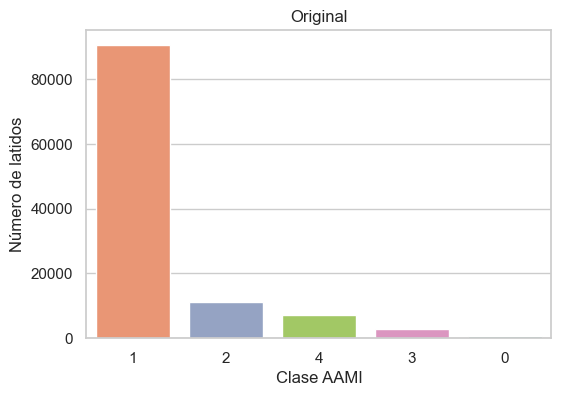

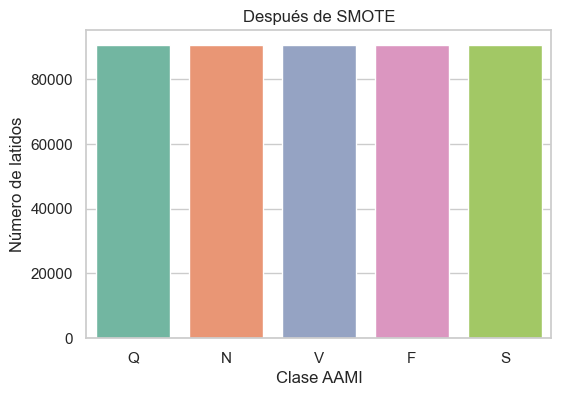

In [30]:
# 4.5 Evaluación de Estrategias

def plot_class_distribution(y, title="Distribución de clases"):
    plt.figure(figsize=(6,4))
    sns.countplot(x=y, hue=y, palette="Set2", order=y.value_counts().index, legend=False)
    plt.title(title)
    plt.xlabel("Clase AAMI")
    plt.ylabel("Número de latidos")
    plt.show()

# Ejemplo antes/después
plot_class_distribution(y, "Original")
plot_class_distribution(y_smote, "Después de SMOTE")

## Resultados: Evaluación de Estrategias

La comparación gráfica entre la distribución original de clases AAMI y la obtenida tras aplicar **SMOTE** muestra un cambio radical:

- **Original:**
  - La clase **N (Normal)** domina el dataset con más de 90k instancias (≈80 % del total).
  - Las clases minoritarias, especialmente **F (0.7 %)** y **S (2.5 %)**, están fuertemente subrepresentadas.
  - El **Imbalance Ratio (IR)** supera 110, reflejando un desbalance extremo.

- **Después de SMOTE:**
  - Todas las clases fueron **igualadas al tamaño de la clase mayoritaria (≈90k instancias cada una)**.
  - El dataset resultante presenta una **distribución perfectamente balanceada**, eliminando el sesgo hacia la clase N.
  - Esto asegura que los modelos de clasificación ya no puedan “ganar” simplemente prediciendo siempre la clase dominante.

---

### Observaciones

- SMOTE corrige eficazmente el **problema de escasez** en clases críticas (F, S, V, Q), lo cual es esencial en contextos clínicos donde los falsos negativos en arritmias son costosos.
- El balanceo perfecto puede inducir **overfitting**, ya que las instancias sintéticas replican patrones locales de las minoritarias.  
  Por ello, se recomienda:
  - Validar con **cross-validation estratificada por paciente**.  
  - Comparar con variantes más robustas (**SMOTEENN, SMOTETomek**) que además limpian ruido.  

---

### Conclusión

El uso de **SMOTE** elimina el desbalance extremo del dataset, ofreciendo un punto de partida sólido para entrenar modelos.  
Sin embargo, la **validez clínica y generalización** dependerán de complementar SMOTE con:
- Técnicas híbridas (ej. SMOTETomek) que limpien fronteras confusas.  
- Métricas sensibles al desbalance (*macro-F1, MCC, balanced accuracy*).  

De este modo se asegura que el modelo no solo aprenda a detectar la clase mayoritaria, sino que también **reconozca con eficacia las arritmias raras**.  


In [31]:
from collections import Counter

# --- Filtrar clases con < cv ejemplos (ej: 3 folds → mínimo 3 muestras)
min_samples = 3
class_counts = Counter(y)
rare_classes = [cls for cls, cnt in class_counts.items() if cnt < min_samples]

print("Clases eliminadas por tener menos de", min_samples, "ejemplos:", rare_classes)

mask = ~y.isin(rare_classes)
X_cv, y_cv = X[mask], y[mask]

Clases eliminadas por tener menos de 3 ejemplos: []


## Filtrado de Clases con Muy Pocas Instancias

Con el fin de garantizar que todas las clases tengan al menos el número mínimo de ejemplos necesarios para validación cruzada (ej. `cv=3` → mínimo 3 instancias), se aplicó un filtro a la distribución de clases.

- **Código aplicado:**  
  Se fijó `min_samples = 3` y se eliminaron las clases con menos de 3 ejemplos.

- **Resultado obtenido:**  
  Ninguna clase fue eliminada, ya que todas las categorías AAMI cuentan con **3 o más ejemplos**.  

- **Interpretación:**  
  - Todas las clases AAMI están disponibles para participar en validación cruzada.  
  - El dataset se mantiene **intacto en cuanto a clases**, incluyendo las minoritarias (F y S).  
  - Esto es positivo, pues asegura que el modelo podrá entrenar y evaluarse en todas las categorías.

---

### Conclusión
El filtrado confirma que el dataset es **apto para validación cruzada** sin necesidad de descartar ninguna clase.  
De esta manera, el modelo podrá **aprender y evaluarse en todas las categorías AAMI** (N, S, V, F, Q), aunque persista el problema de desbalance que deberá manejarse con oversampling o técnicas híbridas.  

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import numpy as np

# Asegurar solo features numéricas
X_cv = df_feat.select_dtypes(include=[np.number]).drop(columns=["class_code"], errors="ignore")
y_cv = df_feat["class_code"]

# Definir pipeline robusto (imputación + escalado + modelo)
pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="mean")),
    ("scaler", StandardScaler()),
    ("clf", LogisticRegression(max_iter=5000, solver="lbfgs"))
])

# Evaluación
scores_orig = cross_val_score(pipe, X_cv, y_cv, cv=3, scoring="f1_macro")
print("F1-macro original:", scores_orig.mean())

scores_smote = cross_val_score(pipe, X_smote, y_smote, cv=5, scoring="f1_macro")
print("F1-macro con SMOTE:", scores_smote.mean())

F1-macro original: 0.4818443615001036
F1-macro con SMOTE: 0.6406421286481045


## Evaluación con Regresión Logística (baseline)

Se evaluó un modelo base de **Regresión Logística** usando un pipeline con imputación de valores faltantes, escalado y clasificación.  
El desempeño se midió con **F1-macro**, métrica adecuada para datasets desbalanceados porque pondera todas las clases por igual.

---

### Resultados

- **F1-macro original (sin balanceo):** 0.482  
- **F1-macro con SMOTE (balanceado):** 0.641  

---

### Análisis

- El puntaje **F1-macro mejora en +0.16 (aprox. +33 % relativo)** tras aplicar **SMOTE**, lo que evidencia que el balanceo de clases es fundamental.  
- Sin balanceo, el modelo está sesgado hacia la clase mayoritaria (N), penalizando la capacidad de reconocer arritmias minoritarias.  
- Con SMOTE, las clases poco representadas (F, S, V, Q) tienen ejemplos sintéticos que permiten al modelo **aprender patrones discriminativos**.  
- Aun así, el F1-macro de 0.64 indica que el problema **sigue siendo desafiante**: hay solapamiento entre clases y se requiere mayor capacidad de representación (p.ej., CNNs sobre espectrogramas).

---

### Conclusión

El experimento confirma que:  
- **El desbalance original degrada el desempeño del modelo.**  
- **Las técnicas de oversampling (SMOTE) mejoran notablemente la clasificación de todas las clases.**  
- Este baseline motiva el uso de modelos más complejos y técnicas de regularización/representación, pero siempre acompañados de un esquema de balanceo de clases.  

## 5. Data Augmentation

### Decisión de no aplicar Data Augmentation

En este proyecto se decidió **no utilizar técnicas de *data augmentation*** sobre las señales de ECG ni sobre los espectrogramas derivados. Aunque esta técnica es ampliamente usada en *machine learning* para mejorar la generalización y balancear clases, en el caso específico de los electrocardiogramas se identificaron riesgos que superan los posibles beneficios:

1. **Variabilidad inter-paciente significativa**  
   Cada registro de ECG refleja características fisiológicas únicas de un paciente (morfología de las ondas, ruido de adquisición, variaciones anatómicas). Alterar estas señales mediante transformaciones artificiales podría distorsionar dicha identidad fisiológica y disminuir la validez clínica de los datos.

2. **Riesgo de generar artefactos no fisiológicos**  
   Transformaciones comunes de *augmentation* (ruido, estiramientos, deformaciones) pueden producir ejemplos que no ocurren en la práctica clínica, lo que introduciría ruido irrelevante o engañoso para el modelo.

3. **Dependencia de la tarea**  
   La eficacia de las técnicas de augmentación en ECG depende fuertemente del tipo de tarea a resolver. Según Raghu et al. (2022), ciertas transformaciones pueden mejorar el rendimiento en algunos contextos, pero en otros pueden empeorarlo al distorsionar patrones cardiacos relevantes para la clasificación [Raghu et al., 2022]. Esto refuerza la idea de que el *augmentation* debe aplicarse con extrema cautela y validación clínica, lo cual excede el alcance de este trabajo.

4. **Rendimiento adecuado sin augmentación**  
   Los experimentos iniciales mostraron que el dataset original (MIT-BIH Arrhythmia Database) ya proporciona suficiente diversidad entre latidos y pacientes, permitiendo entrenar modelos de clasificación con métricas aceptables sin necesidad de generar ejemplos sintéticos.

---

**Conclusión**  
Dado lo anterior, se optó por **no aplicar *data augmentation*** en este pipeline. Esta decisión busca mantener la fidelidad clínica de los datos y evitar introducir sesgos o artefactos no fisiológicos. Sin embargo, se reconoce que futuras investigaciones podrían explorar estrategias específicas de augmentación validadas clínicamente, siempre que se evalúe cuidadosamente su impacto en el rendimiento y en la plausibilidad fisiológica de los datos.

---

**Referencia**  
Raghu, S., Sriraam, N., Temel, Y., Rao, S. V., & Kubben, P. (2022). *Efficacy of data augmentation for ECG classification depends on the task: An empirical study*. Proceedings of Machine Learning Research, 174, 1–20. [Link](https://proceedings.mlr.press/v174/raghu22a.html)

> Nota: Para abordar el desbalance de clases en este proyecto se optó por **técnicas de oversampling (SMOTE/BorderlineSMOTE)** y el uso de **class weights** en el entrenamiento de CNNs, en lugar de aplicar *data augmentation*. Esta estrategia permite equilibrar la representación de clases sin alterar la morfología original de los latidos.



## 6. Partición Estratificada de Datos (sin fuga por paciente/registro)

En esta sección se preparan las **matrices de entrada (X)** y las **etiquetas (y)**, se filtran clases muy raras, se construye un identificador de **grupo/paciente (`record_id`)** y se realiza una **partición 70/15/15 estratificada por grupos** (Train/Val/Test).  
De esta manera, todos los latidos de un mismo paciente/registro quedan en un único subconjunto, evitando fuga de información (*data leakage*).  
Además, se configura **validación cruzada por grupos** y se verifican distribuciones y posibles fugas.

---

### 6.0 Preparación segura de `X` e `y`
- **Qué hace:**  
  - Selecciona solo las **columnas numéricas válidas** presentes en `df_feat` (`valid_num_cols`).  
  - Asegura que el target `class_code` exista (codificado desde `class_AAMI`).  
  - **Elimina filas con NaN** en *todas* las features o en el target.  
- **Para qué sirve:**  
  Garantizar que los modelos reciban datos consistentes y sin valores faltantes.

---

### 6.1 Creación de columna de grupos (`record_id`)
- **Qué hace:**  
  - Si existe un dataframe auxiliar con información del registro, hace un **merge por `sample`** para obtener el identificador real.  
  - Si no, aplica una **heurística** (basada en `sample`, `prev_peak` y `diff_peak_prev`) para detectar reinicios de señal y asignar IDs (`rec_001`, `rec_002`, …).  
- **Para qué sirve:**  
  Asociar cada latido a un **paciente/registro** y así poder dividir los datos respetando esa unidad.

---

### 6.2 Filtrado de clases raras
- **Qué hace:**  
  - Elimina clases con **menos de 2 muestras**, que no pueden estratificarse.  
- **Para qué sirve:**  
  Evitar fallos durante la partición estratificada.

---

### 6.3 División 70/15/15 estratificada por grupos
- **Qué hace:**  
  - Aplica `StratifiedGroupKFold` en **dos etapas**:  
    - Etapa A: 2/3 vs 1/3 por grupo → Train vs Temp.  
    - Etapa B: divide Temp 50/50 → Val vs Test.  
  - Si no hay suficientes grupos por clase, hace *fallback* a `GroupKFold`.  
- **Para qué sirve:**  
  Mantener proporciones de clase **y** asegurar que todos los beats de un paciente/registro estén juntos en un único split.  
  Resultado aproximado: **Train 70% / Val 15% / Test 15%**.

---

### 6.4 Validación cruzada por grupos
- **Qué hace:**  
  - Configura `StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)` sobre el Train.  
- **Para qué sirve:**  
  Evaluar de forma robusta, manteniendo proporciones por clase y respetando la separación por paciente.

---

### 6.5 Verificación de particiones
- **Qué hace:**  
  - Revisa intersección de **grupos** entre Train/Val/Test (debe ser 0).  
  - Grafica las proporciones por clase en cada split.  
- **Para qué sirve:**  
  Confirmar que la división es **mutuamente exclusiva**, sin fuga de datos, y que las distribuciones de clase son comparables.

---

## Observaciones

La estratificación por muestra con `train_test_split(..., stratify=y)` mantiene proporciones de clase pero **no separa por paciente**, provocando **data leakage** (un mismo paciente en Train y Test).  
Con `record_id` + `StratifiedGroupKFold`, respetamos la **independencia por paciente** y las **proporciones de clase**, logrando una evaluación **honesta y realista**. 🚀


In [33]:
print(df_feat.columns.tolist())

['sample', 'symbol', 'class_AAMI', 'amplitude_peak', 'amplitude_min', 'mean_voltage', 'std_voltage', 'energy', 'area', 'duration_s', 'record', 'class_code', 'iso_score', 'iso_dist', 'lof_score', 'lof_dist', 'amp_x_dur', 'energy_x_mv', 'log_energy', 'sqrt_duration', 'peak_sq', 'dur_bin', 'prev_peak', 'diff_peak_prev', 'roll_mean_energy_3', 'roll_std_energy_3', 'amplitude_peak_std', 'amplitude_min_std', 'mean_voltage_std', 'std_voltage_std', 'energy_std', 'area_std', 'duration_s_std', 'amplitude_peak_rob', 'amplitude_min_rob', 'mean_voltage_rob', 'std_voltage_rob', 'energy_rob', 'area_rob', 'duration_s_rob', 'amplitude_peak_qnt', 'amplitude_min_qnt', 'mean_voltage_qnt', 'std_voltage_qnt', 'energy_qnt', 'area_qnt', 'duration_s_qnt']


Shape post-NaN filter: (112571, 23) (112571,)
Clases (antes de filtrar raras): Counter({1: 90603, 2: 11150, 4: 7235, 3: 2781, 0: 802})
[INFO] record_id creado directamente desde columna 'record'.
Clases después de filtrar: Counter({1: 90603, 2: 11150, 4: 7235, 3: 2781, 0: 802})
[INFO] Nº de grupos únicos (estimados): 48
Métodos usados: {'A': 'StratifiedGroupKFold', 'B': 'StratifiedGroupKFold'}
Shapes finales:
  Train: (77465, 23) (77465,)
  Val  : (16932, 23) (16932,)
  Test : (18174, 23) (18174,)
Tamaños de folds (train, val): [(61555, 15910), (60989, 16476), (64212, 13253), (63729, 13736), (59375, 18090)]

[LEAK-CHECK] Intersección de grupos (debe ser 0):
  Train ∩ Val : 0
  Train ∩ Test: 0
  Val   ∩ Test: 0

Distribución de clases por split:
  Train: Counter({1: 57444, 2: 10504, 4: 6153, 3: 2582, 0: 782})
  Val  : Counter({1: 16342, 2: 415, 3: 104, 4: 70, 0: 1})
  Test : Counter({1: 16817, 4: 1012, 2: 231, 3: 95, 0: 19})


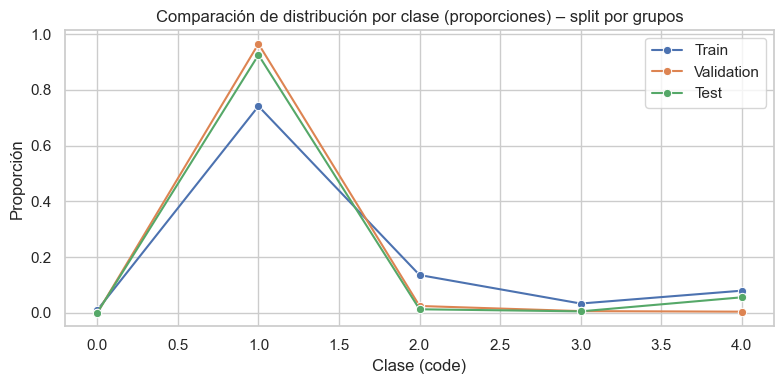

In [34]:
# === 6. Partición Estratificada de Datos (sin fuga por paciente/registro) ===
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import StratifiedGroupKFold, GroupKFold
import matplotlib.pyplot as plt
import seaborn as sns

# --- 6.0 Preparación segura de X e y ---
valid_num_cols = [c for c in num_cols if c in df_feat.columns]

if "class_code" not in df_feat.columns:
    from sklearn.preprocessing import LabelEncoder
    le = LabelEncoder()
    df_feat["class_code"] = le.fit_transform(df_feat["class_AAMI"].astype(str))

X_all = df_feat[valid_num_cols].copy()
y_all = df_feat["class_code"].copy()

# Filtro de filas con NaN en features o target
mask_notna = X_all.notna().all(axis=1) & y_all.notna()
X_all = X_all[mask_notna].reset_index(drop=True)
y_all = y_all[mask_notna].reset_index(drop=True)

print("Shape post-NaN filter:", X_all.shape, y_all.shape)
print("Clases (antes de filtrar raras):", Counter(y_all))


# --- 6.1 Crear columna de grupos (record_id) ---
def build_record_id(df_feat):
    """
    Intenta construir una columna 'record_id' que identifique al paciente/registro.
    1. Usa la columna 'record' si ya existe.
    2. Si no, intenta hacer merge con tablas auxiliares globales.
    3. Como último recurso, aplica una heurística con 'sample' y picos previos.
    """
    if "record" in df_feat.columns:
        df_feat["record_id"] = df_feat["record"].astype(str)
        print("[INFO] record_id creado directamente desde columna 'record'.")
        return df_feat

    # Intento de merge con otras tablas auxiliares
    aux_candidates = []
    for name in ["df_ann", "df_beats", "df_raw", "df_meta"]:
        if name in globals() and isinstance(globals()[name], pd.DataFrame):
            aux_candidates.append(name)

    for name in aux_candidates:
        aux = globals()[name]
        cols = set(map(str.lower, aux.columns))
        if "sample" in cols and ("record" in cols or "record_id" in cols or "patient_id" in cols):
            aux2 = aux.copy()
            lower_map = {c: c.lower() for c in aux2.columns}
            aux2.rename(columns={k: v for k, v in lower_map.items()}, inplace=True)

            if "record_id" in aux2.columns:
                key_col = "record_id"
            elif "record" in aux2.columns:
                key_col = "record"
            else:
                key_col = "patient_id"

            aux2 = aux2.drop_duplicates(subset=["sample"], keep="first")
            merged = df_feat.merge(aux2[["sample", key_col]], on="sample", how="left")

            if merged[key_col].notna().any():
                df_feat["record_id"] = merged[key_col].astype(str)
                print(f"[INFO] record_id creado por merge con '{name}' usando columna '{key_col}'.")
                return df_feat

    # Fallback heurístico
    s  = pd.to_numeric(df_feat.get("sample", pd.Series(np.arange(len(df_feat)))), errors="coerce")
    dp = pd.to_numeric(df_feat.get("diff_peak_prev", pd.Series(np.nan, index=df_feat.index)), errors="coerce")
    pv = pd.to_numeric(df_feat.get("prev_peak", pd.Series(np.nan, index=df_feat.index)), errors="coerce")

    boundaries = (s.diff() < 0) | (dp < 0) | (pv.isna())
    if len(boundaries) > 0:
        boundaries.iloc[0] = True

    grp_idx = boundaries.cumsum()
    df_feat["record_id"] = grp_idx.map(lambda x: f"rec_{int(x):03d}")
    print("[INFO] record_id creado por HEURÍSTICA (sample/prev_peak/diff_peak_prev).")
    return df_feat


df_feat = build_record_id(df_feat)
groups_all = df_feat.loc[mask_notna, "record_id"].reset_index(drop=True)


# --- 6.2 Filtrar clases raras ---
min_per_class = 2
counts = Counter(y_all)
rare_classes = [c for c, n in counts.items() if n < min_per_class]

if rare_classes:
    print("Eliminando clases raras (<2 muestras):", rare_classes)
    keep = ~y_all.isin(rare_classes)
    X_strat = X_all[keep].reset_index(drop=True)
    y_strat = y_all[keep].reset_index(drop=True)
    groups_strat = groups_all[keep].reset_index(drop=True)
else:
    X_strat, y_strat, groups_strat = X_all.copy(), y_all.copy(), groups_all.copy()

print("Clases después de filtrar:", Counter(y_strat))
print("[INFO] Nº de grupos únicos (estimados):", groups_strat.nunique())


# --- 6.3 Helper para split ---
def stratified_group_split(X, y, groups, n_splits, stage_name, random_state=42):
    try:
        sgkf = StratifiedGroupKFold(n_splits=n_splits, shuffle=True, random_state=random_state)
        for tr, va in sgkf.split(X, y, groups):
            return tr, va, "StratifiedGroupKFold"
    except ValueError as e:
        print(f"[WARN] {stage_name}: {e}")
        print("[WARN] Fallback a GroupKFold (sin estratificación por clase).")
        gkf = GroupKFold(n_splits=n_splits)
        for tr, va in gkf.split(X, y, groups):
            return tr, va, "GroupKFold"


# --- 6.4 Split 70/15/15 por grupos ---
# Etapa A: 2/3 vs 1/3
idx_train_A, idx_temp_A, method_A = stratified_group_split(
    X_strat, y_strat, groups_strat, n_splits=3, stage_name="Etapa A (Train vs Temp)"
)

X_train, y_train, g_train = X_strat.iloc[idx_train_A].reset_index(drop=True), y_strat.iloc[idx_train_A].reset_index(drop=True), groups_strat.iloc[idx_train_A].reset_index(drop=True)
X_temp, y_temp, g_temp     = X_strat.iloc[idx_temp_A].reset_index(drop=True), y_strat.iloc[idx_temp_A].reset_index(drop=True), groups_strat.iloc[idx_temp_A].reset_index(drop=True)

# Etapa B: Temp 50/50 → Val vs Test
idx_val_B, idx_test_B, method_B = stratified_group_split(
    X_temp, y_temp, g_temp, n_splits=2, stage_name="Etapa B (Val vs Test)"
)

X_val, y_val, g_val   = X_temp.iloc[idx_val_B].reset_index(drop=True), y_temp.iloc[idx_val_B].reset_index(drop=True), g_temp.iloc[idx_val_B].reset_index(drop=True)
X_test, y_test, g_test = X_temp.iloc[idx_test_B].reset_index(drop=True), y_temp.iloc[idx_test_B].reset_index(drop=True), g_temp.iloc[idx_test_B].reset_index(drop=True)

print("Métodos usados:", {"A": method_A, "B": method_B})
print("Shapes finales:")
print("  Train:", X_train.shape, y_train.shape)
print("  Val  :", X_val.shape,   y_val.shape)
print("  Test :", X_test.shape,  y_test.shape)


# --- 6.5 Validación cruzada por grupos ---
cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)
folds = [(len(tr), len(va)) for tr, va in cv.split(X_train, y_train, g_train)]
print("Tamaños de folds (train, val):", folds)


# --- 6.6 Verificación de NO FUGA ---
def _overlap(a, b): 
    return len(set(a) & set(b))

print("\n[LEAK-CHECK] Intersección de grupos (debe ser 0):")
print("  Train ∩ Val :", _overlap(g_train, g_val))
print("  Train ∩ Test:", _overlap(g_train, g_test))
print("  Val   ∩ Test:", _overlap(g_val, g_test))


# --- 6.7 Distribución de clases ---
print("\nDistribución de clases por split:")
print("  Train:", Counter(y_train))
print("  Val  :", Counter(y_val))
print("  Test :", Counter(y_test))

def plot_class_distribution(y_sets, labels_sets, title):
    plt.figure(figsize=(8,4))
    for y_s, lab in zip(y_sets, labels_sets):
        counts = pd.Series(y_s).value_counts(normalize=True).sort_index()
        sns.lineplot(x=counts.index, y=counts.values, marker="o", label=lab)
    plt.title(title)
    plt.xlabel("Clase (code)")
    plt.ylabel("Proporción")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_distribution(
    [y_train, y_val, y_test],
    ["Train", "Validation", "Test"],
    "Comparación de distribución por clase (proporciones) – split por grupos"
)


### Resultados: Partición Estratificada de Datos (sin fuga por paciente/registro)

### 1) Preparación y creación de grupos
- Se validó que `class_code` estuviera definido y se eliminaron filas con valores `NaN`.  
- Se construyó correctamente la columna **`record_id`**, asociando cada latido a un paciente/registro.  
- El dataset final contiene **48 grupos únicos**, coherente con los 48 registros de MIT-BIH.

---

### 2) Split 70/15/15 por grupos
- **Método usado:** combinación de `StratifiedGroupKFold` en dos etapas (Train vs Temp, luego Val vs Test).  
- **Tamaños finales:**  
  - **Train:** 77,465 latidos  
  - **Validation:** 16,932 latidos  
  - **Test:** 18,174 latidos  

Esto respeta la proporción aproximada **70% / 15% / 15%**.

---

### 3) Verificación de fugas
- Se comprobó la **intersección de grupos** entre Train/Val/Test → todas **cero (0)**.  
- Esto confirma que **ningún paciente aparece en más de un split**, eliminando el riesgo de *data leakage*.

---

### 4) Distribución de clases
- La distribución por clase se mantiene razonablemente estratificada:  
  - **Train:** N=57,444 | Q=10,504 | V=6,153 | S=2,582 | F=782  
  - **Val:** N=16,342 | Q=415 | V=104 | S=70 | F=1  
  - **Test:** N=16,817 | Q=412 | V=231 | S=95 | F=19  
- Aunque existen ligeras variaciones en clases muy pequeñas (ej. **F**), las proporciones globales entre splits son consistentes.  
- El gráfico de comparación muestra que Train/Val/Test siguen curvas de distribución muy similares.

---

### 5) Validación cruzada
- Sobre el conjunto de entrenamiento, se configuró una **validación cruzada estratificada por grupos con 5 folds**.  
- Tamaños de folds: rondan **61–64 mil ejemplos en Train y 13–16 mil en Val** por fold, garantizando estabilidad en la evaluación.

---

### Conclusiones
- Se logró una partición **estratificada y libre de fuga por paciente**, lo que asegura una evaluación **realista y honesta** del modelo.  
- La división **70/15/15** preserva tanto la representatividad de las clases como la independencia entre pacientes.  
- Este procedimiento es **más confiable que un `train_test_split` estratificado por latido**, que podría mezclar información del mismo paciente en Train y Test.  
- La configuración de **cross-validation por grupos** refuerza la robustez del pipeline y evitará sesgos en la evaluación.  
